In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen/') # to import ccsds
import ccsds

import ctypes
libfec = ctypes.CDLL('libfec.so')

import struct
import collections
import pathlib

In [2]:
CE5_AOSInsertZone = Struct(
    'unknown1' / Hex(Int8ub),
    'unknown2' / Int8ub,
    'unknown3' / Hex(Int8ub),
    'unknown4' / Hex(Int8ub),
    'timestamp' / Int32ul, # in units of 1s, epoch 2012-08-01 UTC
)

CE5_AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'insert_zone' / CE5_AOSInsertZone,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes
)

def get_packet(p):
    return p[0] if type(p) is tuple else p

def packets_asarray(packets):
    return np.array([np.frombuffer(get_packet(p)[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
                     for p in packets])

def plot_apids(apids, sc, vc):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0])
        plt.title(f"Chang'e 5 APID {apid} Virtual channel {vc}")

def get_packet_timestamps(packets):
    return np.datetime64('2012-08-01') + np.timedelta64(1,'s')*np.array([p[1] for p in packets])

Here we look at some Chang'e 5 low data rate telemetry decoded by [USA Satcom](https://twitter.com/usa_satcom).

The frames are CCSDS concatenated frames with a frames size of 256 bytes including the 32bit ASM. We need to perform Reed-Solomon decoding with libfec first.

In [3]:
def load_frames(path):
    frame_size = 256
    frames = np.fromfile(path, dtype = 'uint8')
    frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
    # drop ccsds header
    frames = frames[:, 4:]
    return frames


frames = np.concatenate([load_frames(f) for f in sorted(pathlib.Path('usa_satcom_frames').glob('*.frm'))])

rs_ret = [libfec.decode_rs_ccsds(f.ctypes.data_as(ctypes.POINTER(ctypes.c_char)), 0, 0, 3) for f in frames]
frames = frames[:,:-32] # drop RS bytes

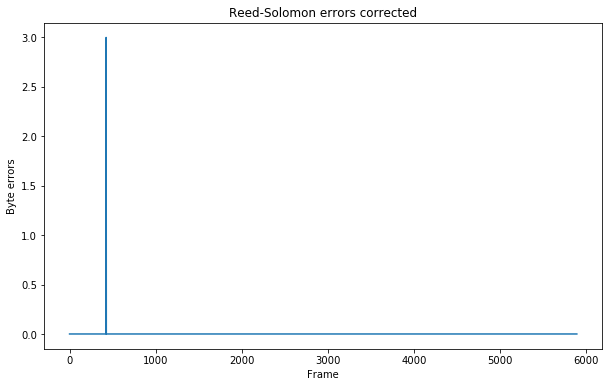

In [4]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(rs_ret)
plt.title('Reed-Solomon errors corrected')
plt.xlabel('Frame')
plt.ylabel('Byte errors');

## AOS frames

AOS frames come from spacecraft 91 and virtual channels 1 and 2. Other combinations are most likely to corruted frames despite the fact that the Reed-Solomon decoder was successful.

In [5]:
aos = [CE5_AOSFrame.parse(f) for f in frames]

In [6]:
collections.Counter([a.primary_header.transfer_frame_version_number for a in aos])

Counter({1: 5893, 2: 1})

In [7]:
collections.Counter([a.primary_header.spacecraft_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({91: 5893})

In [8]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({1: 5888, 2: 5})

## Virtual channel 2

Virtual channel 2 is only used for a few frames. The AOS frames (also those in virtual channel 1) contain four unknown bytes and then a little-endian 32bit timestamp that counts seconds since 2012-08-01T00:00:00 UTC. The AOS frames (also in virtual channel 1) use M_PDU and Space Packets.

In [9]:
vc2 = [a for a in aos if a.primary_header.virtual_channel_id == 2]
[a.primary_header for a in vc2]

[Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=2, virtual_channel_frame_count=316, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=2, virtual_channel_frame_count=317, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=2, virtual_channel_frame_count=318, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=2, virtual_channel_frame_count=319, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=2, virtual_channel_frame_count=320, replay_flag=False, vc_frame_count_usage_flag=False, rsv

In [10]:
[a.insert_zone for a in vc2]

[Container(unknown1=192, unknown2=210, unknown3=177, unknown4=1, timestamp=262414570),
 Container(unknown1=192, unknown2=210, unknown3=177, unknown4=1, timestamp=262414572),
 Container(unknown1=192, unknown2=210, unknown3=177, unknown4=1, timestamp=262414574),
 Container(unknown1=192, unknown2=210, unknown3=177, unknown4=1, timestamp=262414576),
 Container(unknown1=192, unknown2=210, unknown3=177, unknown4=1, timestamp=262414578)]

Here the space packets belong to APID 897 and have all the same length (198 data bytes, which is the maximum that fits in one of these AOS frames).

In [11]:
vc2_packets = list(ccsds.extract_space_packets(vc2, 91, 2))
vc2_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc2_packets]

In [12]:
vc2_sp_headers

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=29, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=30, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=31, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=32, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=33, data_length=197)]

In [13]:
vc2_by_apid = {apid : [p for h,p in zip(vc2_sp_headers, vc2_packets)
                           if h.APID == apid] for apid in [897]}

The packets seem to do some kind of file transfer or memory dump. The first 3 bytes are the fixed value `0x510705`, which perhaps identifies the file to be transfer. Then we have a 32 bit little-endian block counter, followed by a block of data.

The last block is halfway filled with `0xaa` padding bytes.

In [14]:
packets_asarray(vc2_packets)[:,:8]

array([[51,  7,  5,  0,  0,  0,  0,  0],
       [51,  7,  5,  1,  0,  0,  0,  0],
       [51,  7,  5,  2,  0,  0,  0,  0],
       [51,  7,  5,  3,  0,  0,  0,  0],
       [51,  7,  5,  4,  0,  0,  0,  0]], dtype=uint8)

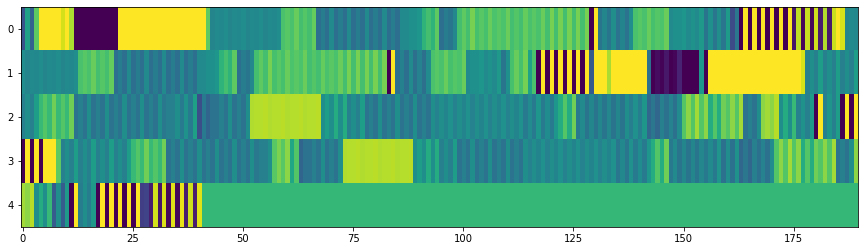

In [15]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(packets_asarray(vc2_packets)[:,8:], aspect = 10)

The data seems quite peculiar and full of patterns, but I can't guess what it is.

In [16]:
bytes(packets_asarray(vc2_packets)[:,8:].ravel()).hex()

'409250c0ffffffffffefffe000000000000000000000ffffffffffffffffffffffffffffffffffffffffc0747a777d747a777d747a777d747a777db6bdb6c4b4bcb4c35d6b5d7a5d6b5d7a5d6b5d7a5d6b5d7a5d6b5d7a7a808086a6b4a6c05d6b6376b4c0b4cbb5bdb5c4b7beb7c5b3bbb3c3b6beb6c5b4cbb4cbb4cbb4cbb4cb00ff6375637e6173617db6bdb6c4b5bcb7c57a8080867a837a896380647e648c3b6500ff00ff00ff00ff00ff00ff0ee705ea05ed13e212ebfff0747a777d747a777d747a777d747a777db6bdb6c4b4bcb4c35d6b5d7a5d6b5d7a5d6b5d7a5d6b5d7a5d6b5d7a7a808086a6b4a6c05d6b6376b4c0b4cbb5bdb5c4b7beb7c5b3bbb3c3b6beb6c5b4cbb4cbb4cbb4cbb4cb00ff5d705d7a5e715e7bb6bdb6c4b5bcb7c57a8080867a837a896380b5c4b5ca93b600ff00ff00ff00ff00ff00ff48ffffffdfffffffffffffffff6000080210000418000000008800fffffffffffffffffffffffffffffffffffffffffff06f7f6f8e6f7f6f8e6f7f6f8e6f7f6f8eadbbadc8adbbadc8616f617f616f617f616f617f616f617f616f617f666f6f7f688368913d695361616f617f616f617fe1e3e3e5e1e3e3e5e1e3e3e5e1e3e3e57f8e7f9e7f9e6f7f6f8e616f617f616f617f616f617f616f617f717e7381717e7381717e7381717e7381717e7381687b6886687

## Virtual channel 1

The vast majority of frames belong to virtual channel 1, which seems to send real-time telemetry.

In [17]:
[a.primary_header for a in aos if a.primary_header.virtual_channel_id == 1][:10]

[Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=40733, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=40734, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=40735, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=40736, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=40737, replay_flag=False, vc_frame_count_usage_flag=

In [18]:
vc1 = [a for a in aos if a.primary_header.virtual_channel_id == 1]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc1])
[a.insert_zone for a in aos[:10]]

[Container(unknown1=192, unknown2=223, unknown3=177, unknown4=1, timestamp=262413958),
 Container(unknown1=192, unknown2=223, unknown3=177, unknown4=1, timestamp=262413960),
 Container(unknown1=192, unknown2=223, unknown3=177, unknown4=1, timestamp=262413962),
 Container(unknown1=192, unknown2=223, unknown3=177, unknown4=1, timestamp=262413964),
 Container(unknown1=192, unknown2=223, unknown3=177, unknown4=1, timestamp=262413966),
 Container(unknown1=192, unknown2=223, unknown3=177, unknown4=1, timestamp=262413968),
 Container(unknown1=192, unknown2=223, unknown3=177, unknown4=1, timestamp=262413970),
 Container(unknown1=192, unknown2=223, unknown3=178, unknown4=1, timestamp=262413972),
 Container(unknown1=192, unknown2=223, unknown3=178, unknown4=1, timestamp=262413974),
 Container(unknown1=192, unknown2=223, unknown3=178, unknown4=1, timestamp=262413976)]

In [19]:
t_vc1 = np.datetime64('2012-08-01') + np.timedelta64(1, 's') * np.array([a.insert_zone.timestamp for a in vc1])

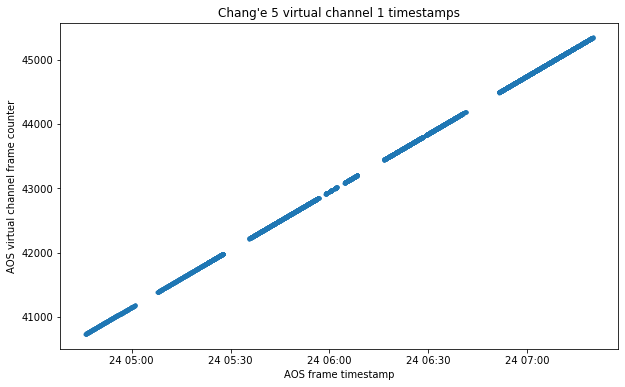

In [20]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t_vc1, fc, '.')
plt.title("Chang'e 5 virtual channel 1 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

We need to sort the data, since the different files we've loaded up are not in chronological order.

In [21]:
vc1_sorted = sorted(vc1, key = lambda a: a.insert_zone.timestamp)

In [22]:
vc1_packets = list(ccsds.extract_space_packets(vc1_sorted, 91, 1, get_timestamps = True))

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41058, current frame count 41062
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41069, current frame count 41072
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41075, current frame count 41079
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41861, current frame count 41861
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41862, current frame count 41862
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41863, current frame count 41863
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41918, current frame count 41918
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41919, current frame count 41919
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41920, current frame count 41920
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41961, current frame count 41961
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41962, current frame count 41962
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 41963, current frame count 41963
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42242, current frame count 42242
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42243, current frame count 42243
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42244, current frame count 42244
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42285, current frame count 42285
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42286, current frame count 42286
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42287, current frame count 42287
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42326, current frame count 42326
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42327, current frame count 42327
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42328, current frame count 42328
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42367, current frame count 42367
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42368, current frame count 42368
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42369, current frame count 42369
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42411, current frame count 42411
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42412, current frame count 42412
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42413, current frame count 42413
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42450, current frame count 42450
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42451, current frame count 42451
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42452, current frame count 42452
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42489, current frame count 42489
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42490, current frame count 42490
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42491, current frame count 42491
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42534, current frame count 42534
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42535, current frame count 42535
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42536, current frame count 42536
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42577, current frame count 42577
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42578, current frame count 42578
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42579, current frame count 42579
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42619, current frame count 42619
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42620, current frame count 42620
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42621, current frame count 42621
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42673, current frame count 42673
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42674, current frame count 42674
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42675, current frame count 42675
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42714, current frame count 42714
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42715, current frame count 42715
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42715, current frame count 42717
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42759, current frame count 42759
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42760, current frame count 42760
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42761, current frame count 42761
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42802, current frame count 42802
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42803, current frame count 42803
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42804, current frame count 42804
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42842, current frame count 42842
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42843, current frame count 42843
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42844, current frame count 42844
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42957, current frame count 42957
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42958, current frame count 42958
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 42959, current frame count 42959
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43089, current frame count 43089
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43090, current frame count 43090
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43091, current frame count 43091
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43129, current frame count 43129
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43130, current frame count 43130
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43131, current frame count 43131
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43169, current frame count 43169
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43170, current frame count 43170
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43171, current frame count 43171
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43449, current frame count 43449
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43450, current frame count 43450
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43451, current frame count 43451
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43487, current frame count 43487
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43488, current frame count 43488
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43489, current frame count 43489
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43525, current frame count 43525
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43526, current frame count 43526
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43527, current frame count 43527
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43562, current frame count 43562
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43563, current frame count 43563
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43564, current frame count 43564
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43614, current frame count 43614
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43615, current frame count 43615
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43616, current frame count 43616
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43666, current frame count 43666
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43667, current frame count 43667
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43668, current frame count 43668
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43706, current frame count 43706
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43707, current frame count 43707
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43708, current frame count 43708
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43749, current frame count 43749
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43750, current frame count 43750
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43751, current frame count 43751
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43789, current frame count 43789
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43790, current frame count 43790
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43791, current frame count 43791
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43853, current frame count 43853
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43854, current frame count 43854
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43855, current frame count 43855
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43890, current frame count 43890
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43891, current frame count 43891
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43892, current frame count 43892
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43938, current frame count 43938
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43939, current frame count 43939
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43940, current frame count 43940
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43971, current frame count 43971
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43972, current frame count 43972
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 43973, current frame count 43973
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44013, current frame count 44013
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44014, current frame count 44014
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44015, current frame count 44015
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44050, current frame count 44050
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44051, current frame count 44051
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44052, current frame count 44052
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44087, current frame count 44087
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44088, current frame count 44088
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44089, current frame count 44089
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44133, current frame count 44133
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44134, current frame count 44134
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44135, current frame count 44135
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44493, current frame count 44493
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44494, current frame count 44494
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44495, current frame count 44495
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44532, current frame count 44532
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44533, current frame count 44533
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44534, current frame count 44534
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44579, current frame count 44579
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44580, current frame count 44580
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44581, current frame count 44581
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44619, current frame count 44619
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44620, current frame count 44620
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44621, current frame count 44621
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44660, current frame count 44660
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44661, current frame count 44661
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44662, current frame count 44662
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44699, current frame count 44699
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44700, current frame count 44700
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44701, current frame count 44701
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44732, current frame count 44732
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44733, current frame count 44733
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44734, current frame count 44734
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44764, current frame count 44764
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44765, current frame count 44765
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44766, current frame count 44766
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44803, current frame count 44803
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44804, current frame count 44804
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44805, current frame count 44805
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44839, current frame count 44839
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44840, current frame count 44840
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44841, current frame count 44841
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44869, current frame count 44869
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44870, current frame count 44870
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44871, current frame count 44871
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44896, current frame count 44896
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44897, current frame count 44897
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44898, current frame count 44898
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44922, current frame count 44922
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44923, current frame count 44923
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44924, current frame count 44924
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44971, current frame count 44971
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44972, current frame count 44972
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 44973, current frame count 44973
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45004, current frame count 45004
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45005, current frame count 45005
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45006, current frame count 45006
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45036, current frame count 45036
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45037, current frame count 45037
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45038, current frame count 45038
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45081, current frame count 45081
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45082, current frame count 45082
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45083, current frame count 45083
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45120, current frame count 45120
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45121, current frame count 45121
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45122, current frame count 45122
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45160, current frame count 45160
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45161, current frame count 45161
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45162, current frame count 45162
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45208, current frame count 45208
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45209, current frame count 45209
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45210, current frame count 45210
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45249, current frame count 45249
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45250, current frame count 45250
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45251, current frame count 45251
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45289, current frame count 45289
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45290, current frame count 45290
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45291, current frame count 45291
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45330, current frame count 45330
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45331, current frame count 45331
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 45332, current frame count 45332
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet e

In [23]:
vc1_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in vc1_packets]

There are space packets in may APIDs. The contents of each APID are shown belown in plot form, but it's not easy to guess what any of the values mean.

In [24]:
vc1_apids = collections.Counter([p.APID for p in vc1_sp_headers])
vc1_apids

Counter({778: 353,
         1030: 2691,
         42: 1082,
         793: 739,
         59: 2692,
         532: 2716,
         812: 76,
         281: 1455,
         52: 1448,
         514: 1451,
         777: 1440,
         40: 2719,
         794: 82,
         41: 1294,
         537: 727,
         1040: 720,
         49: 734,
         35: 177,
         258: 191,
         48: 194,
         515: 355,
         13: 748,
         5: 738,
         43: 1091,
         16: 85,
         261: 90,
         33: 732,
         547: 88,
         779: 89,
         14: 721,
         34: 367,
         28: 737,
         516: 191,
         518: 185,
         285: 73,
         11: 379,
         27: 377,
         1039: 103,
         1031: 96,
         50: 165,
         1033: 103,
         815: 194,
         46: 45,
         1026: 98,
         259: 381,
         39: 387,
         51: 360,
         61: 373,
         31: 182,
         282: 379,
         29: 368,
         520: 299,
         7: 195,
         541: 

In [25]:
vc1_by_apid = {apid : [p for h,p in zip(vc1_sp_headers, vc1_packets)
                           if h.APID == apid] for apid in vc1_apids}

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


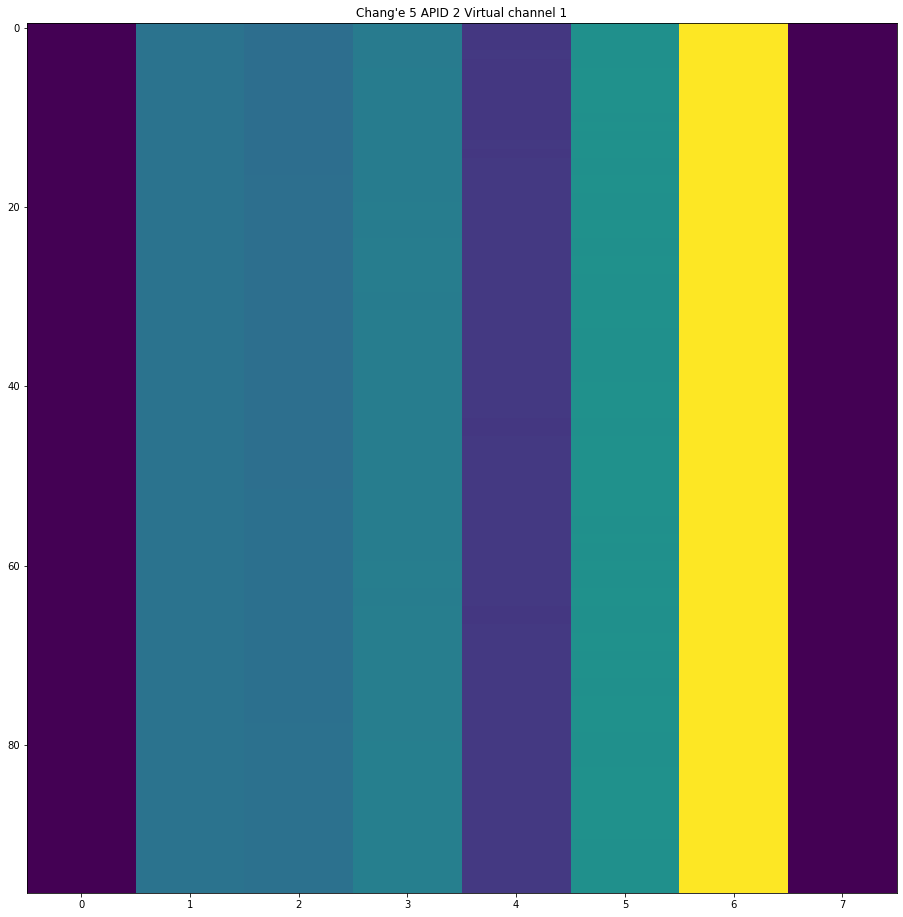

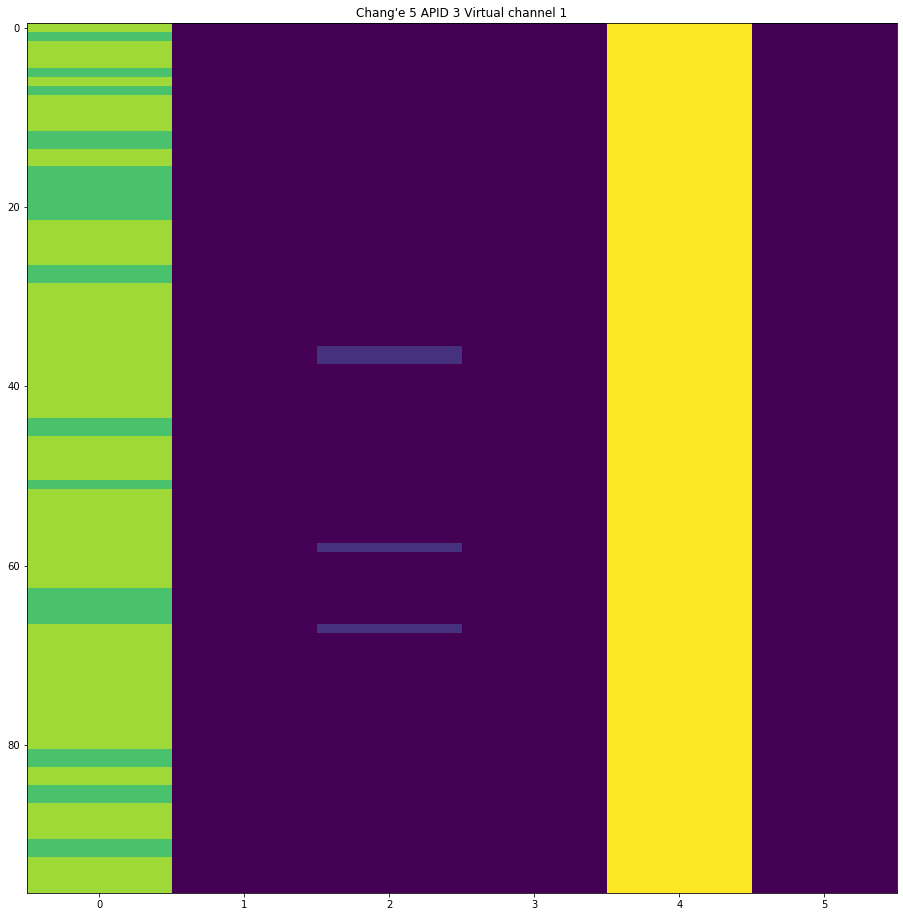

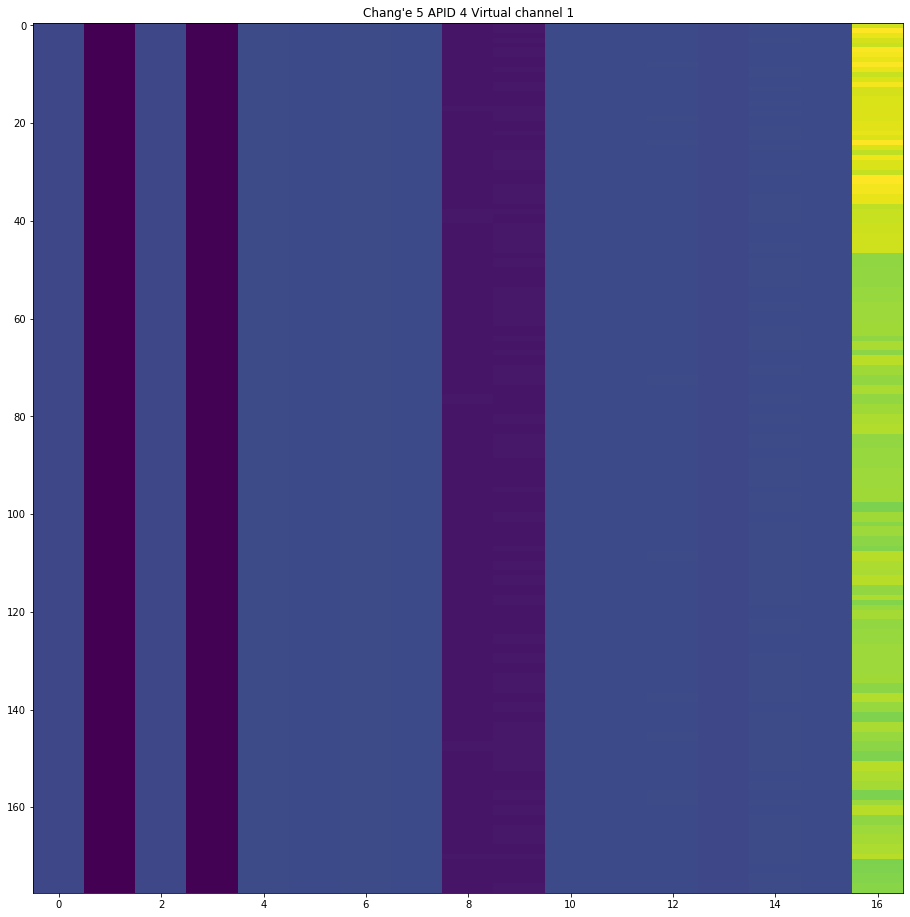

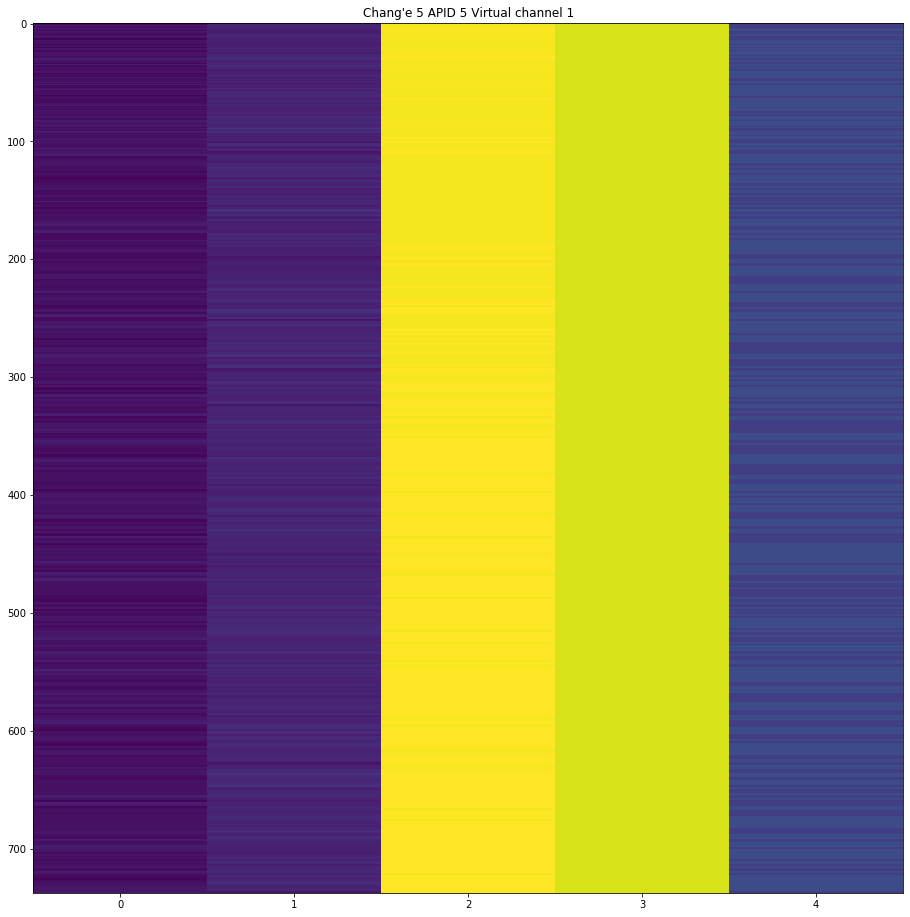

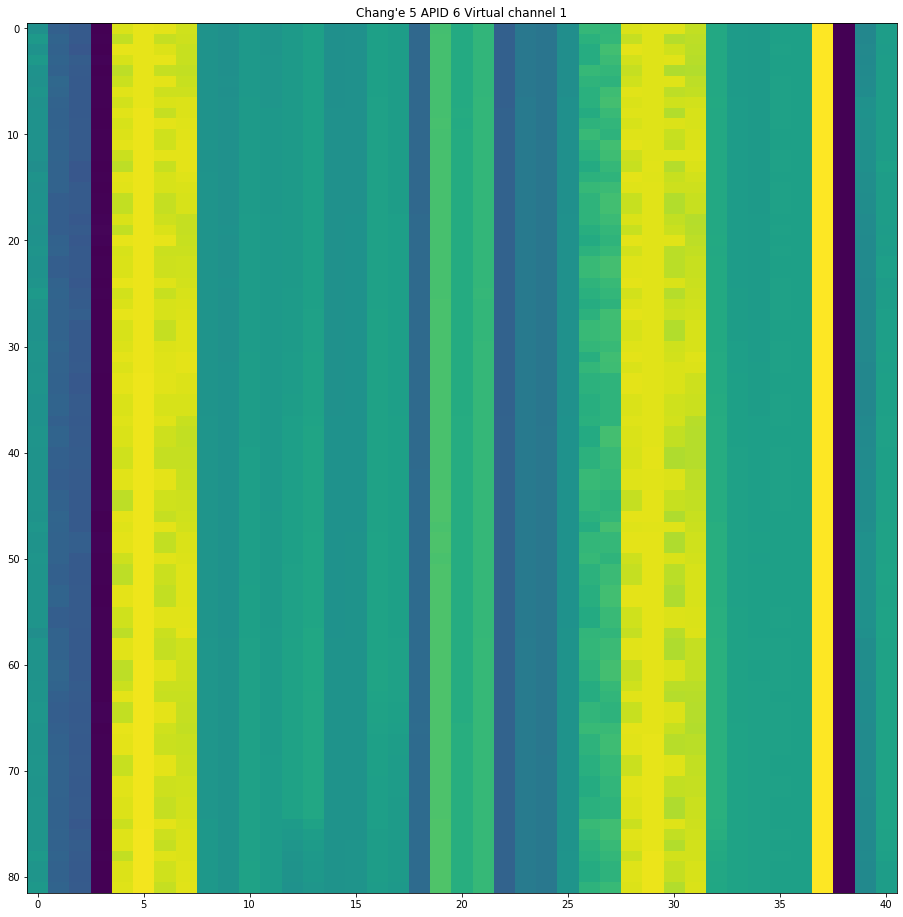

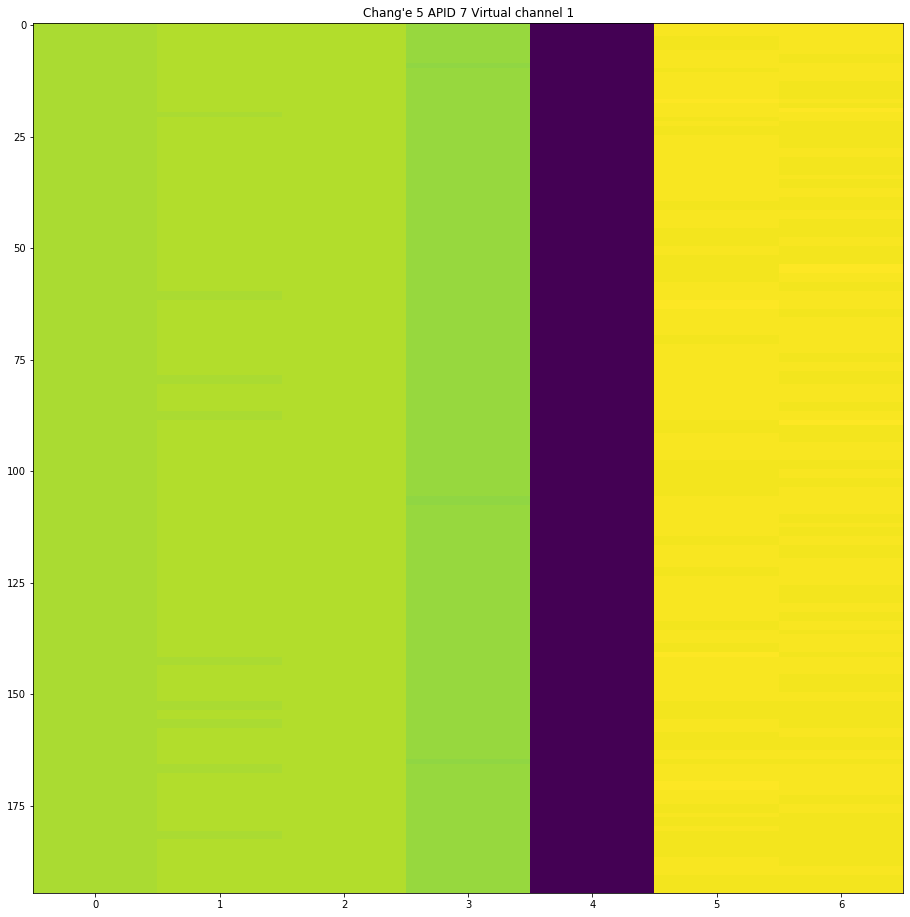

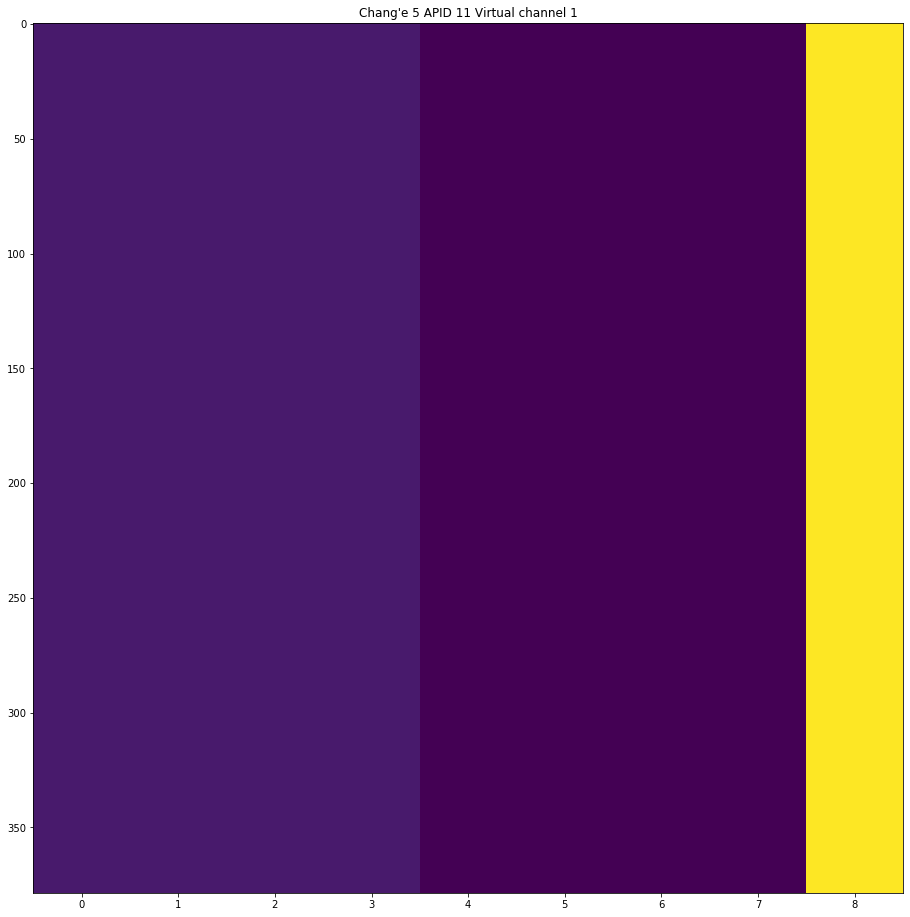

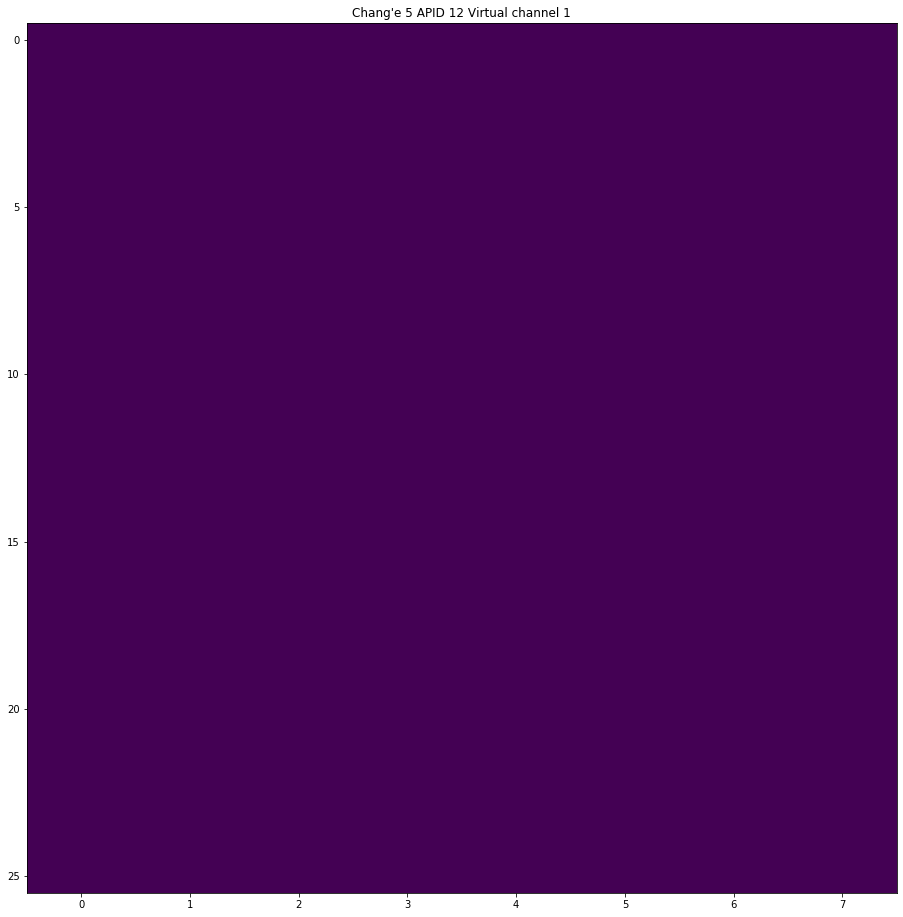

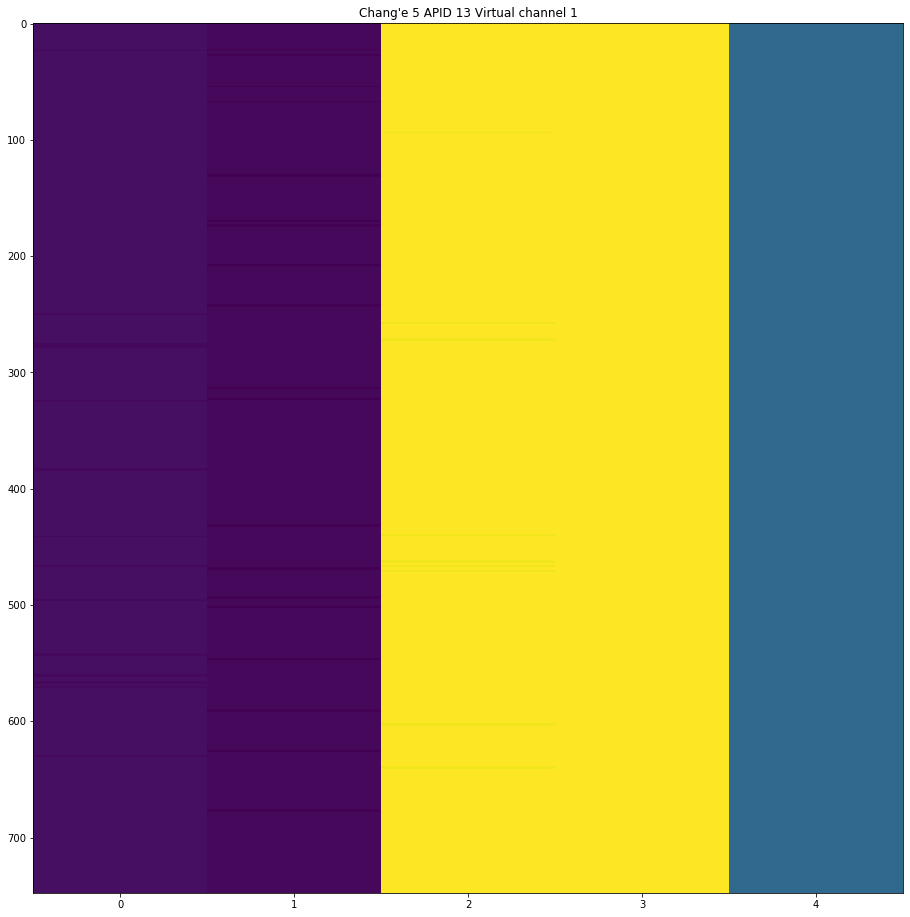

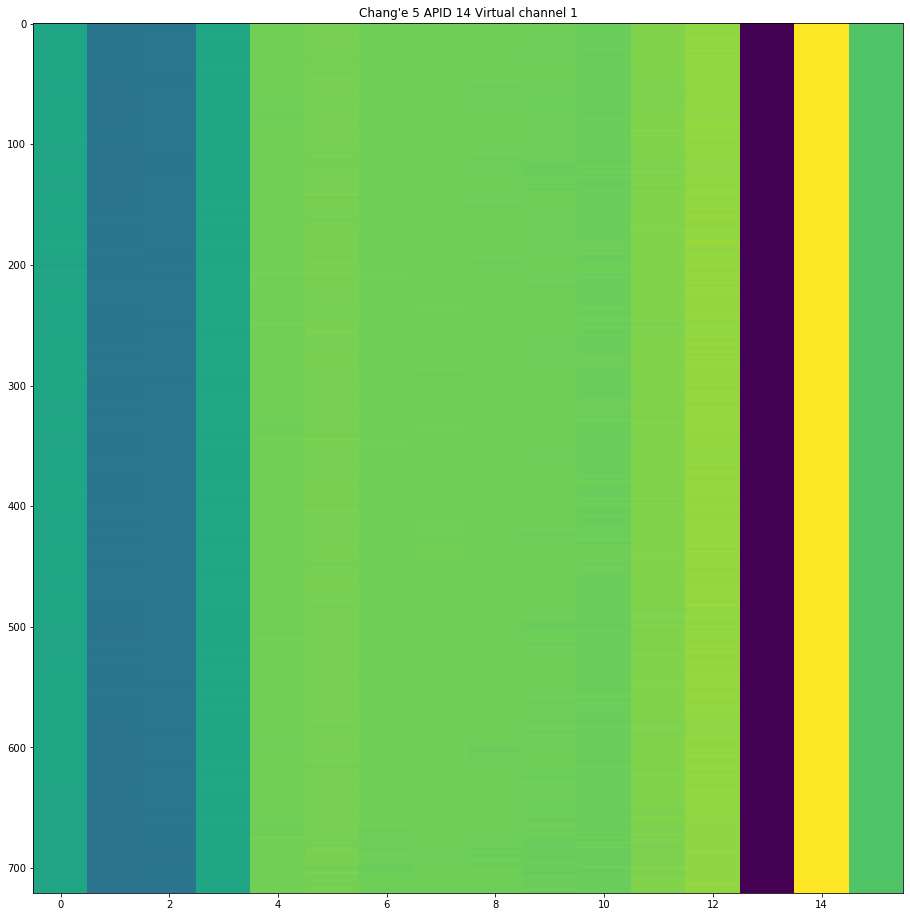

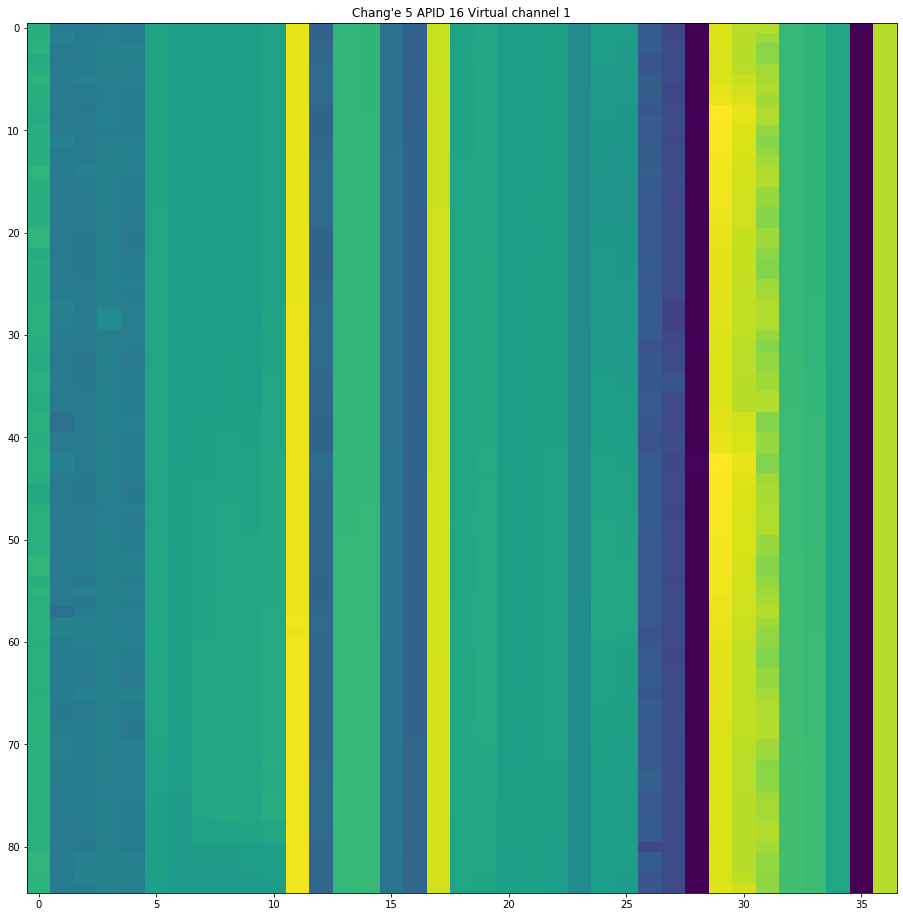

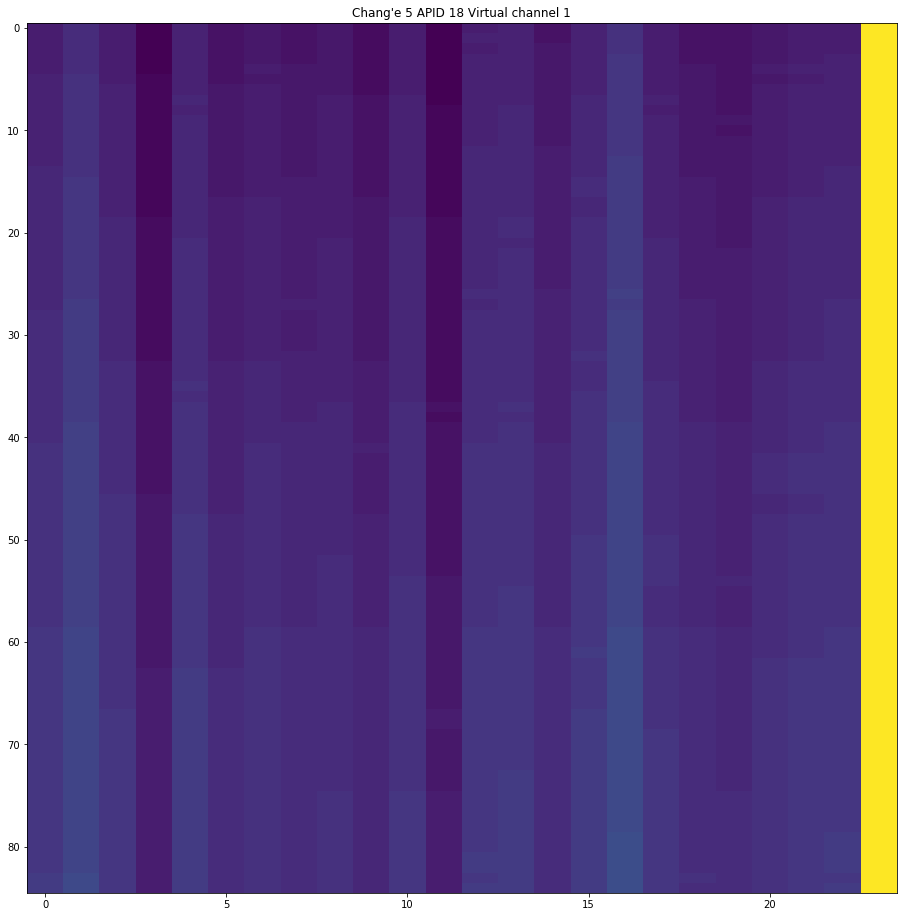

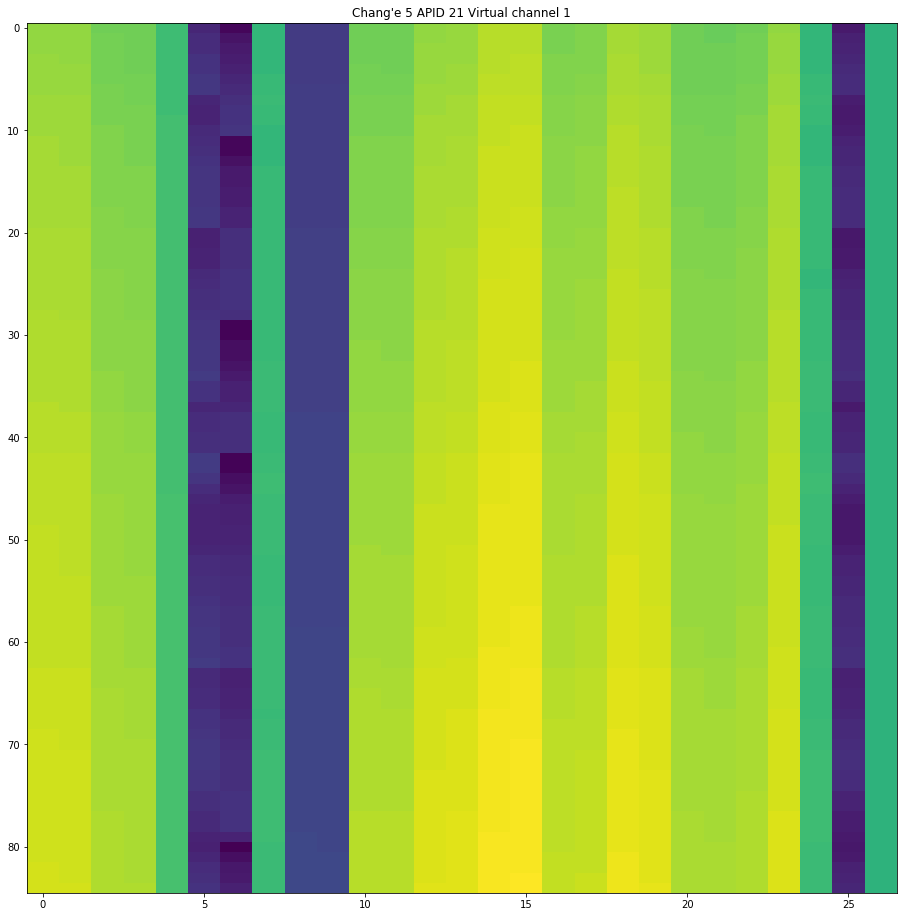

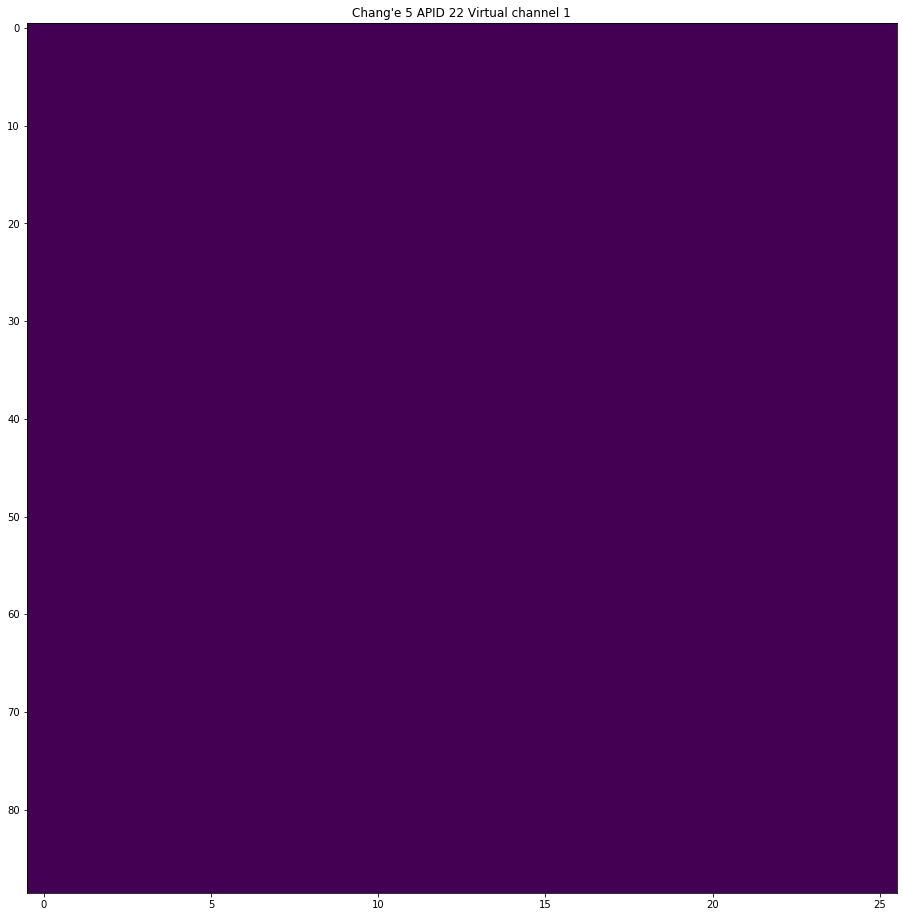

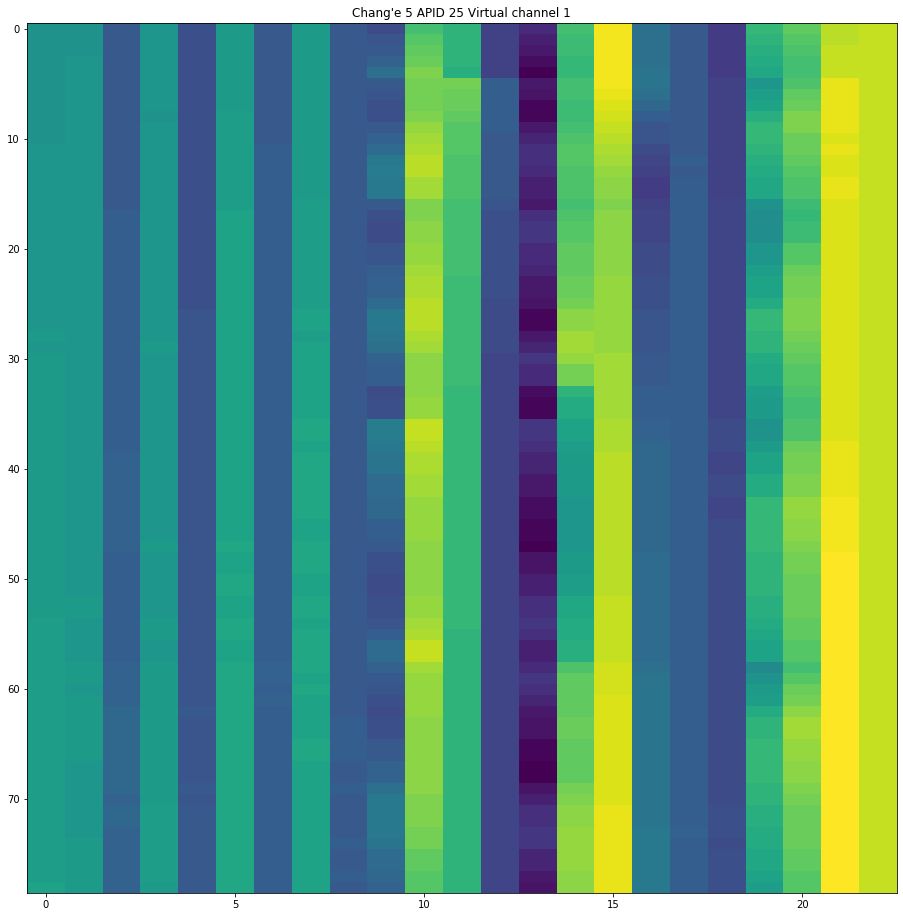

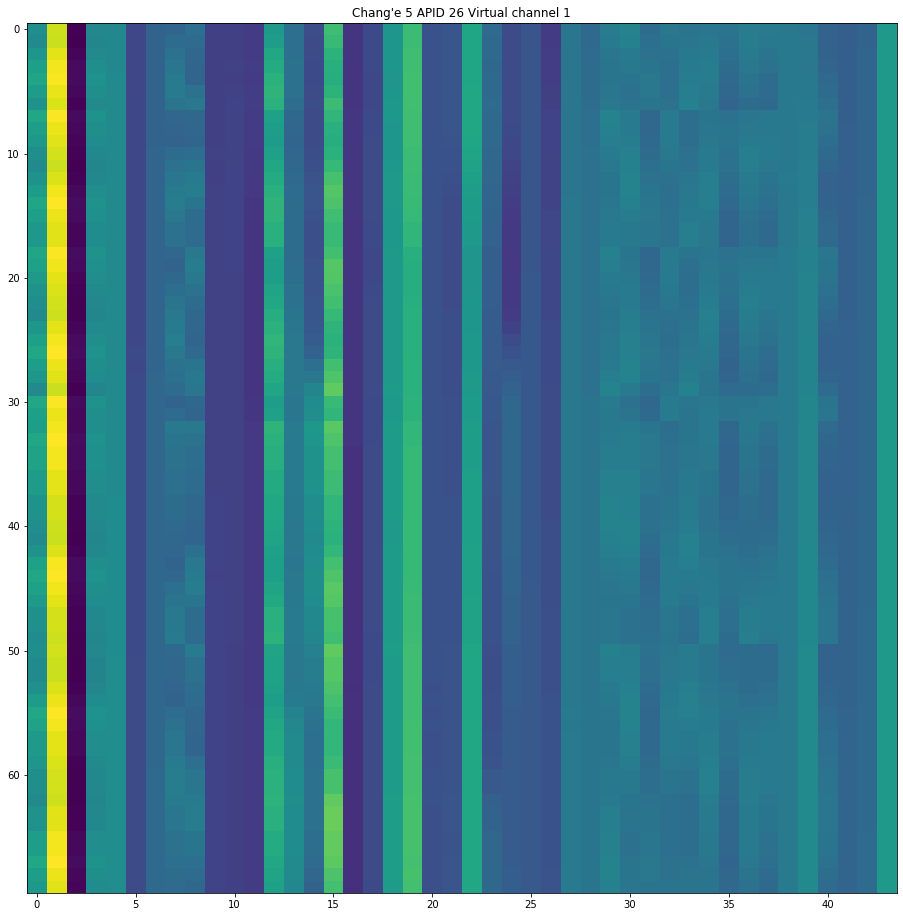

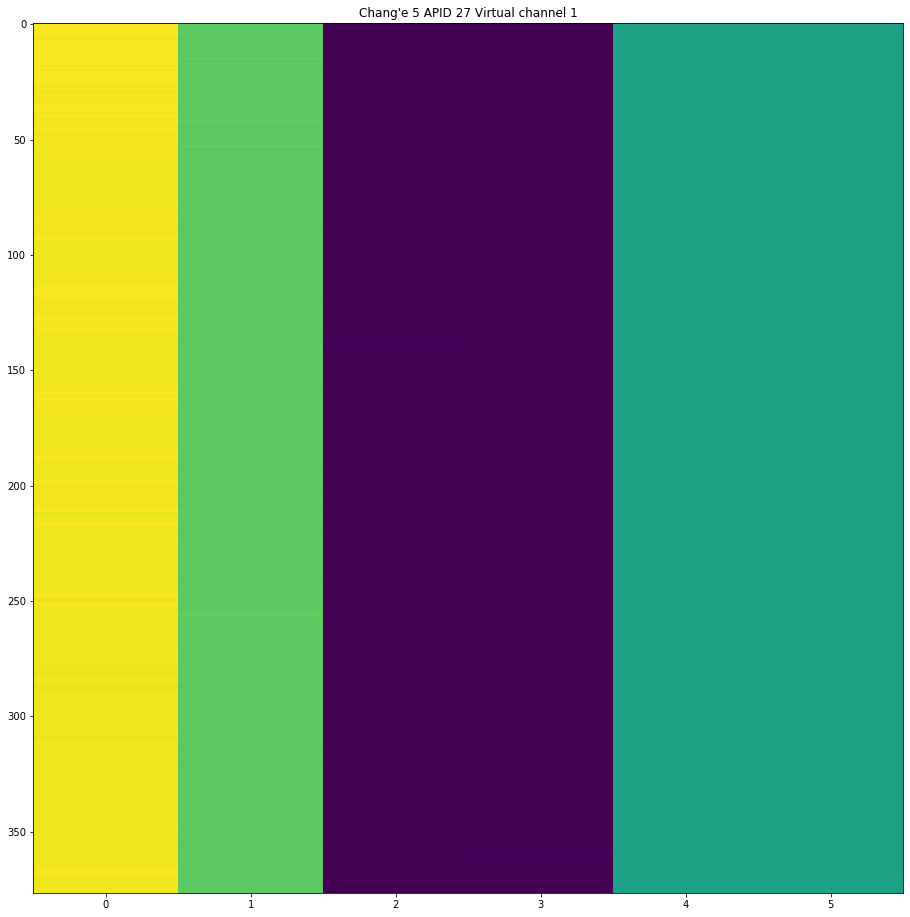

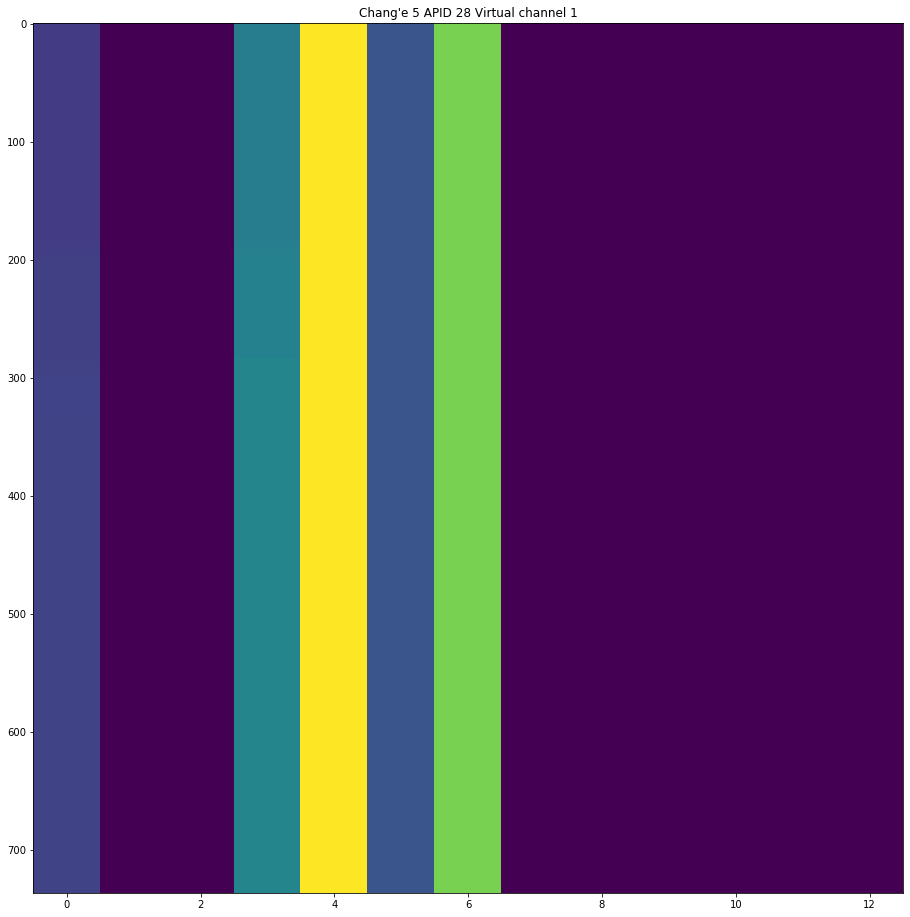

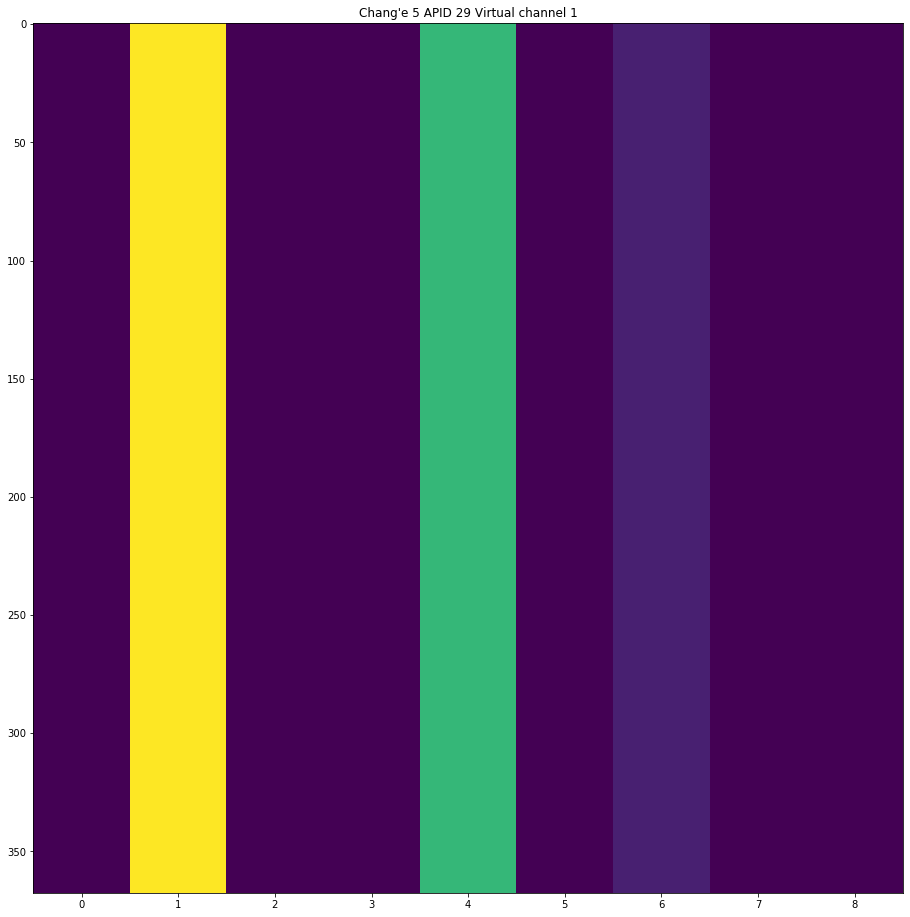

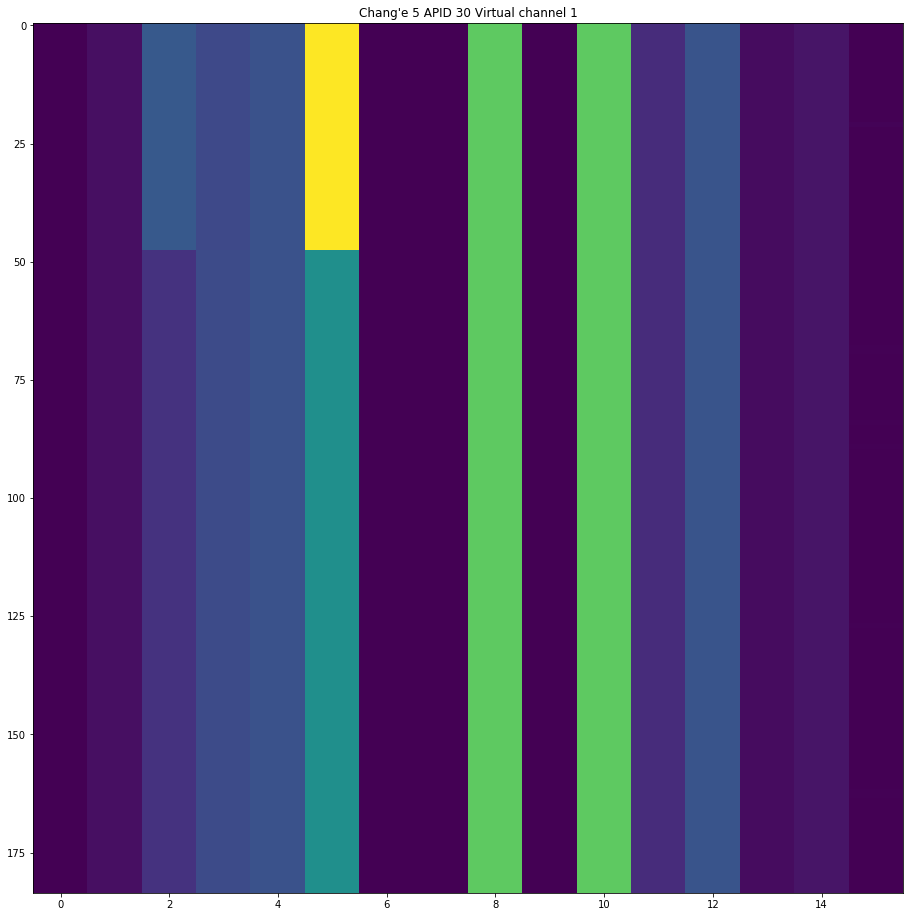

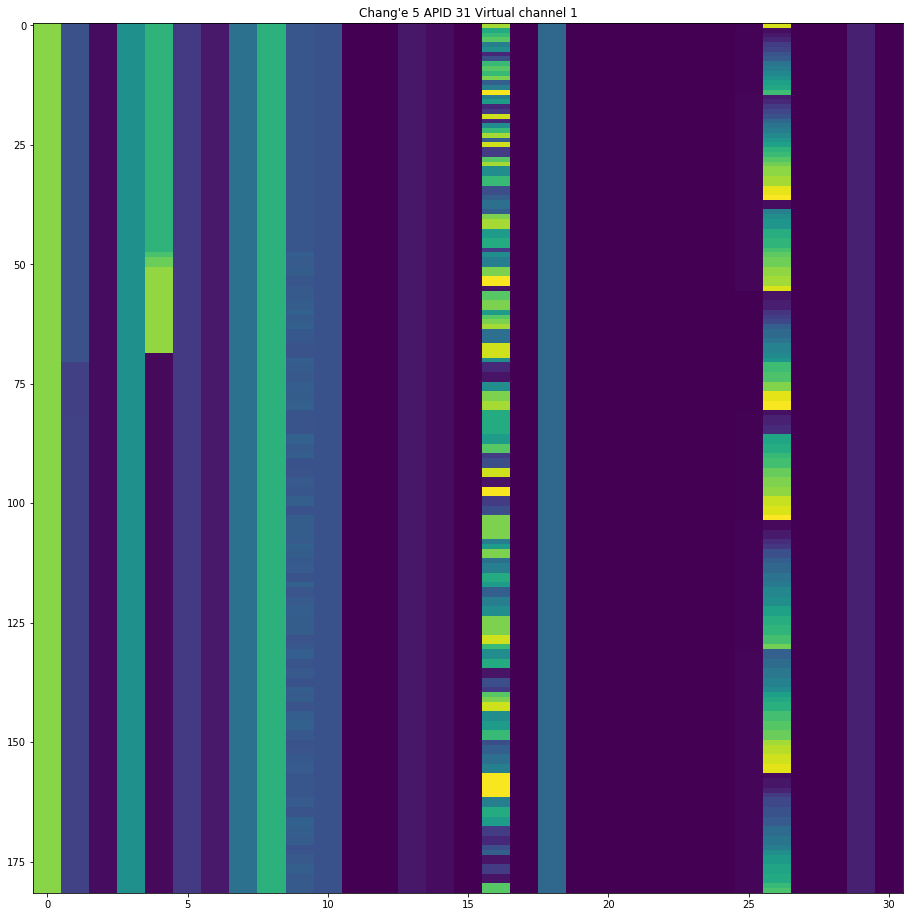

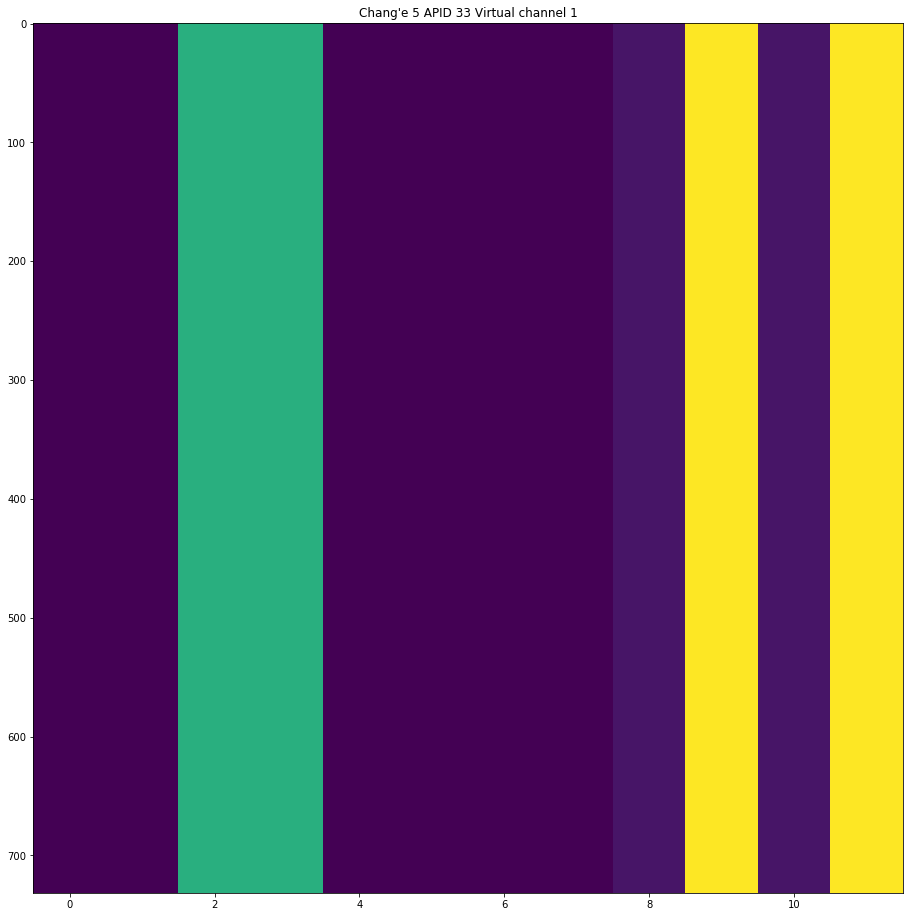

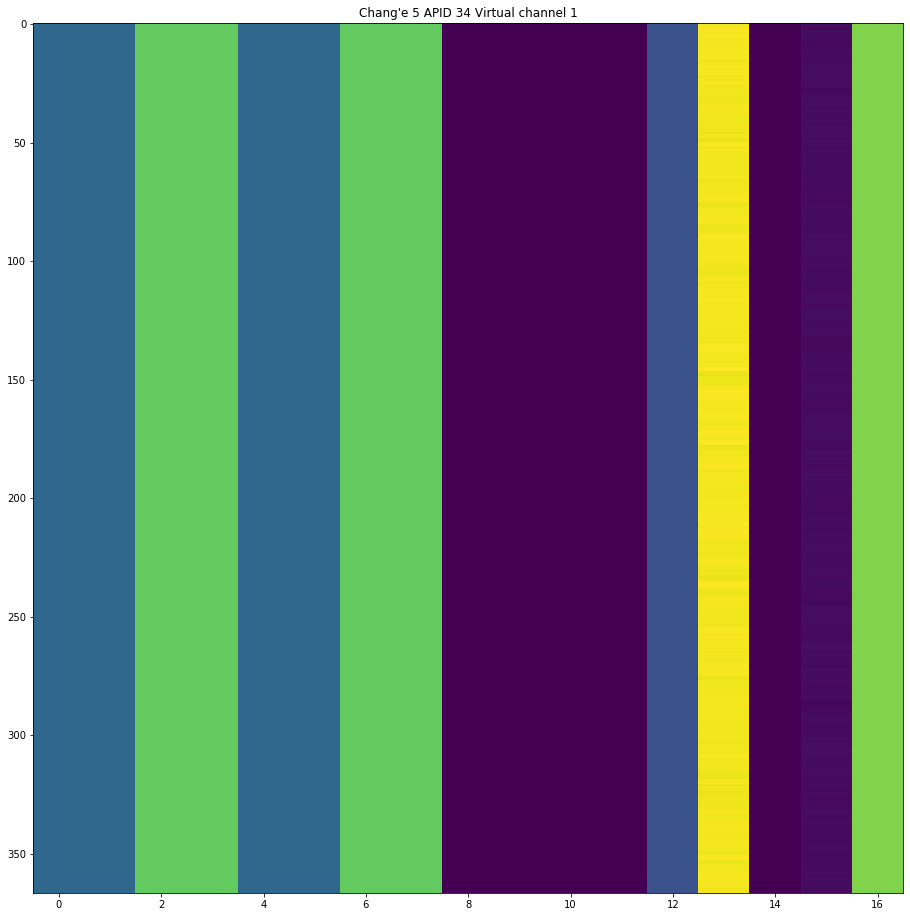

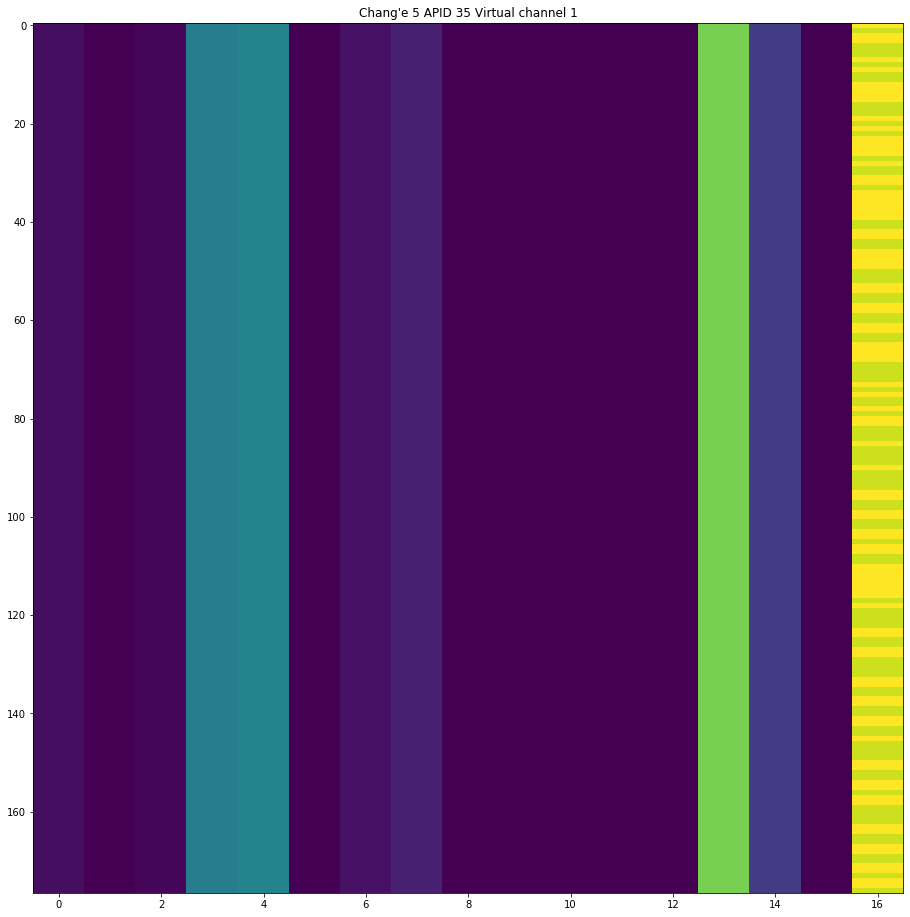

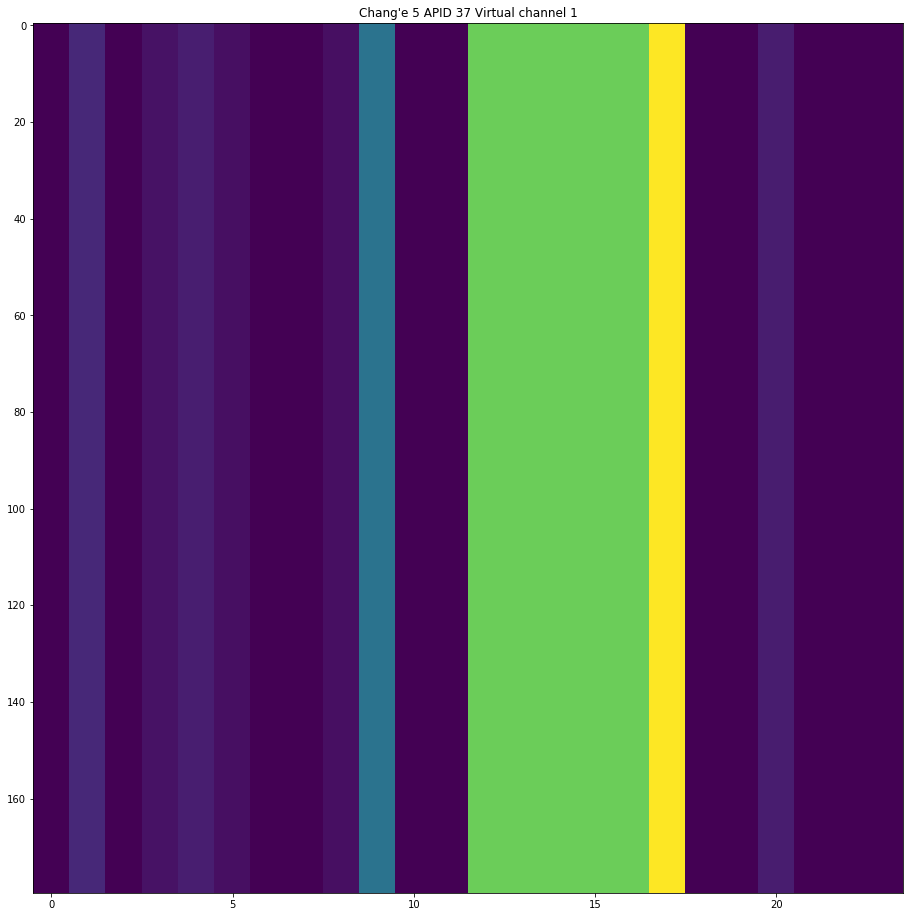

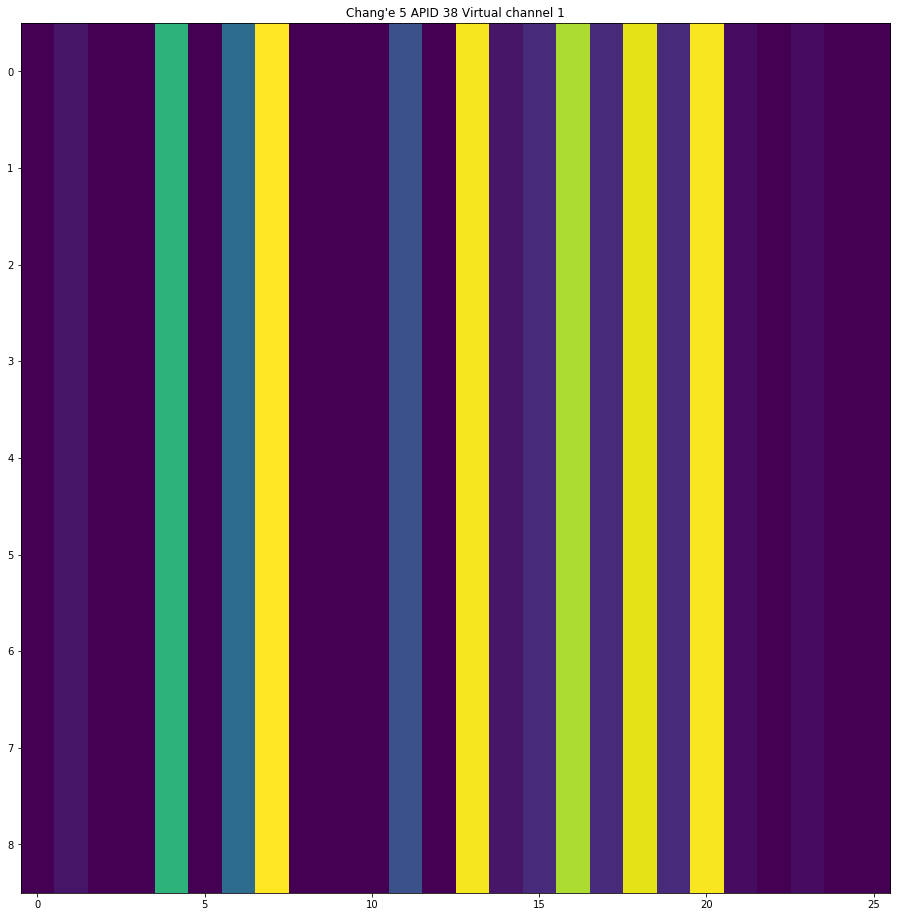

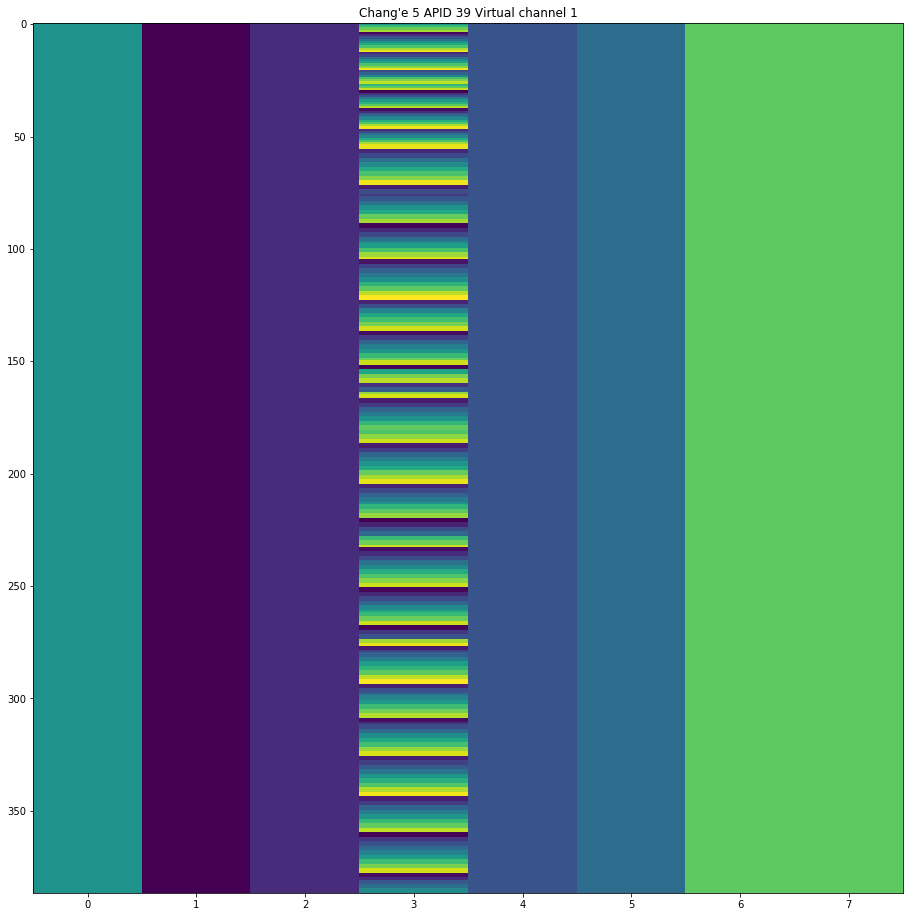

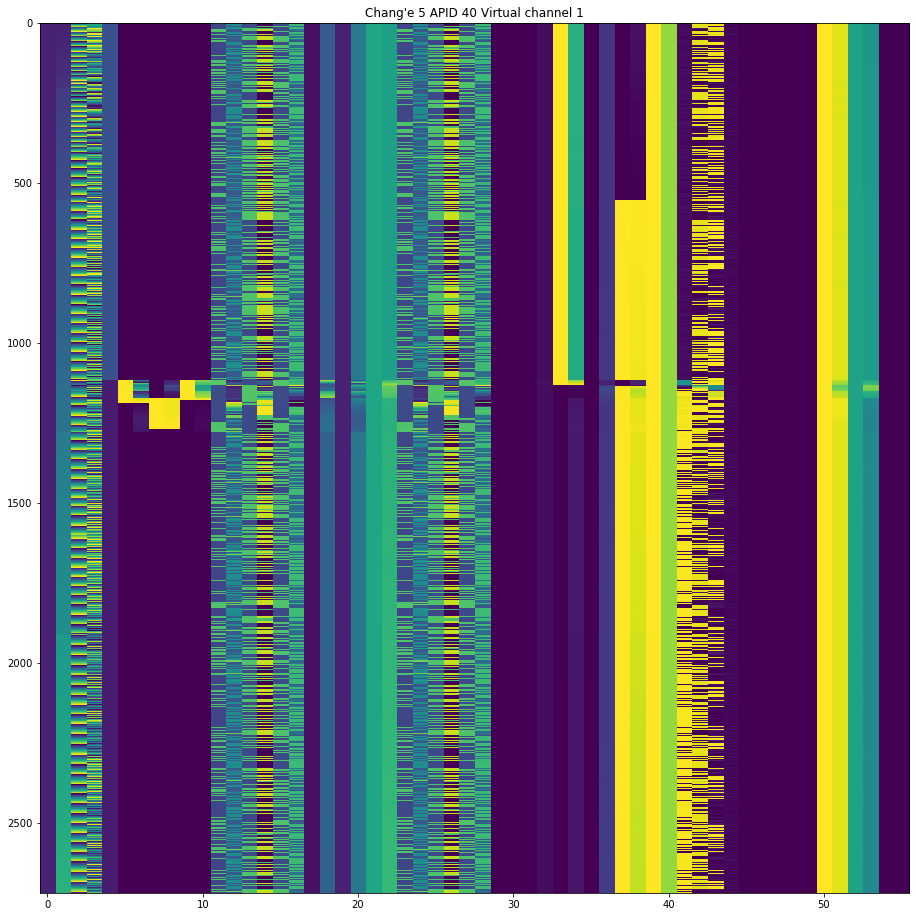

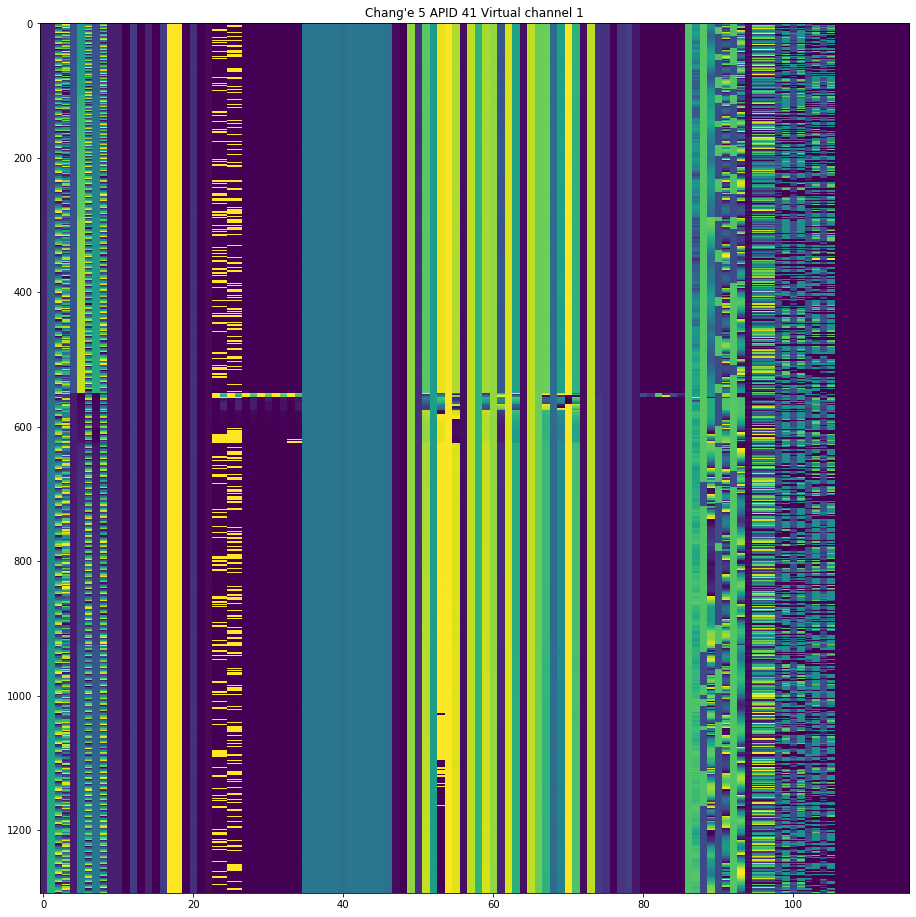

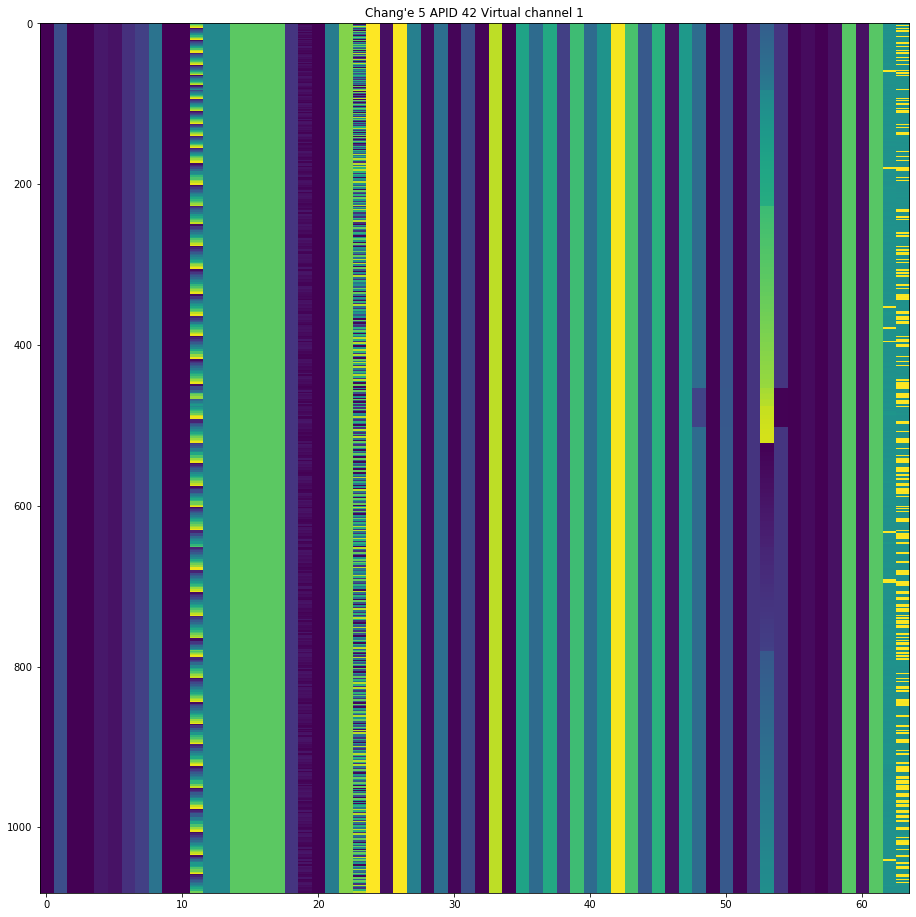

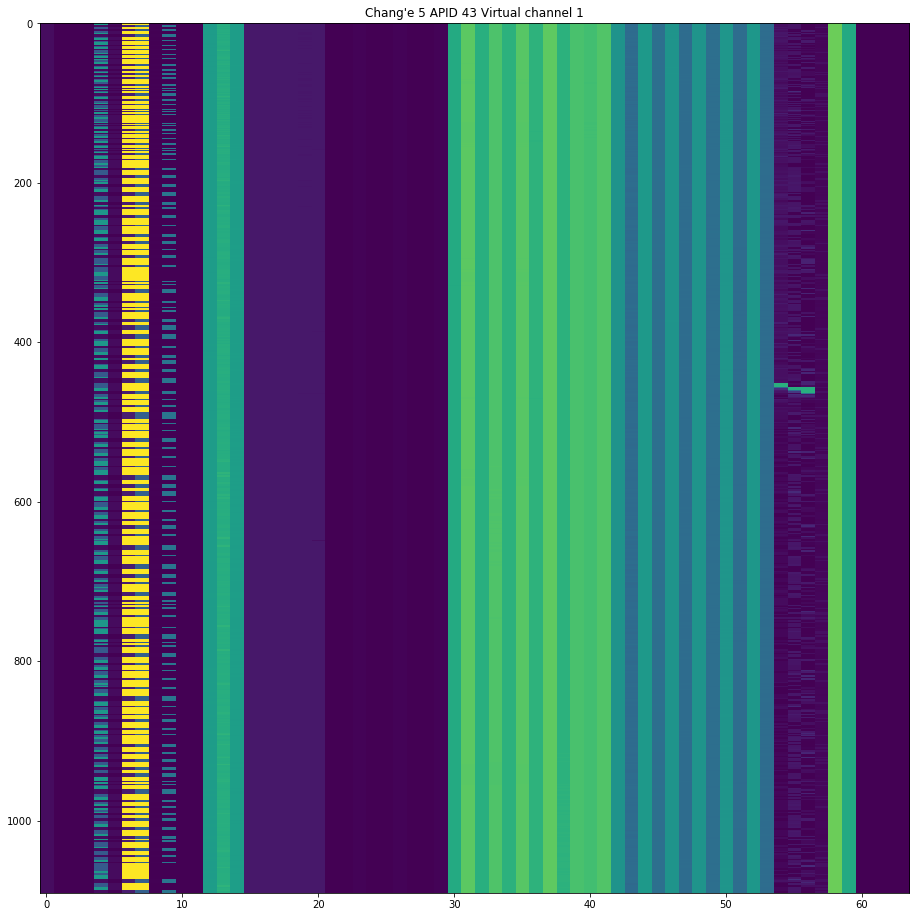

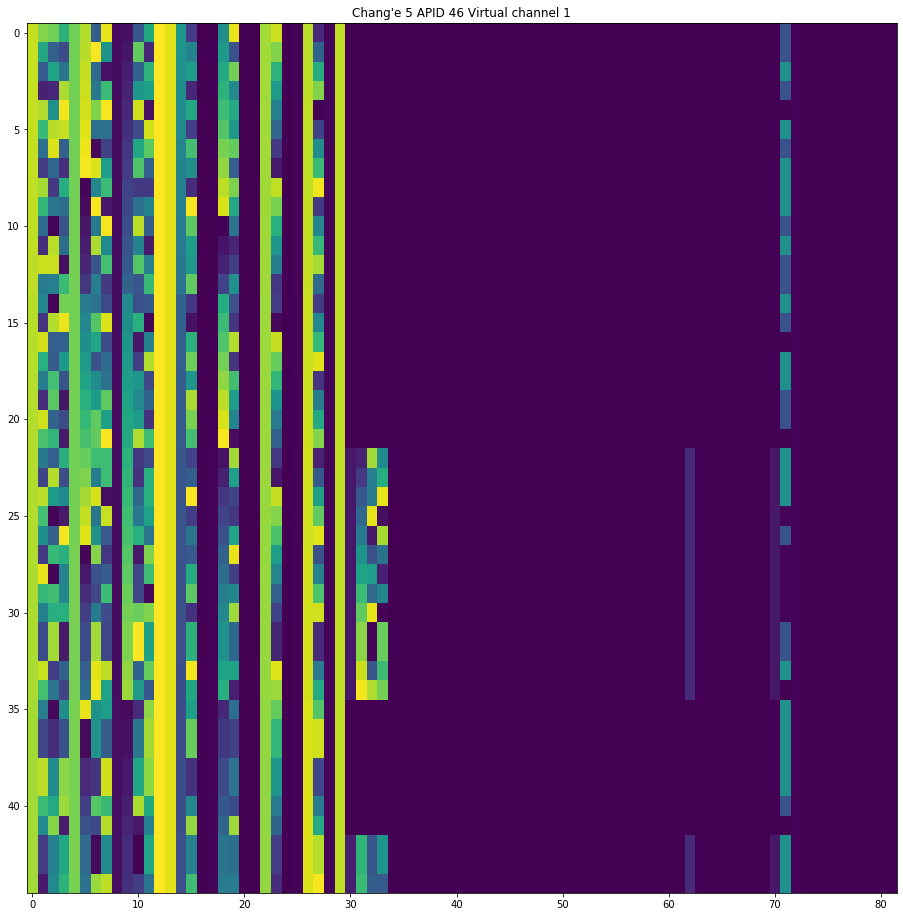

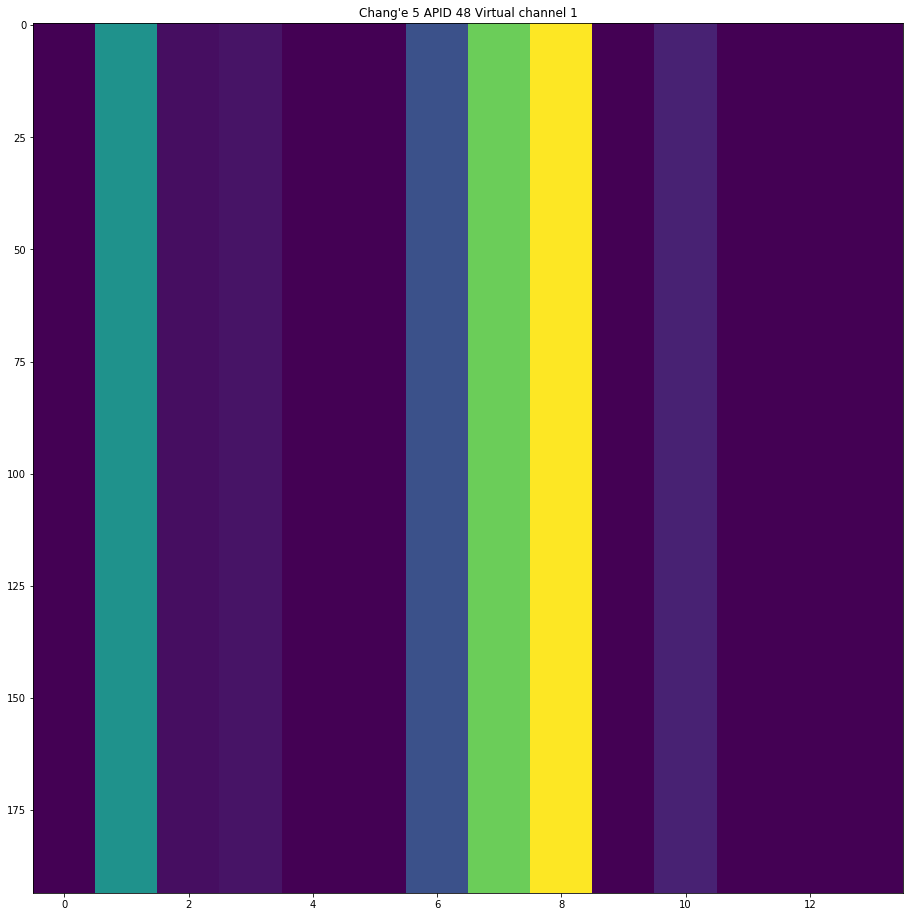

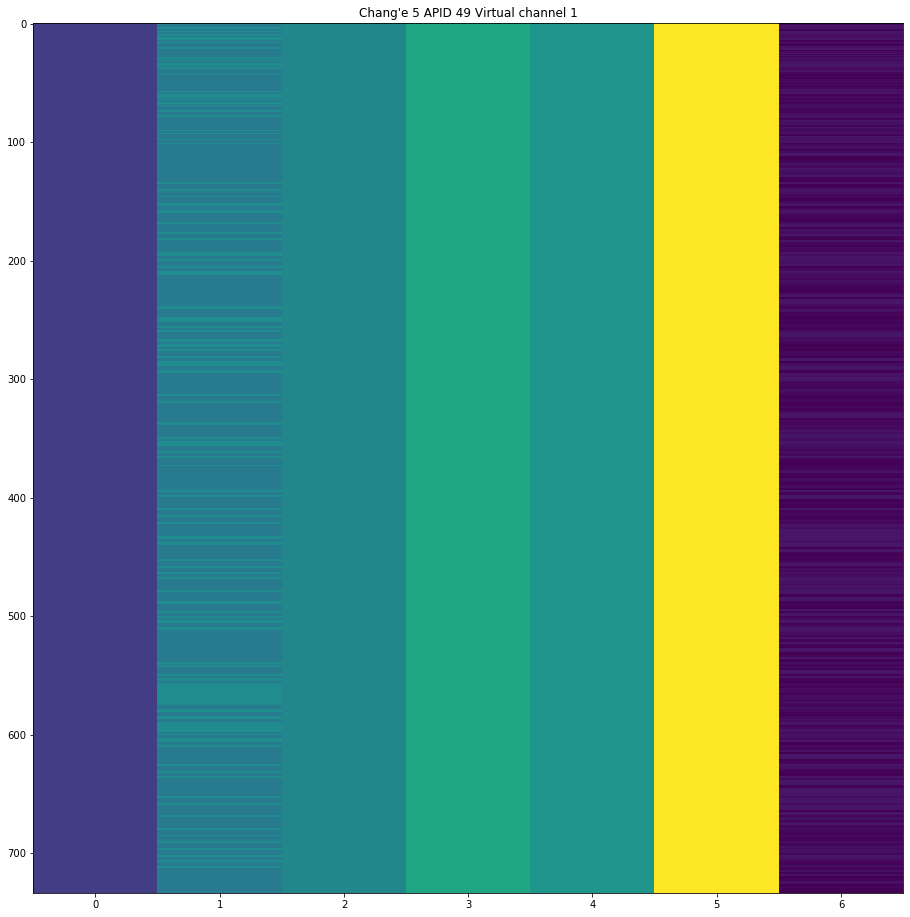

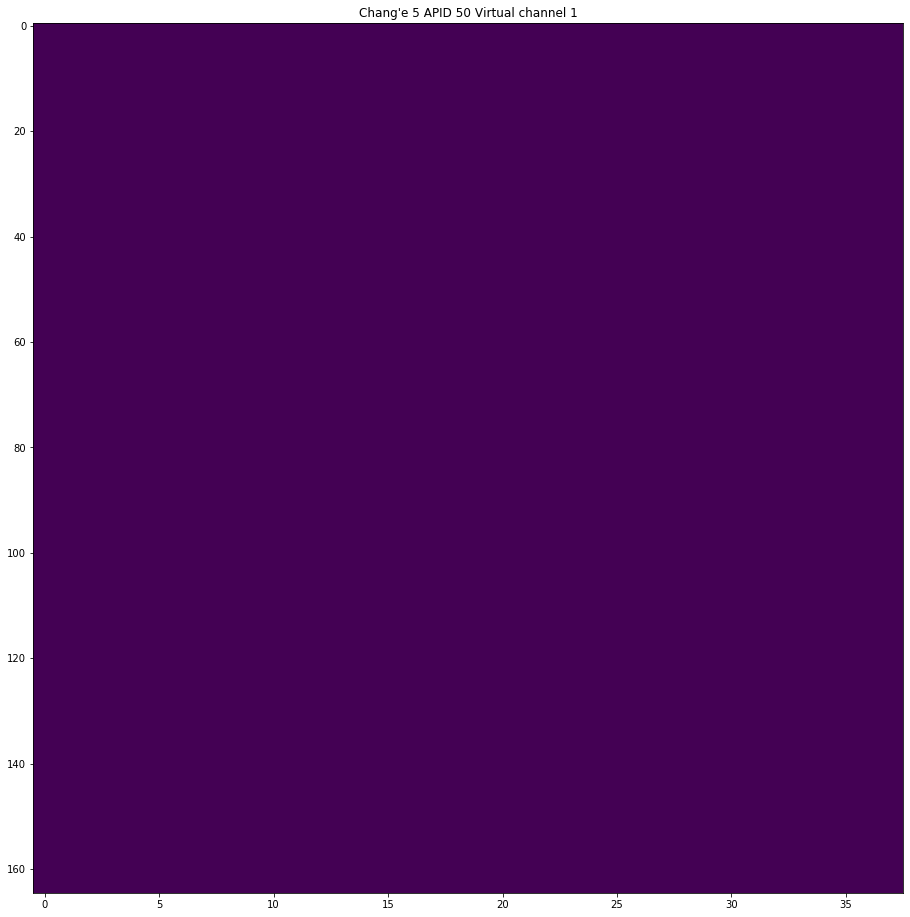

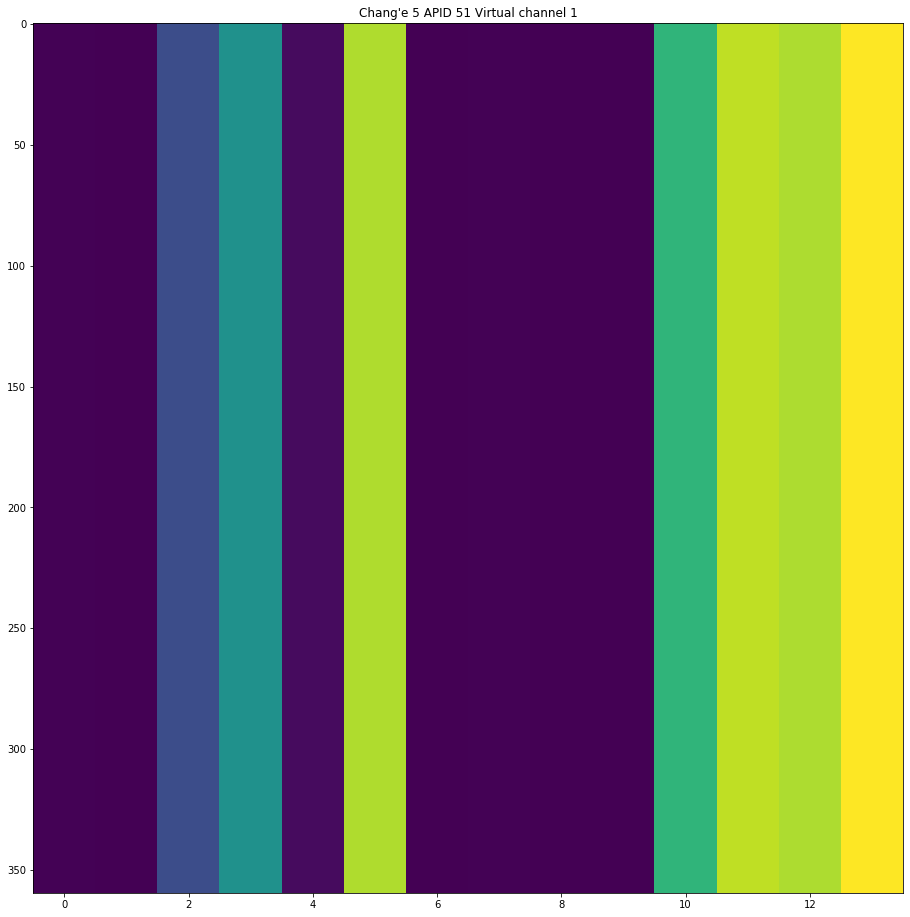

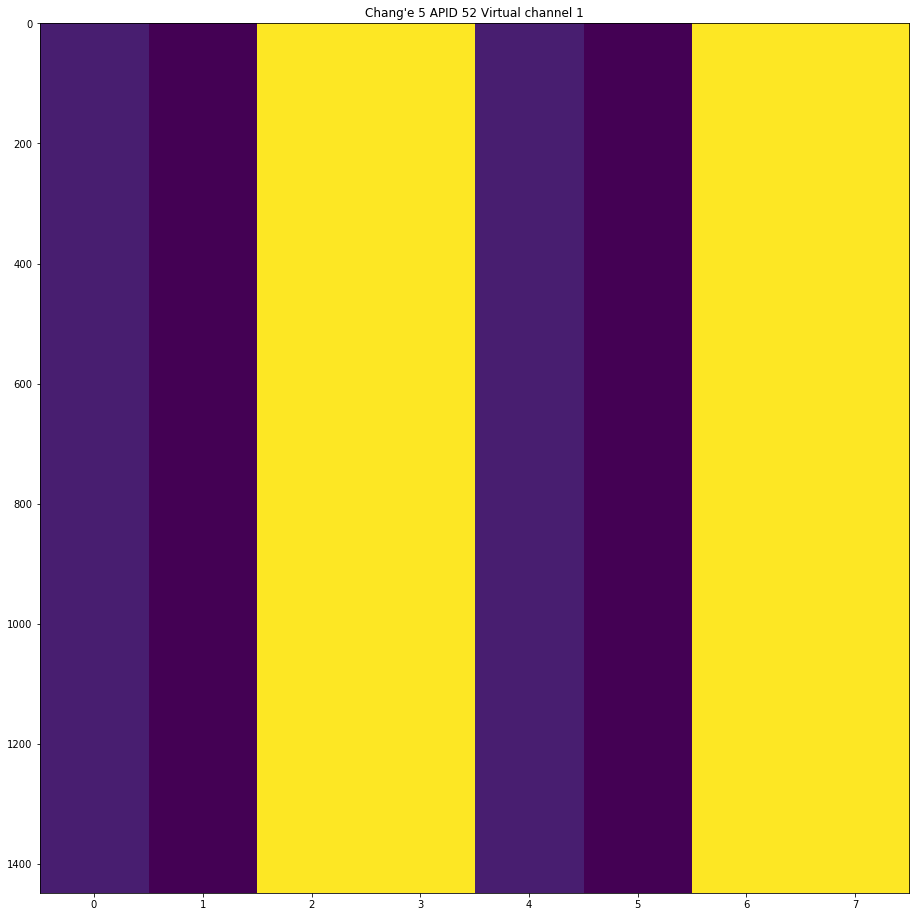

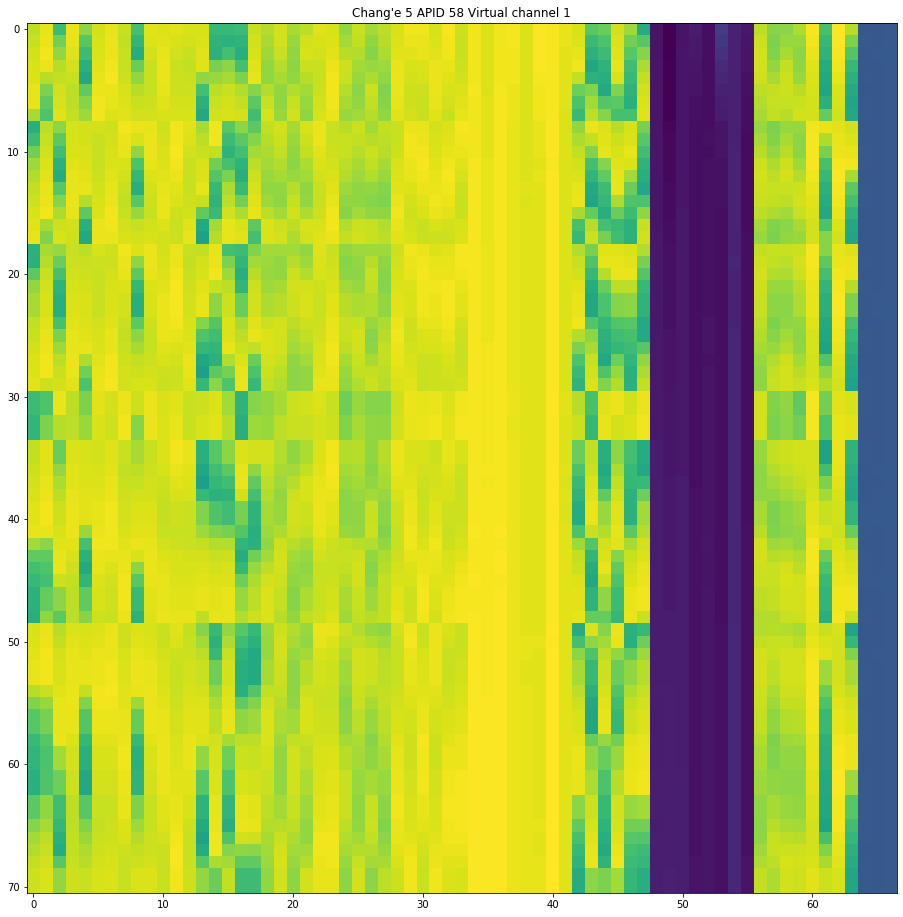

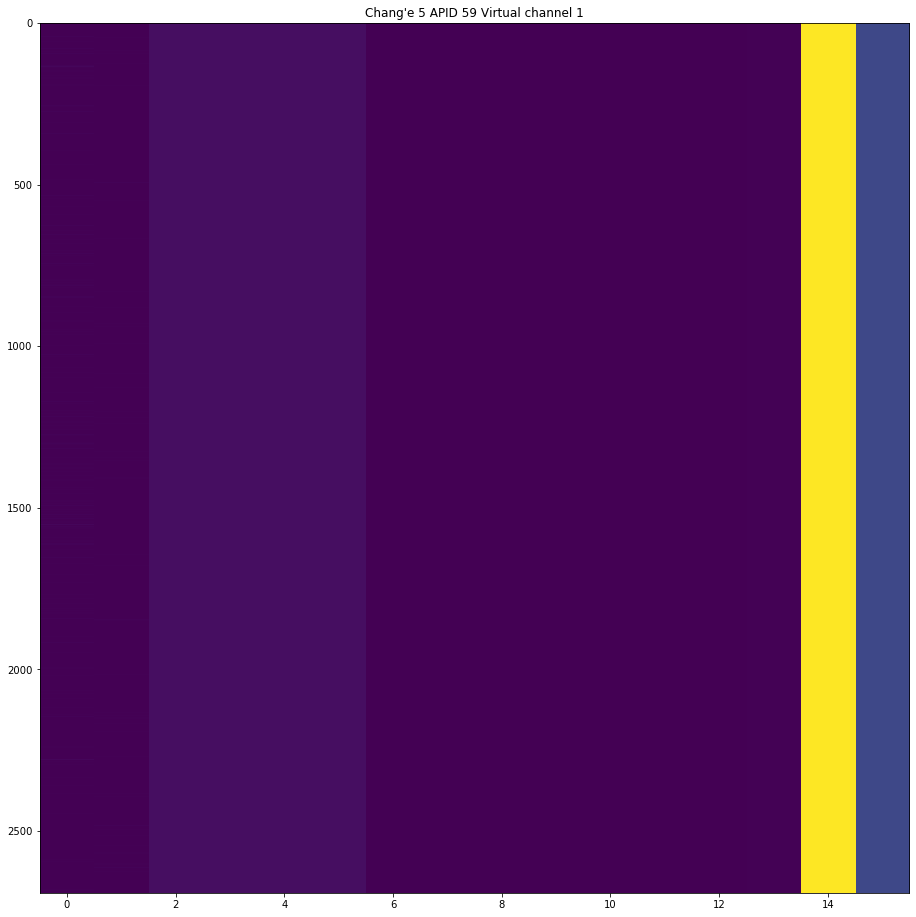

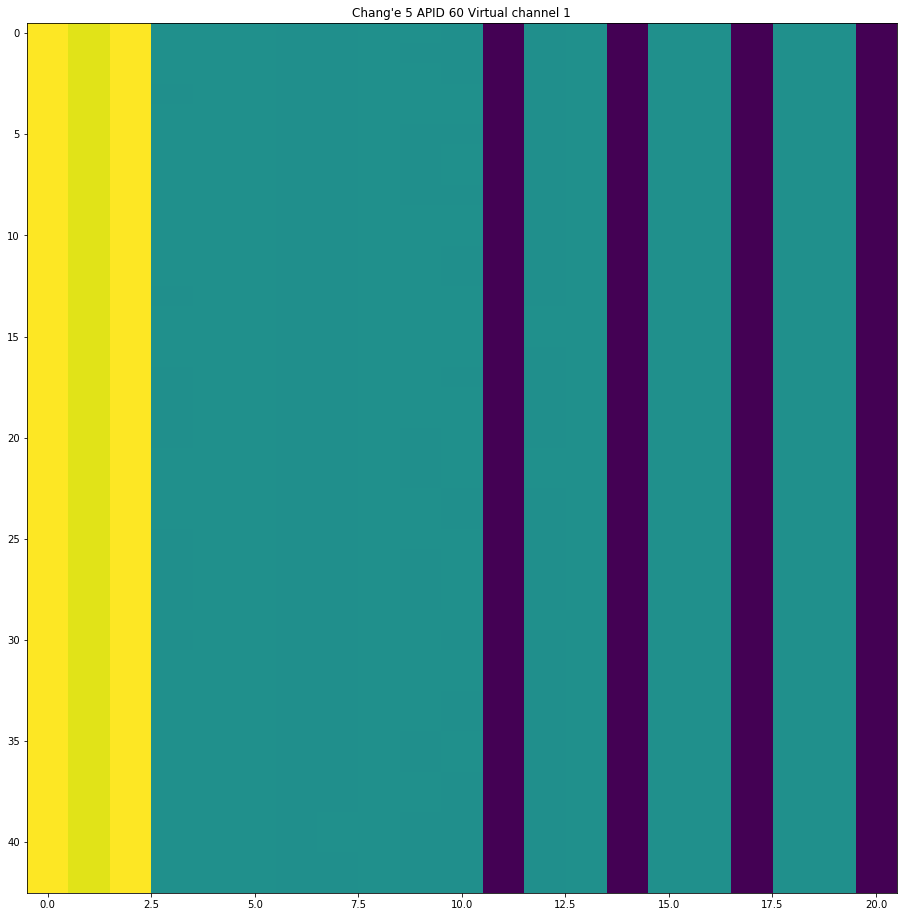

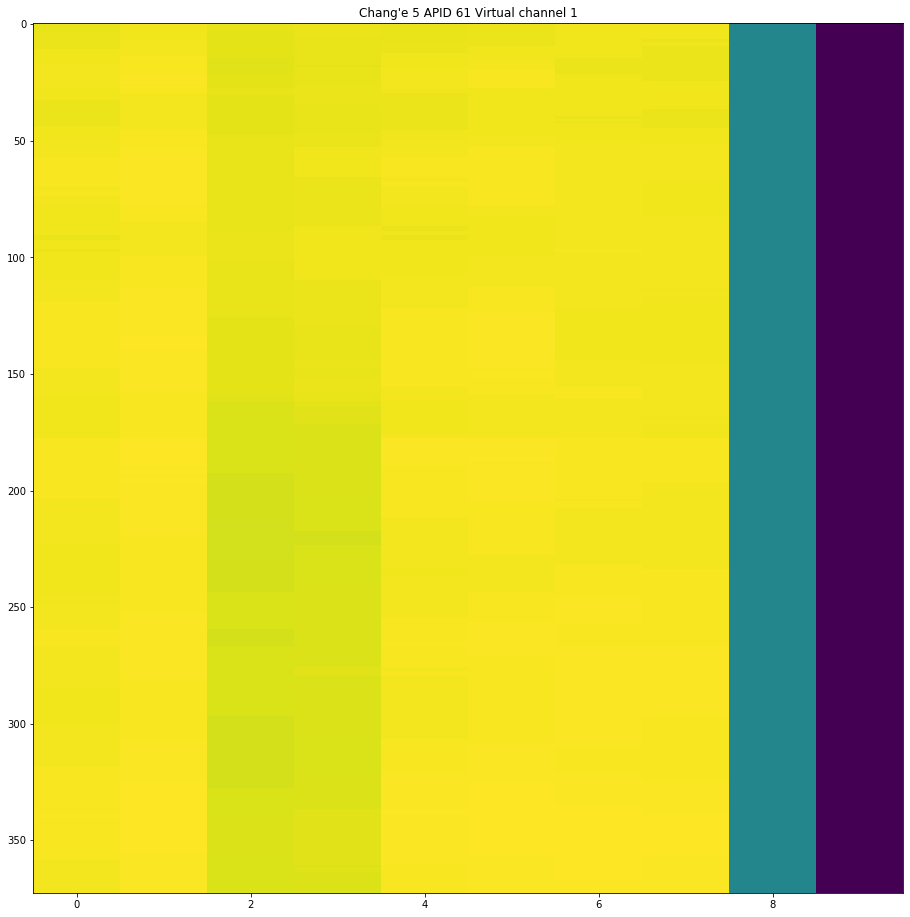

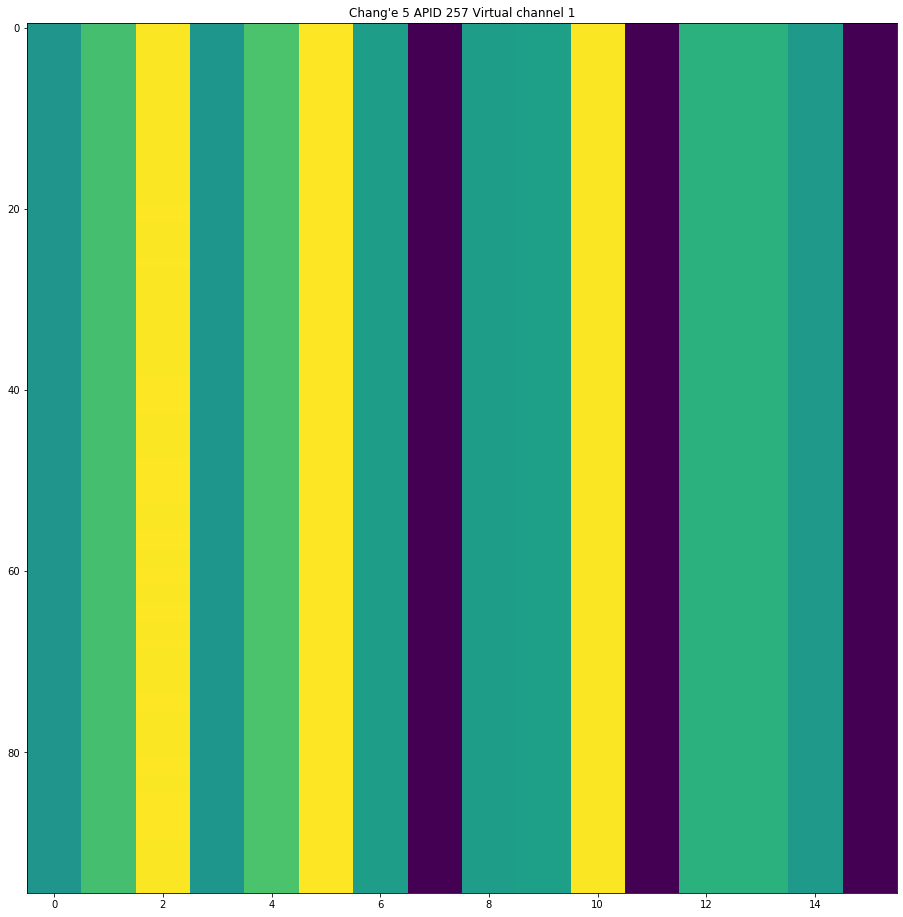

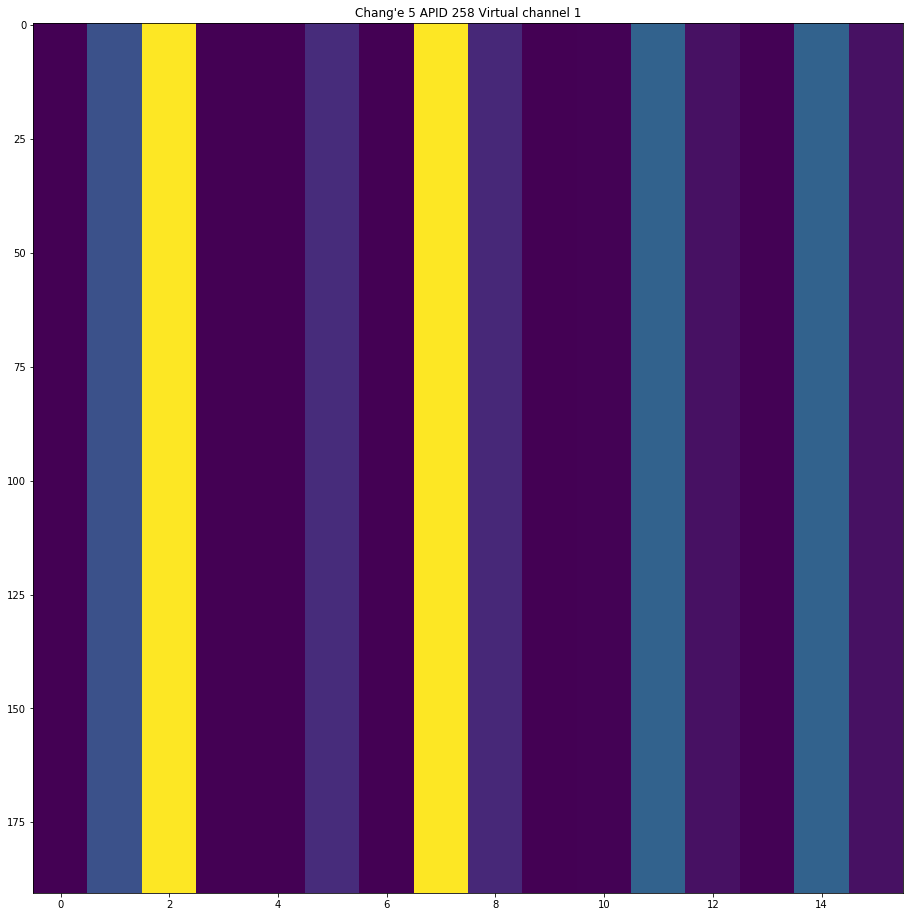

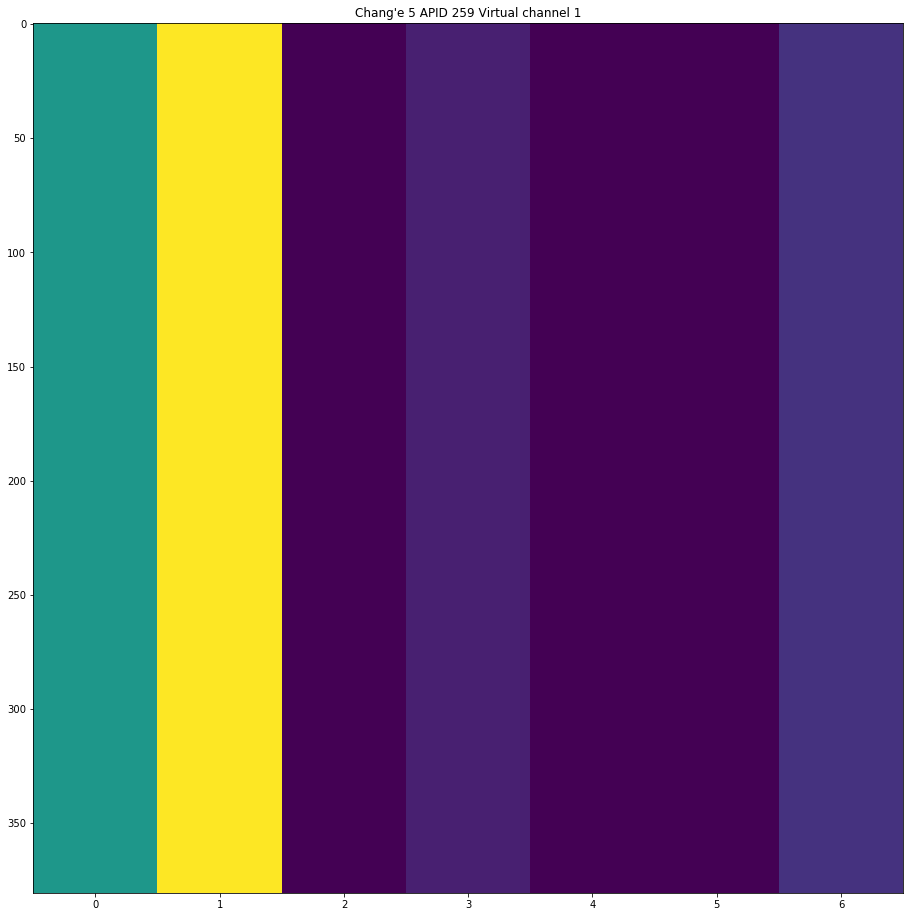

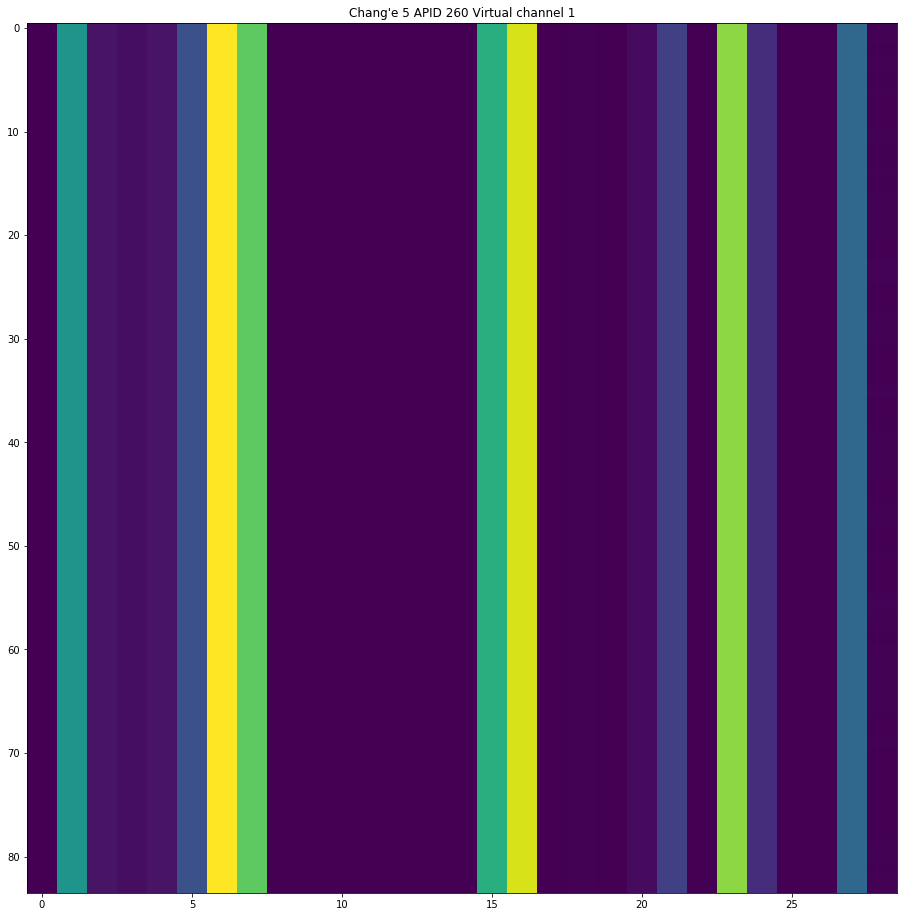

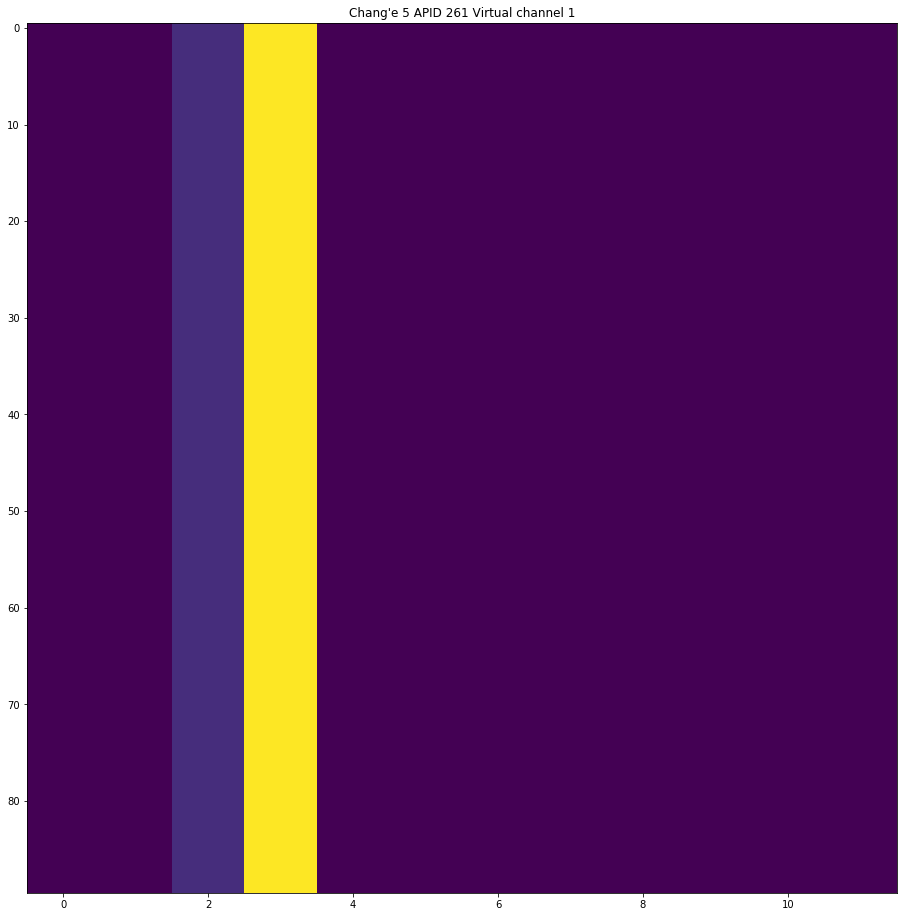

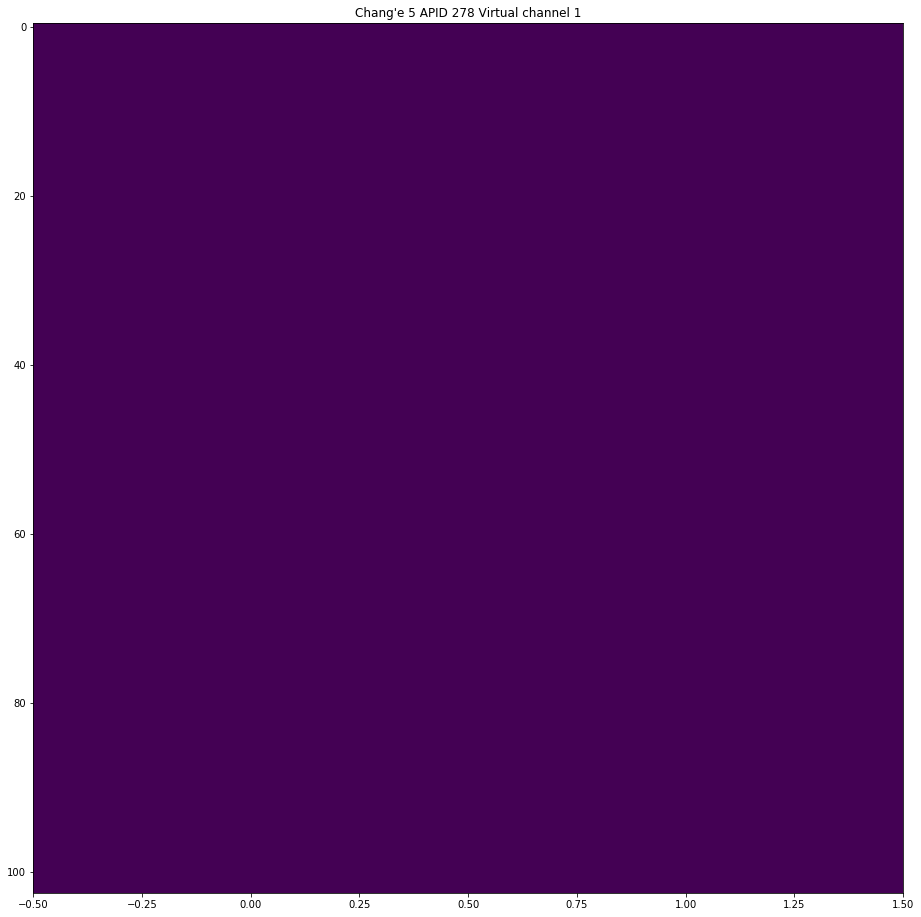

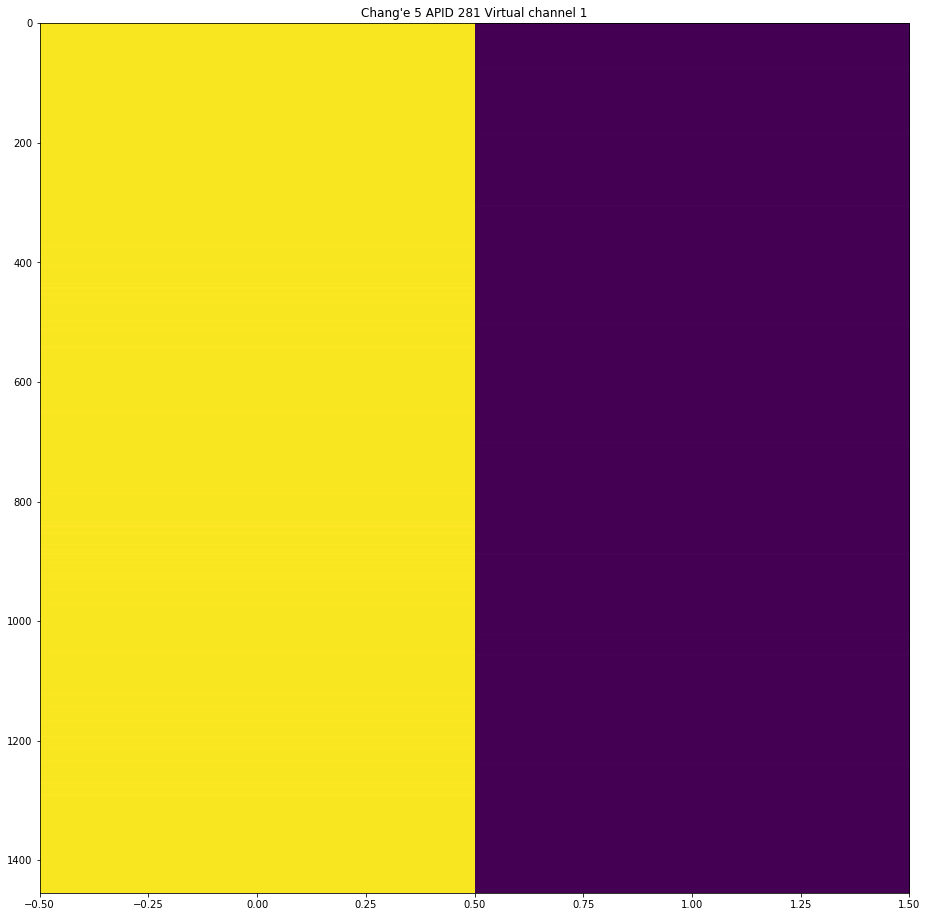

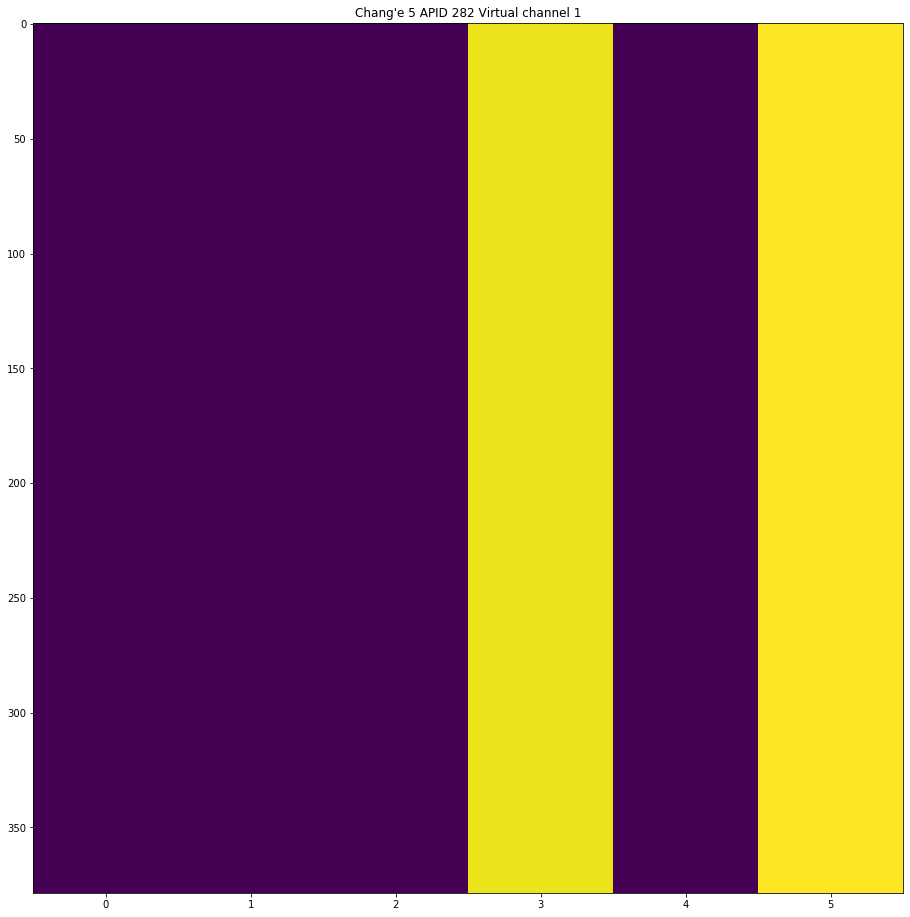

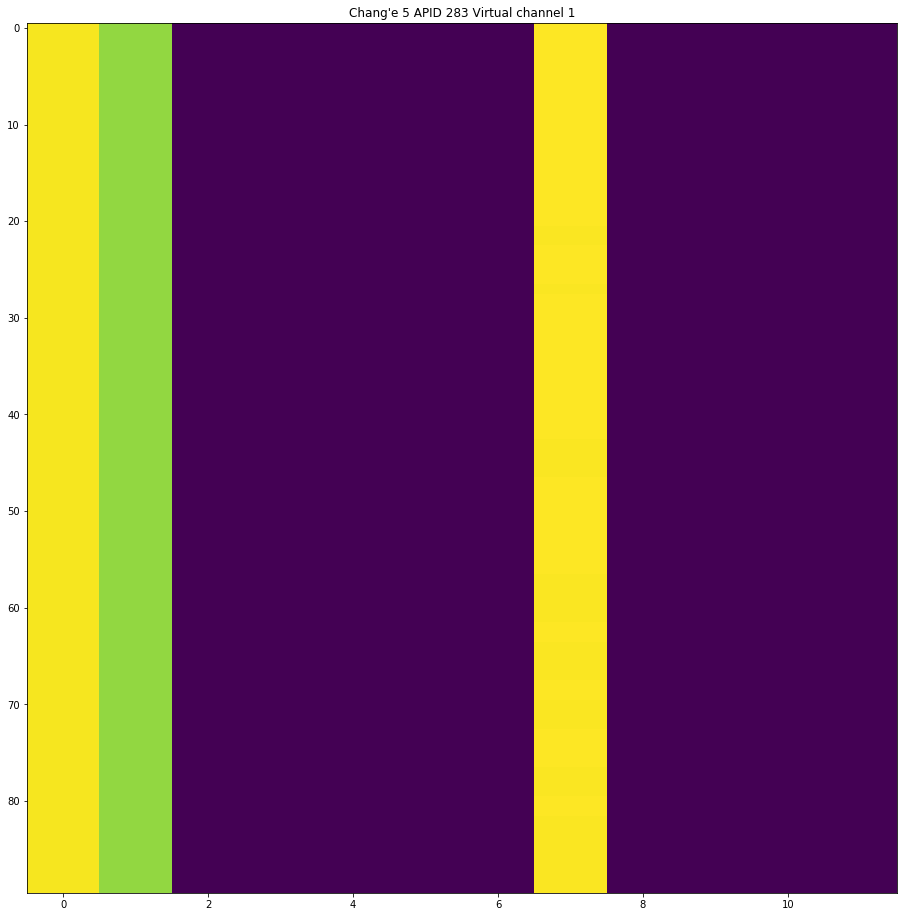

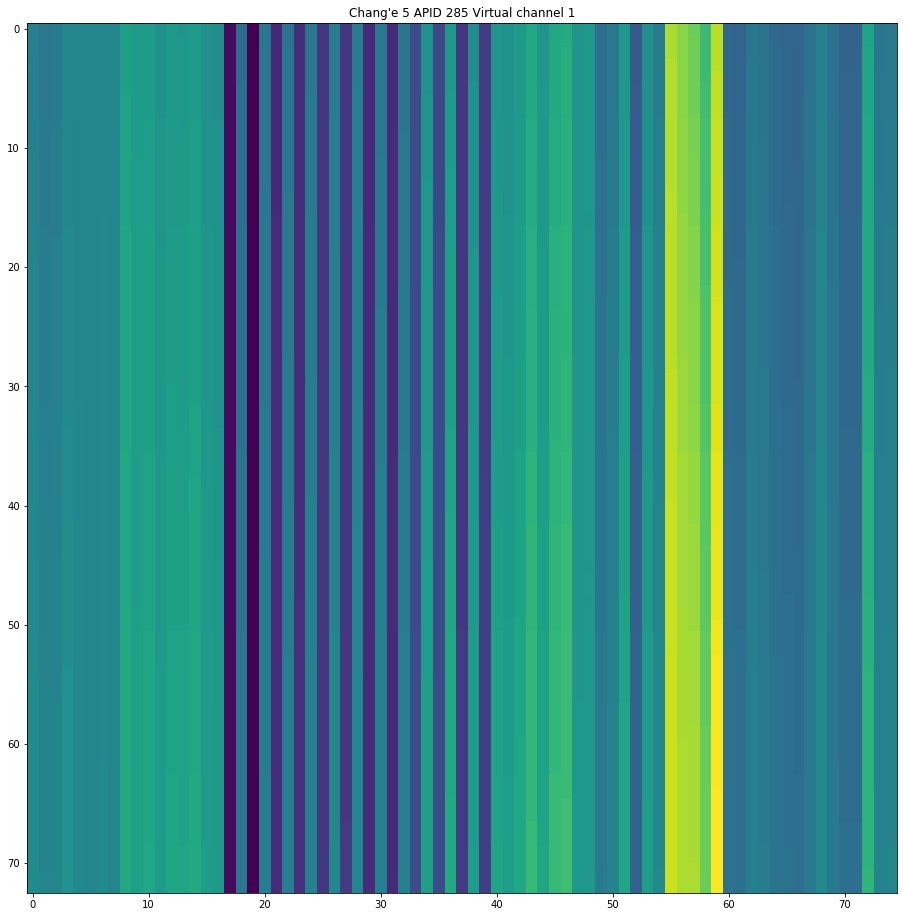

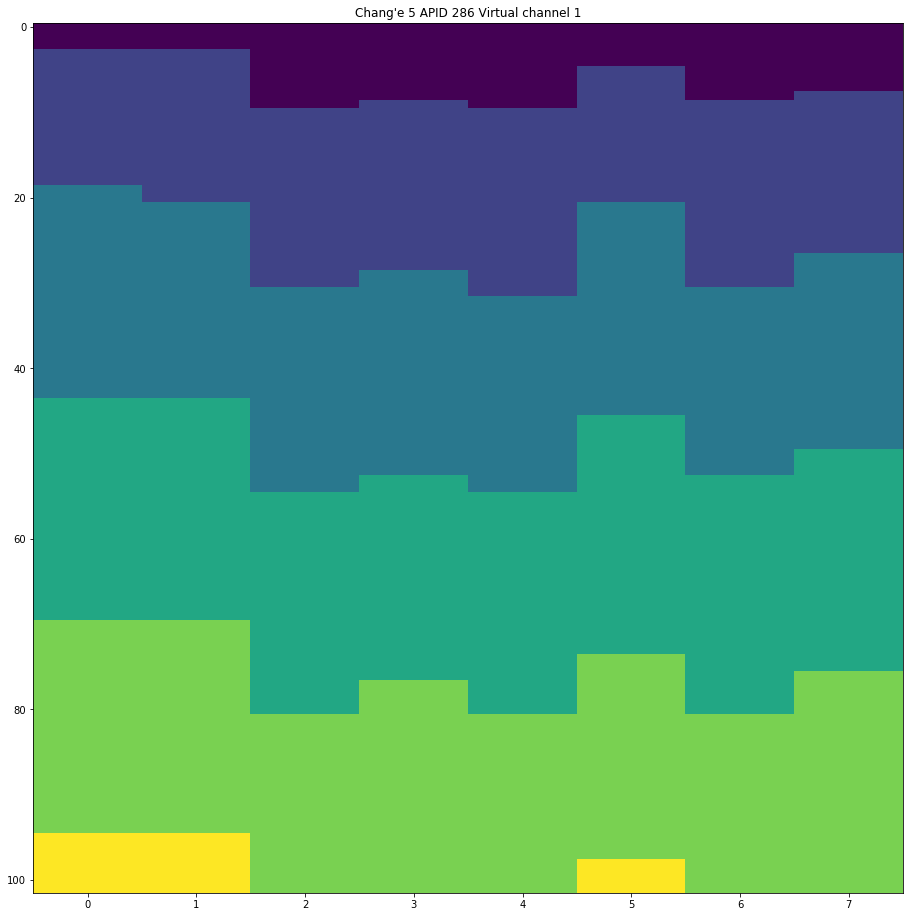

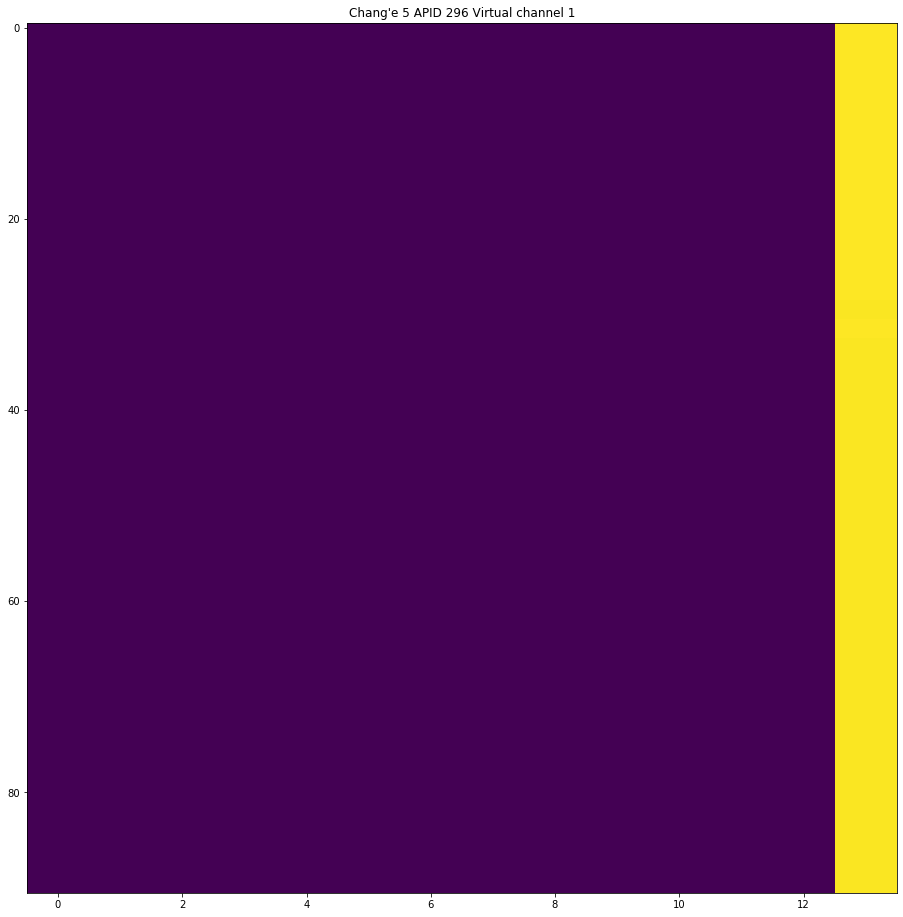

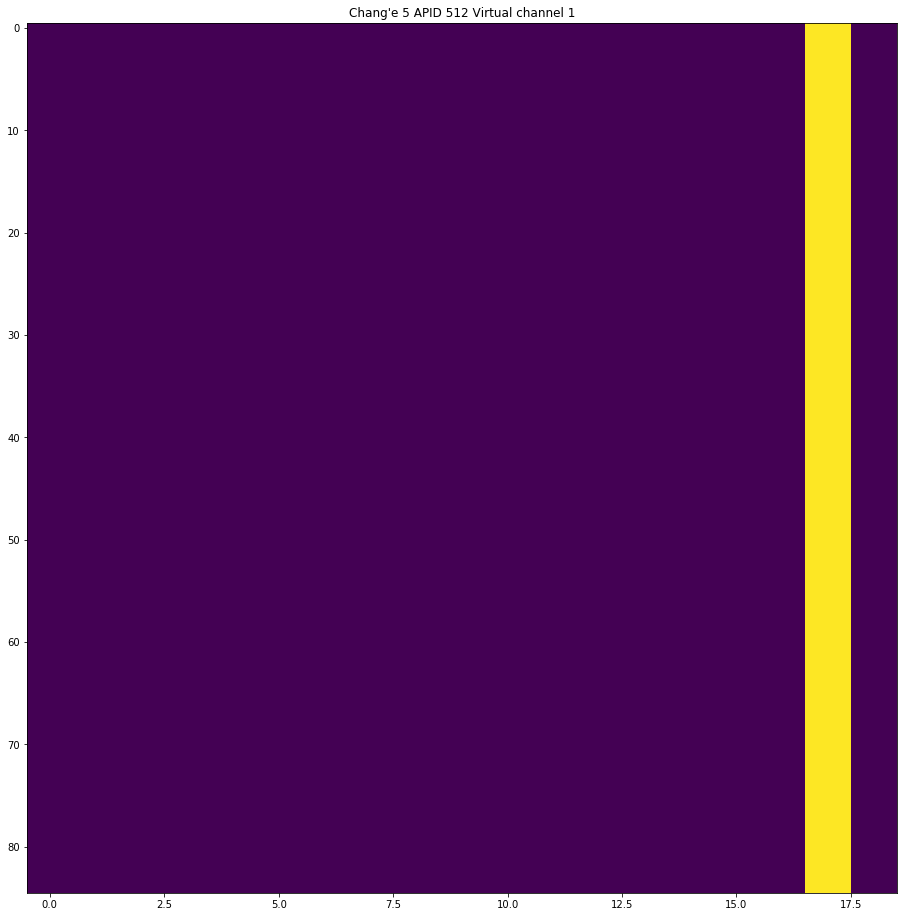

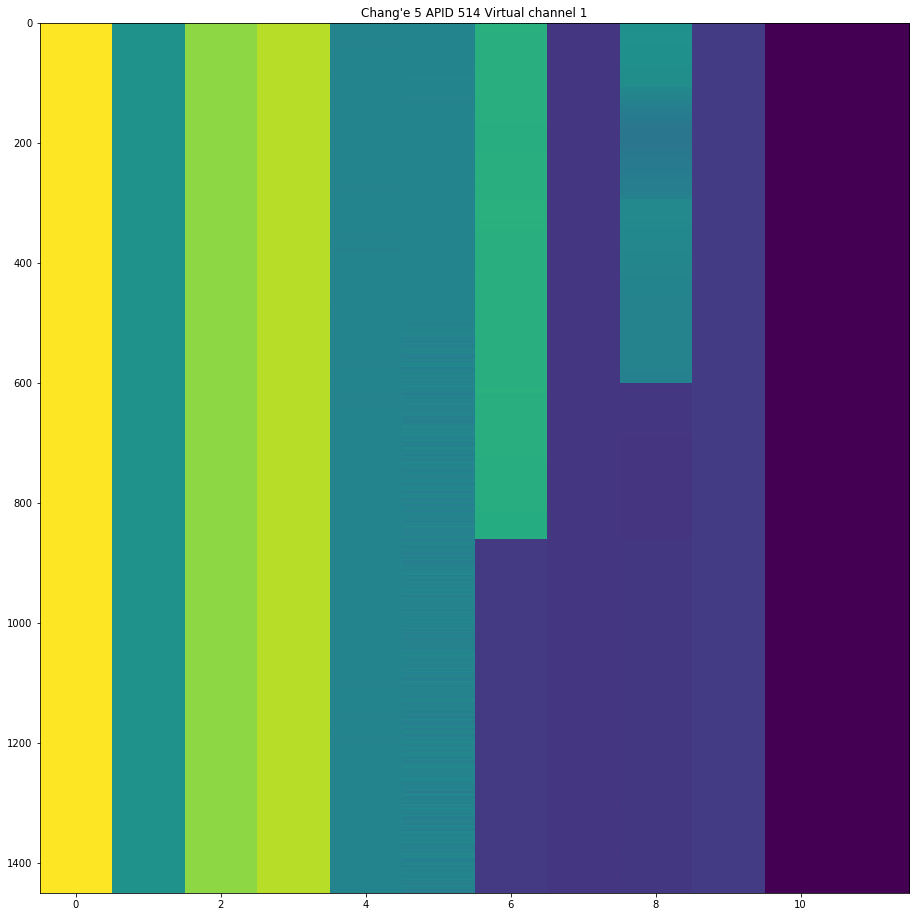

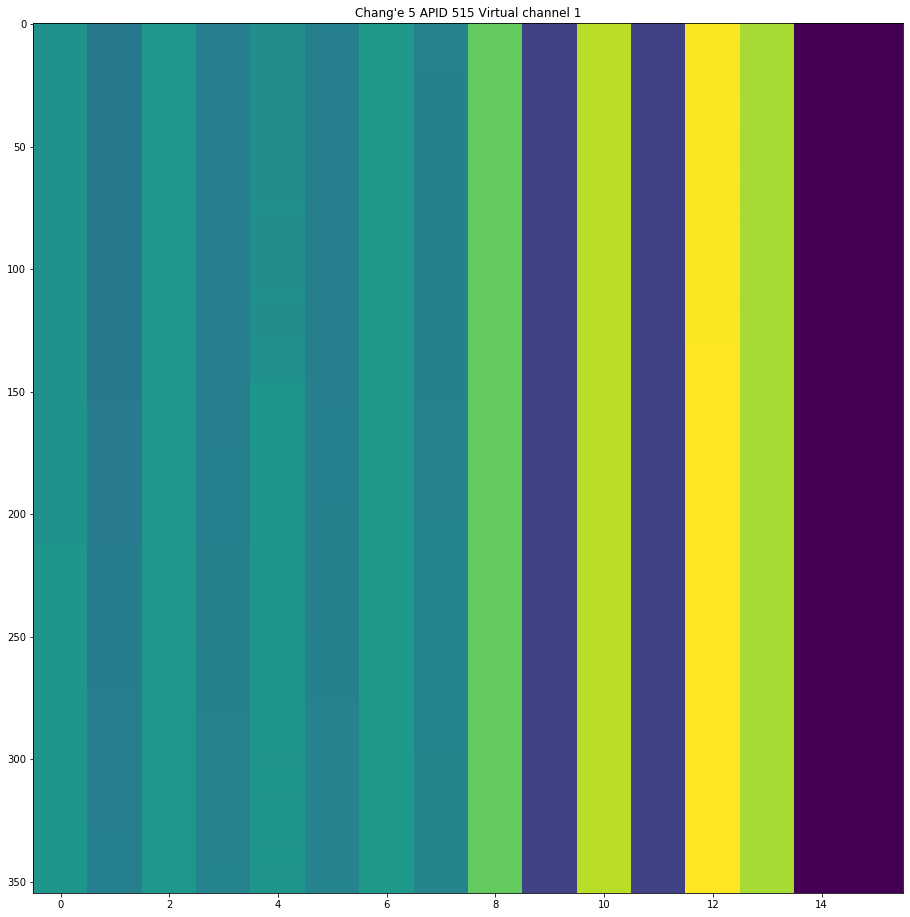

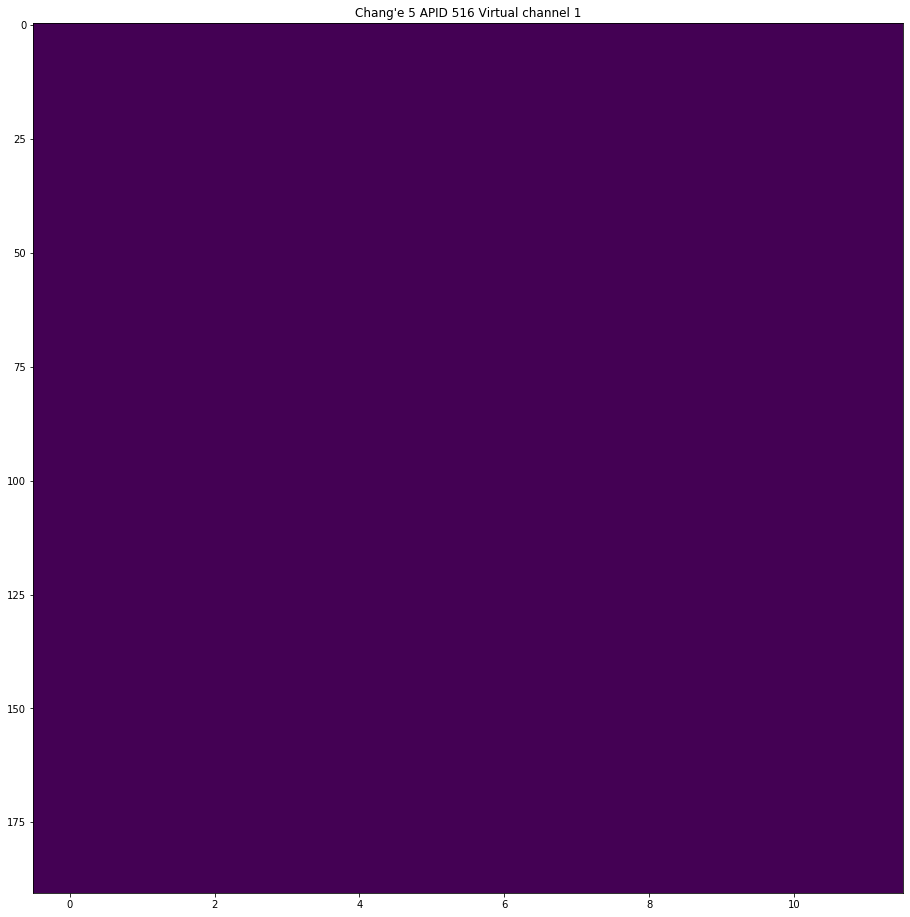

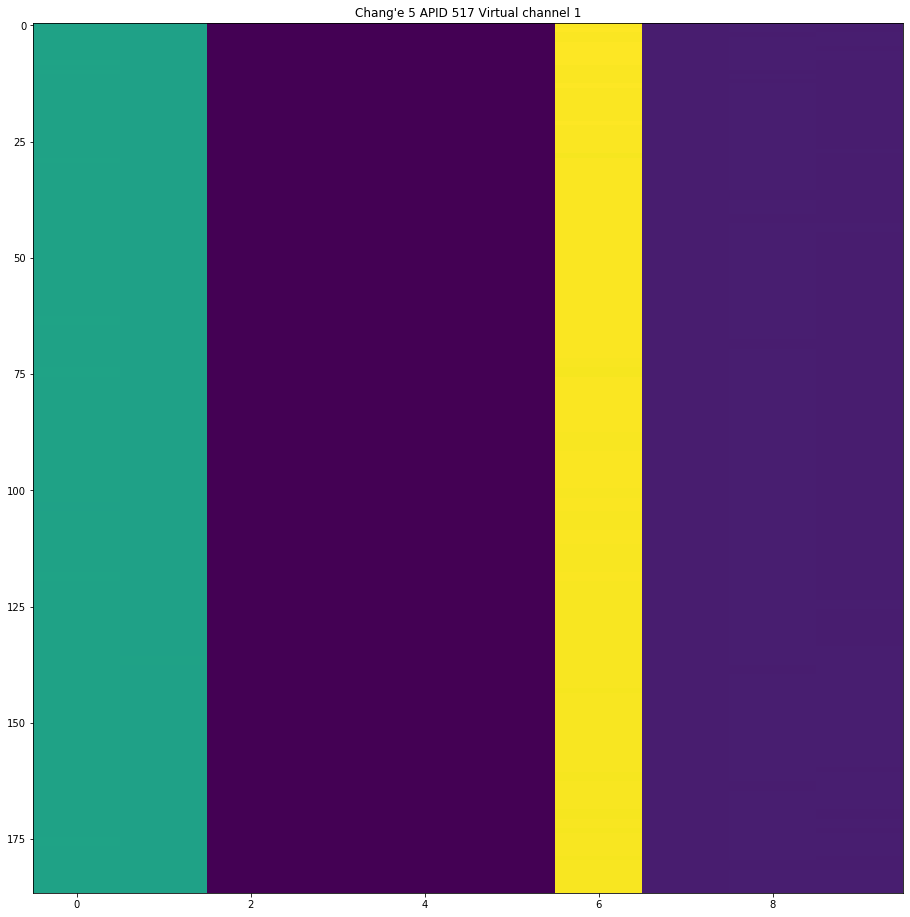

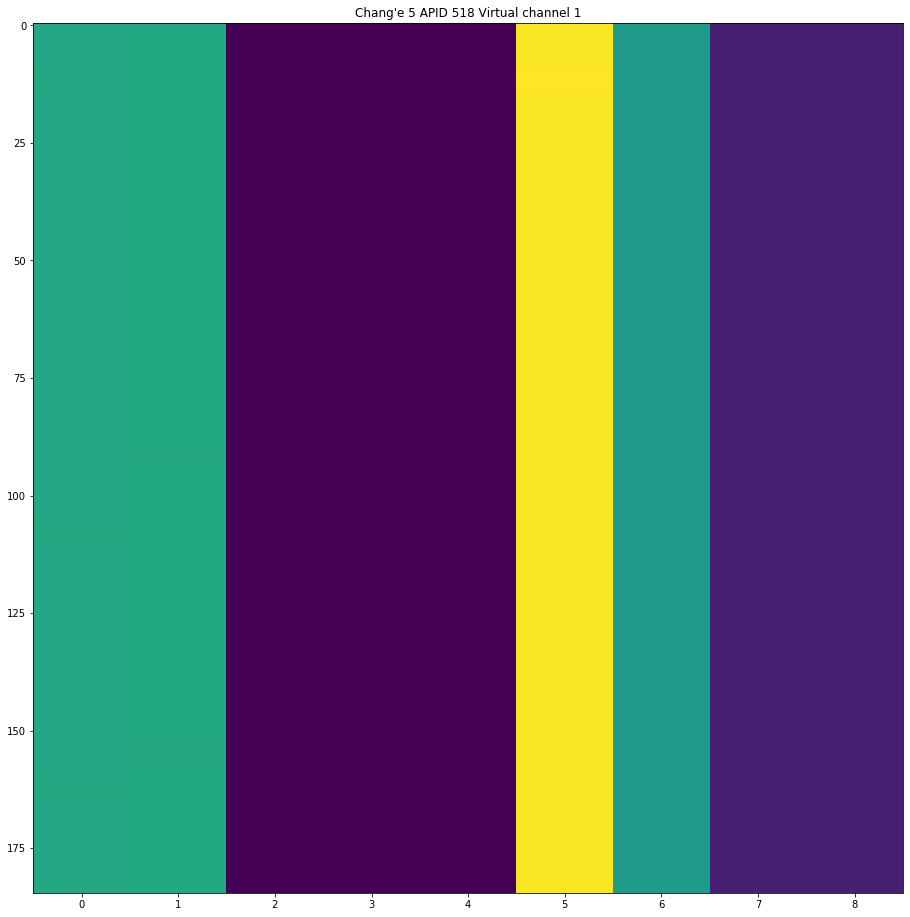

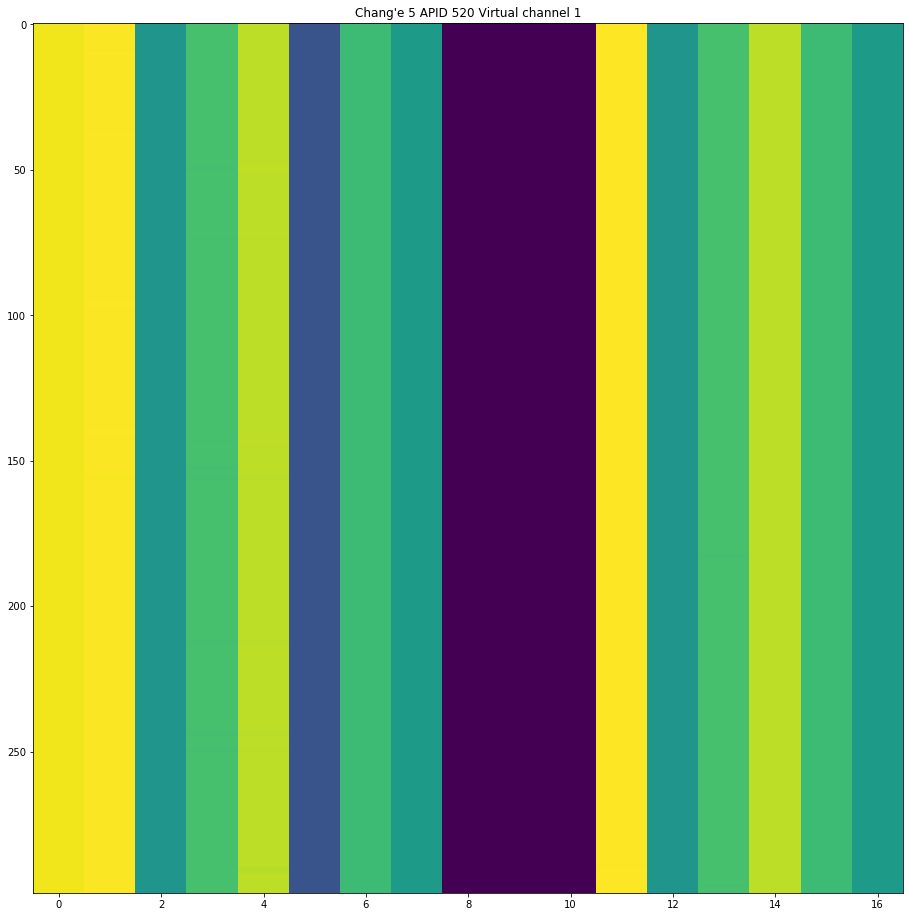

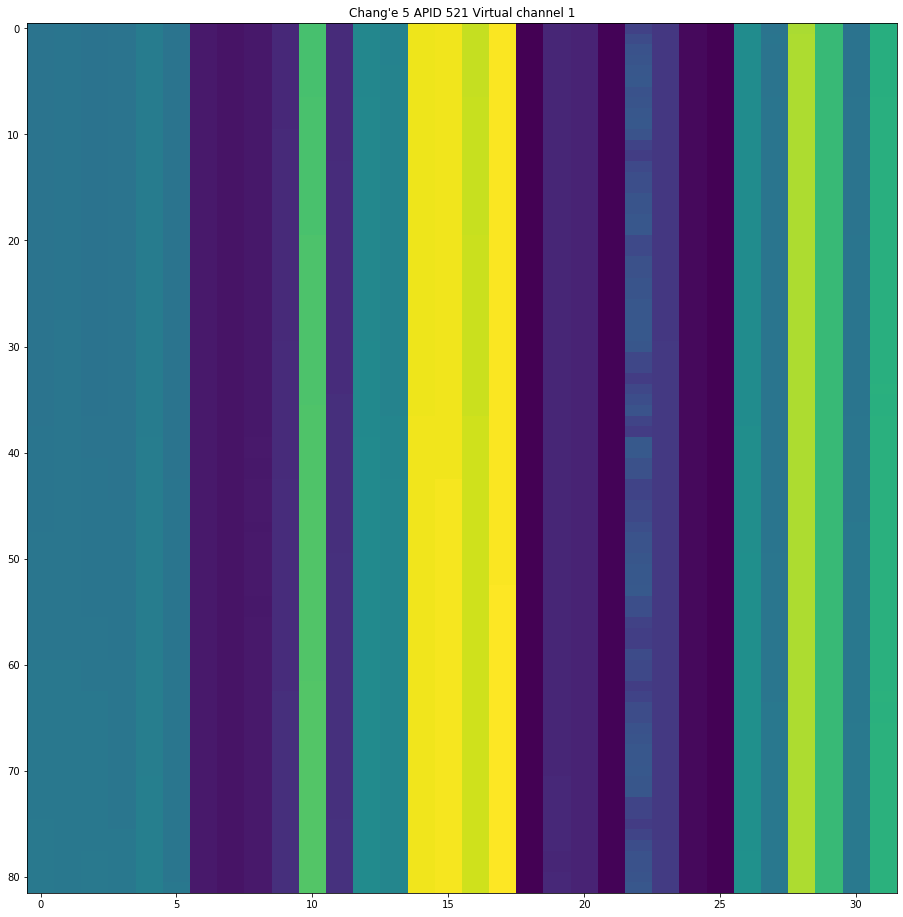

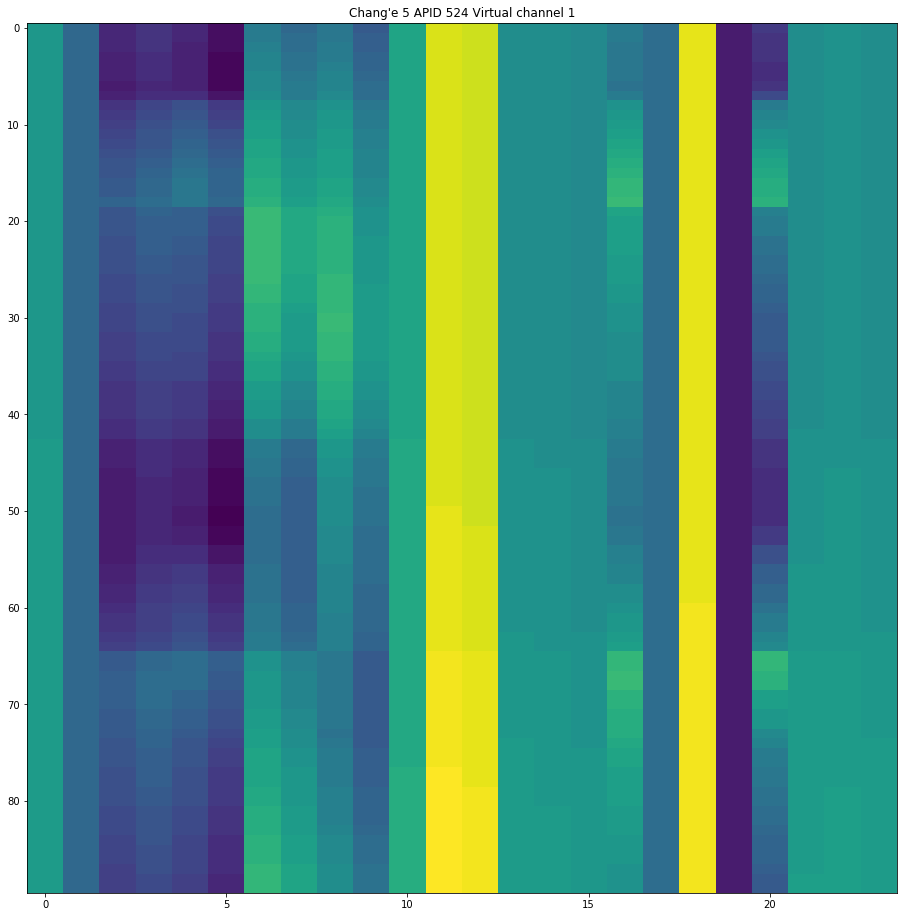

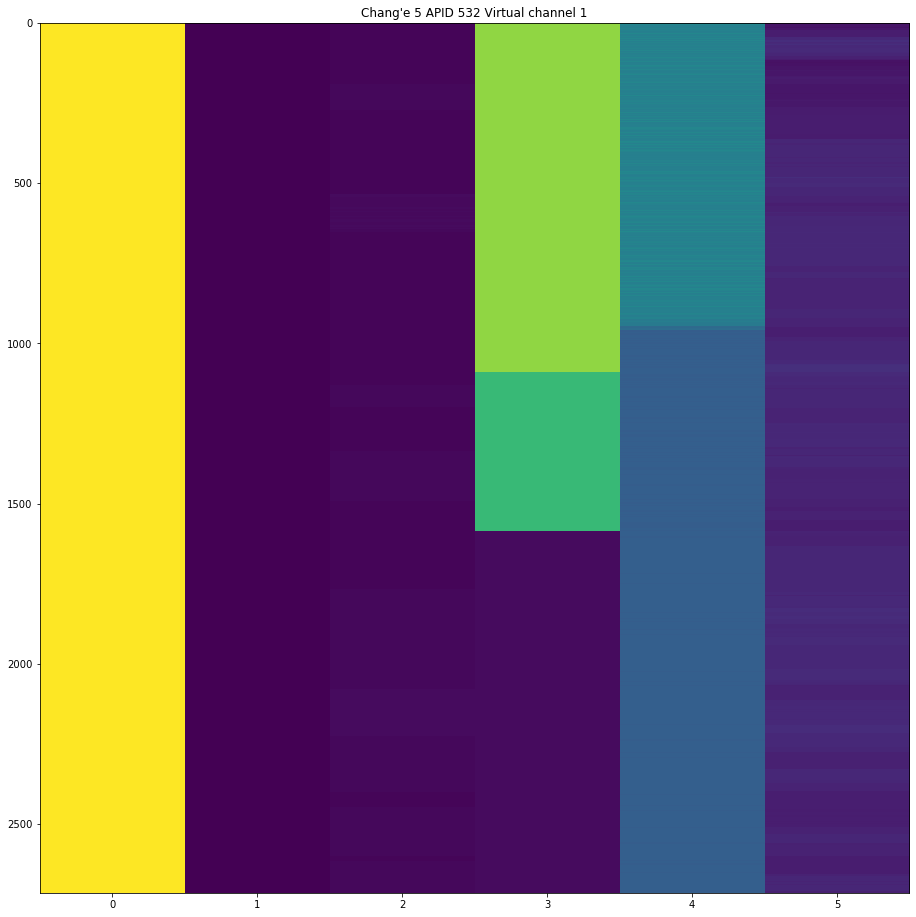

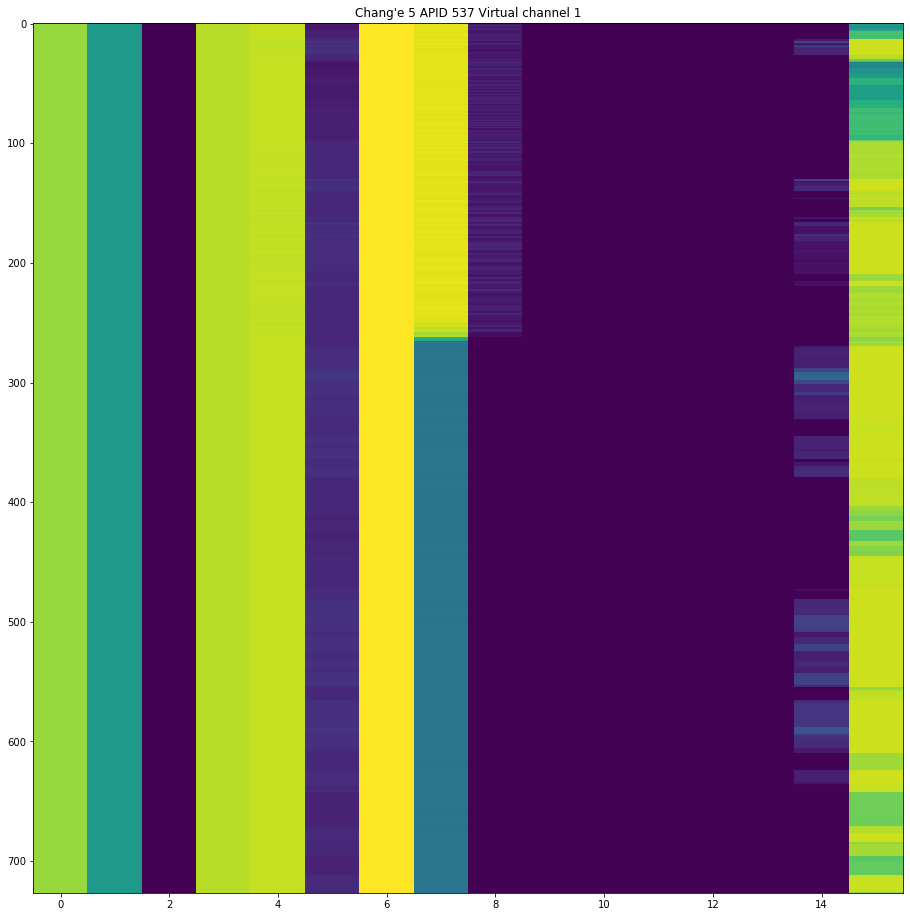

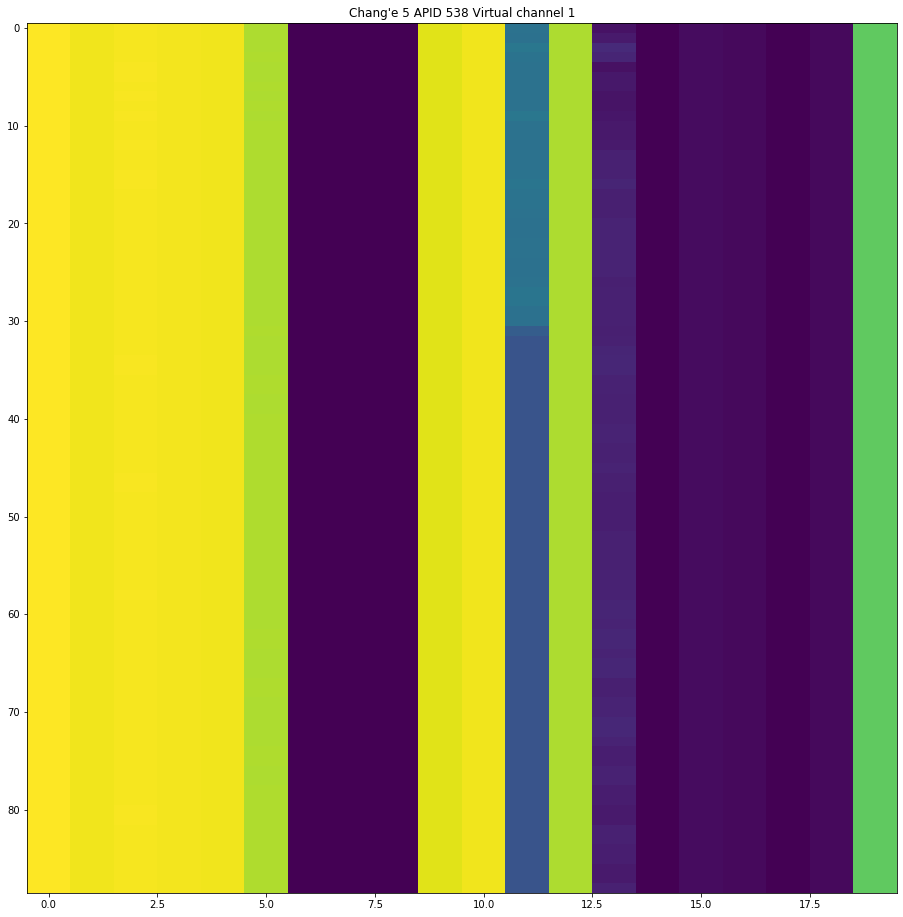

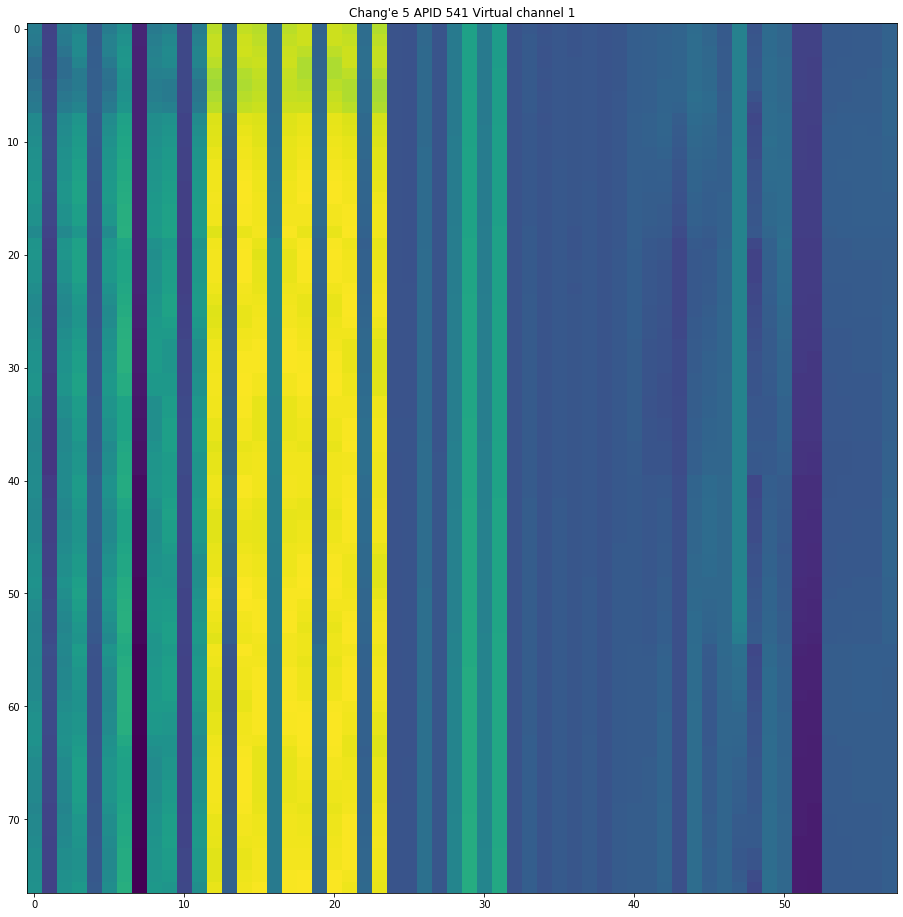

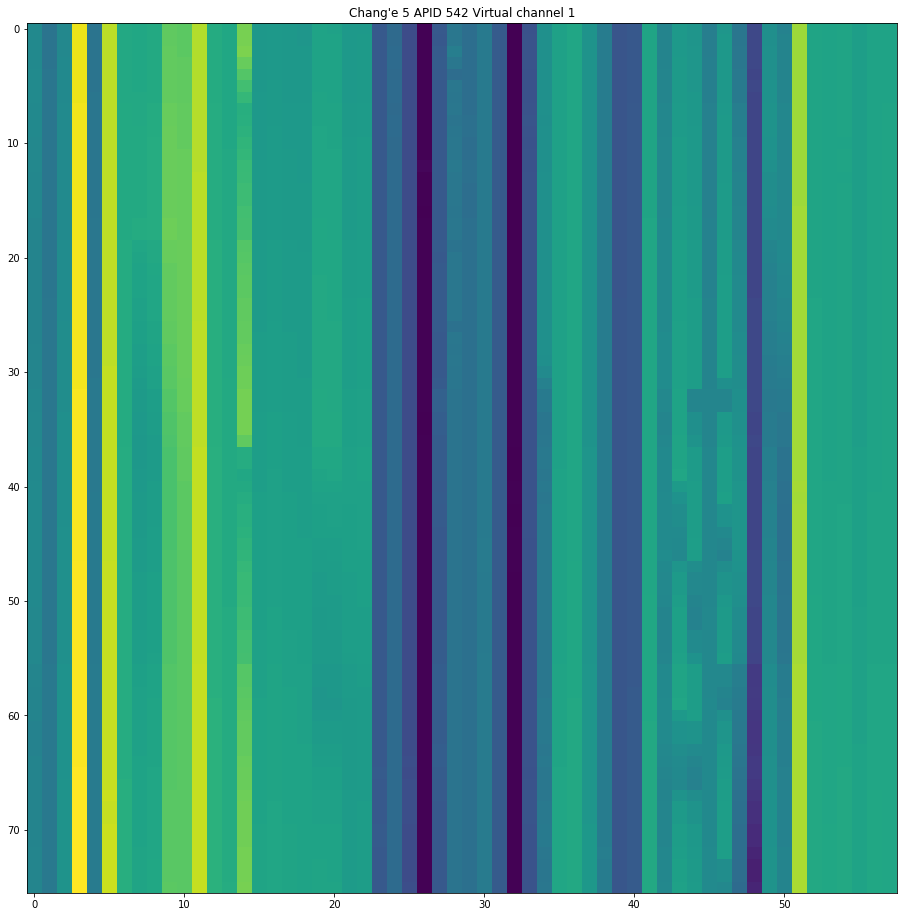

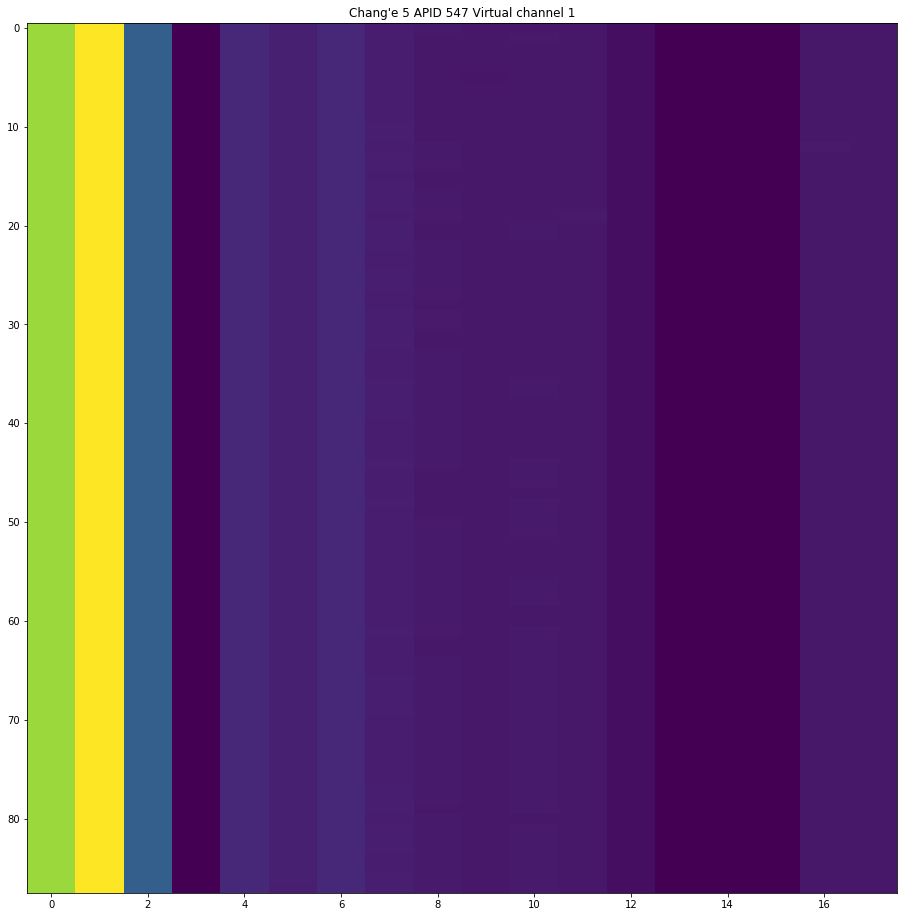

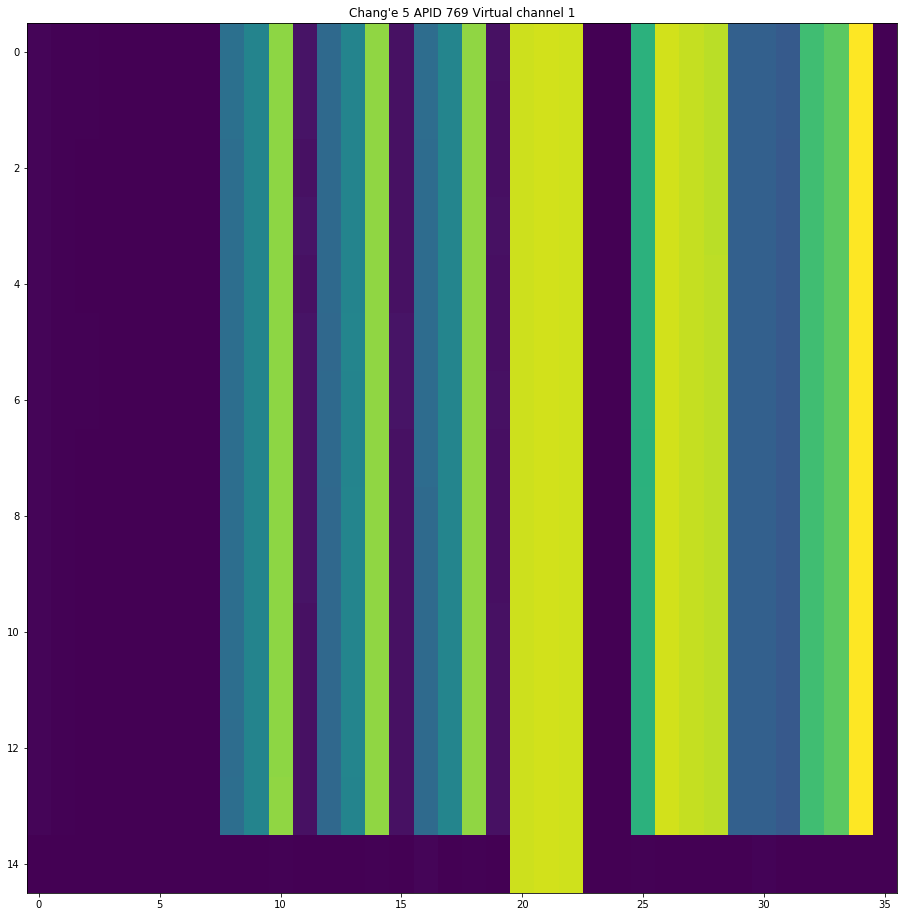

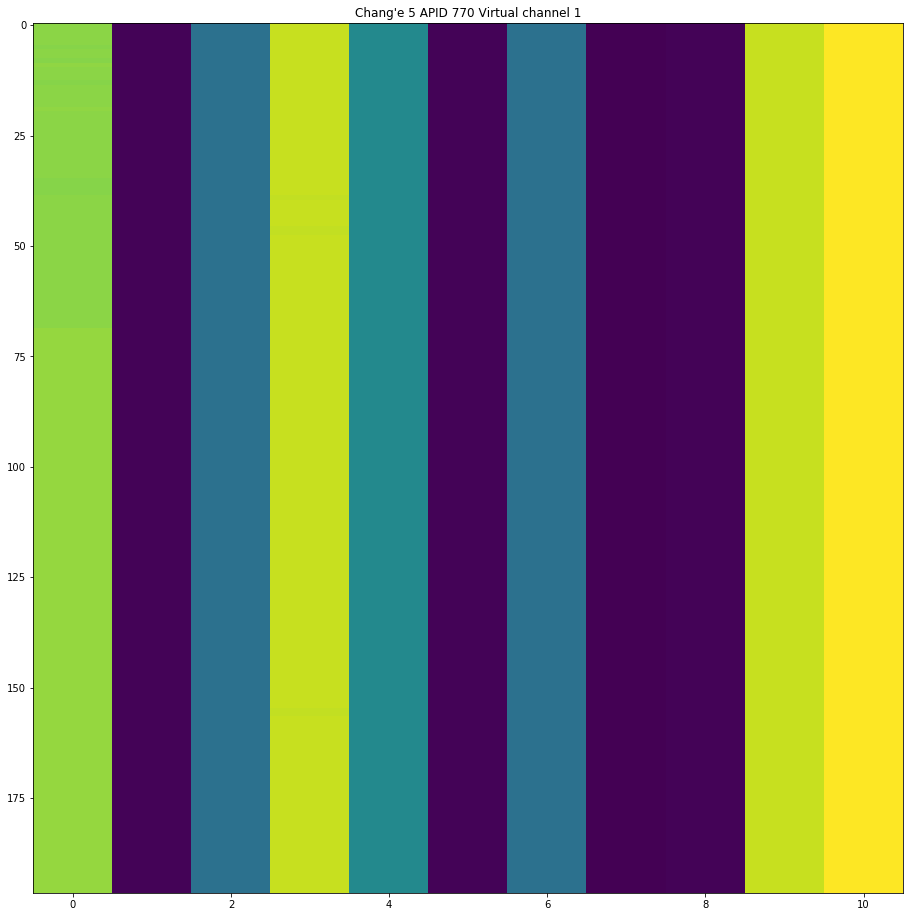

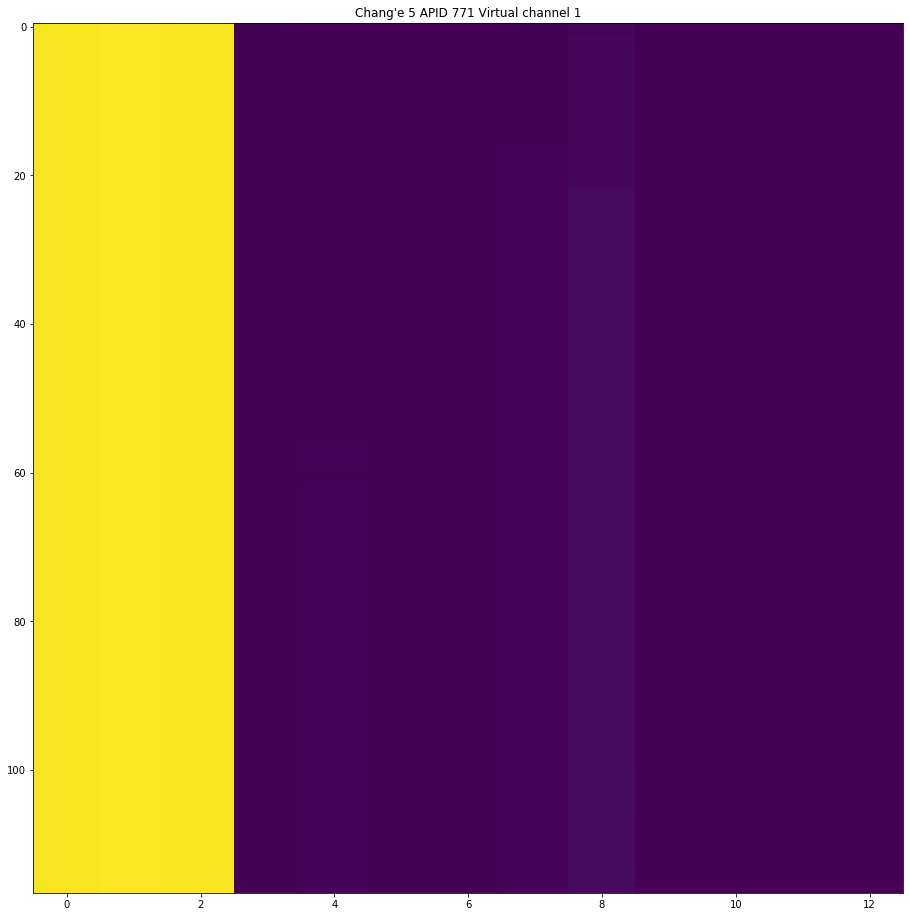

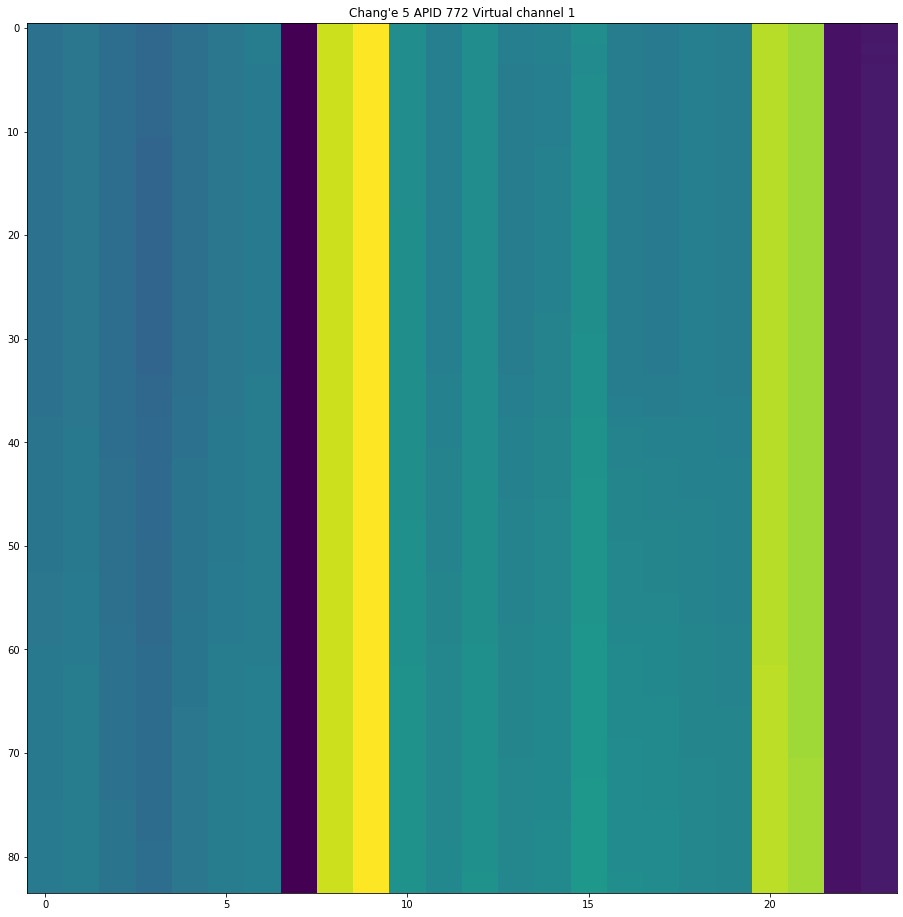

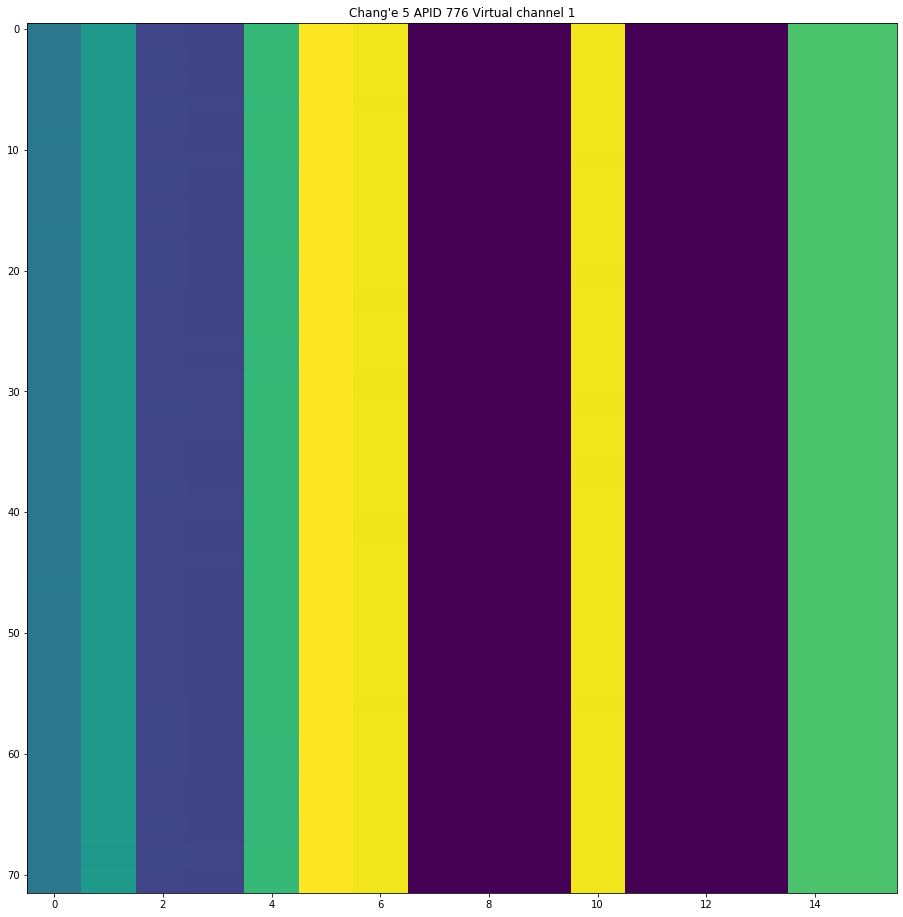

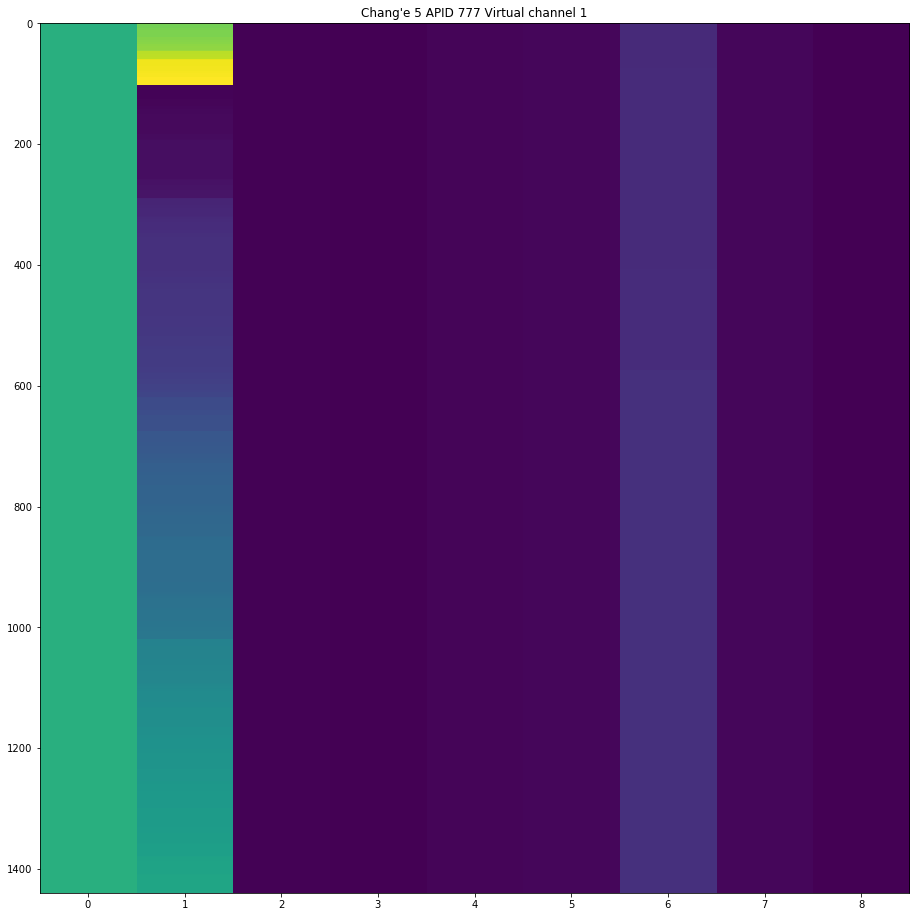

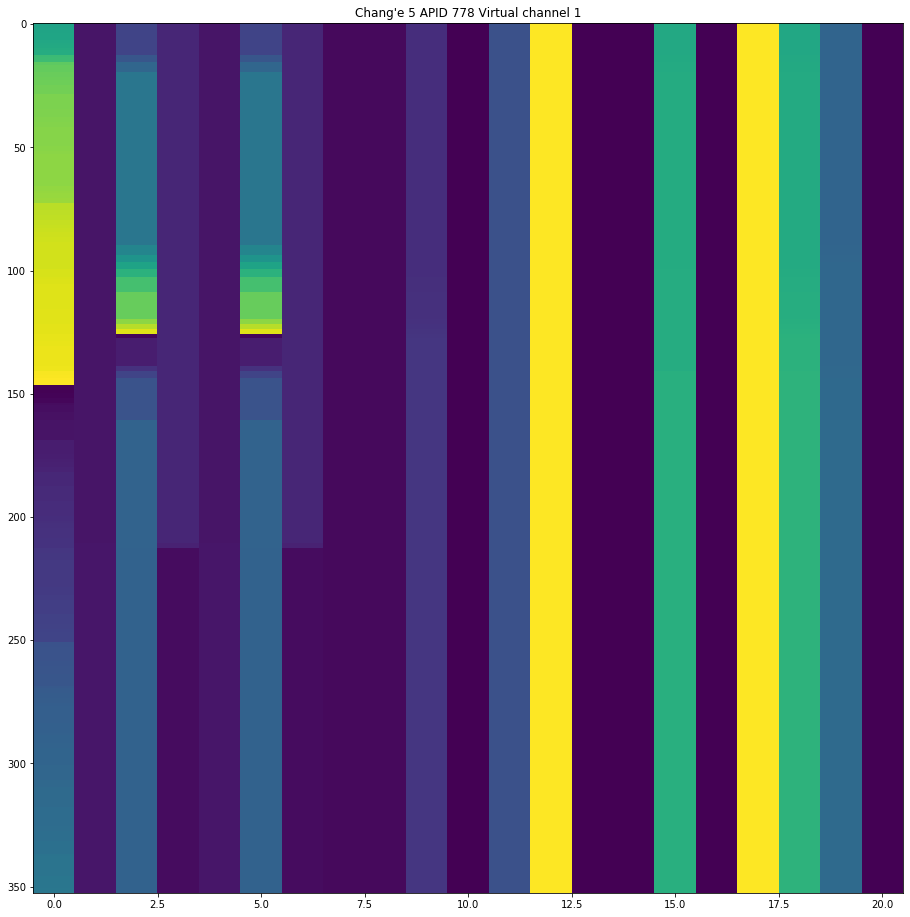

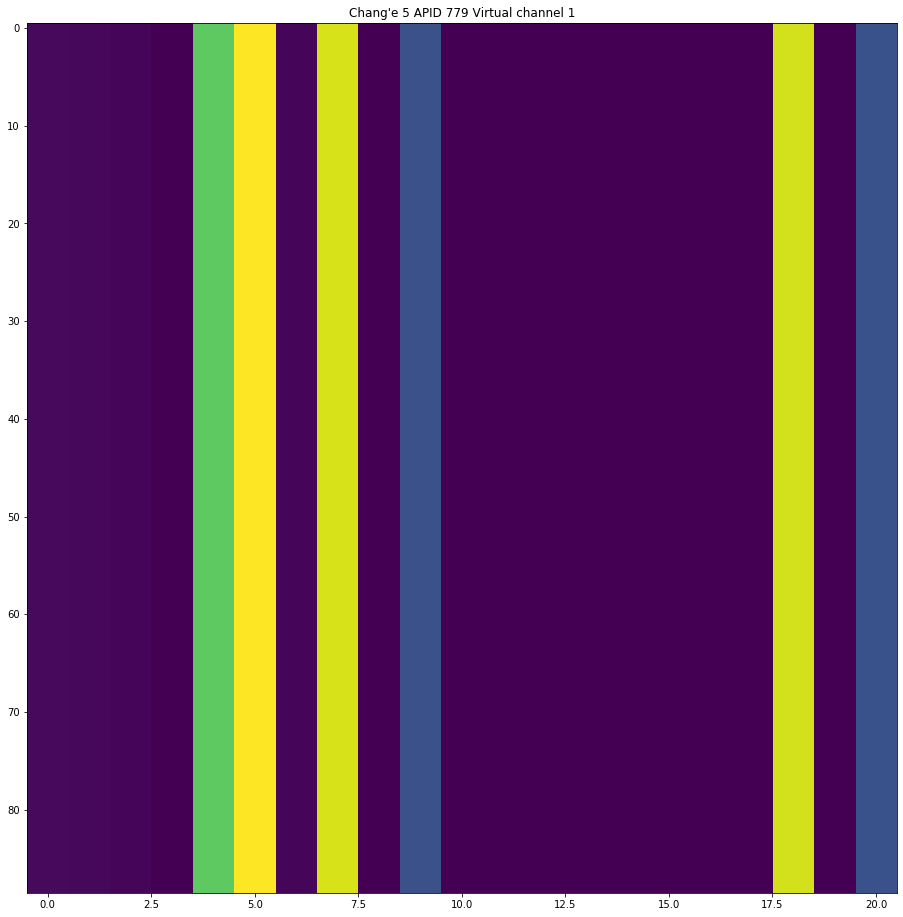

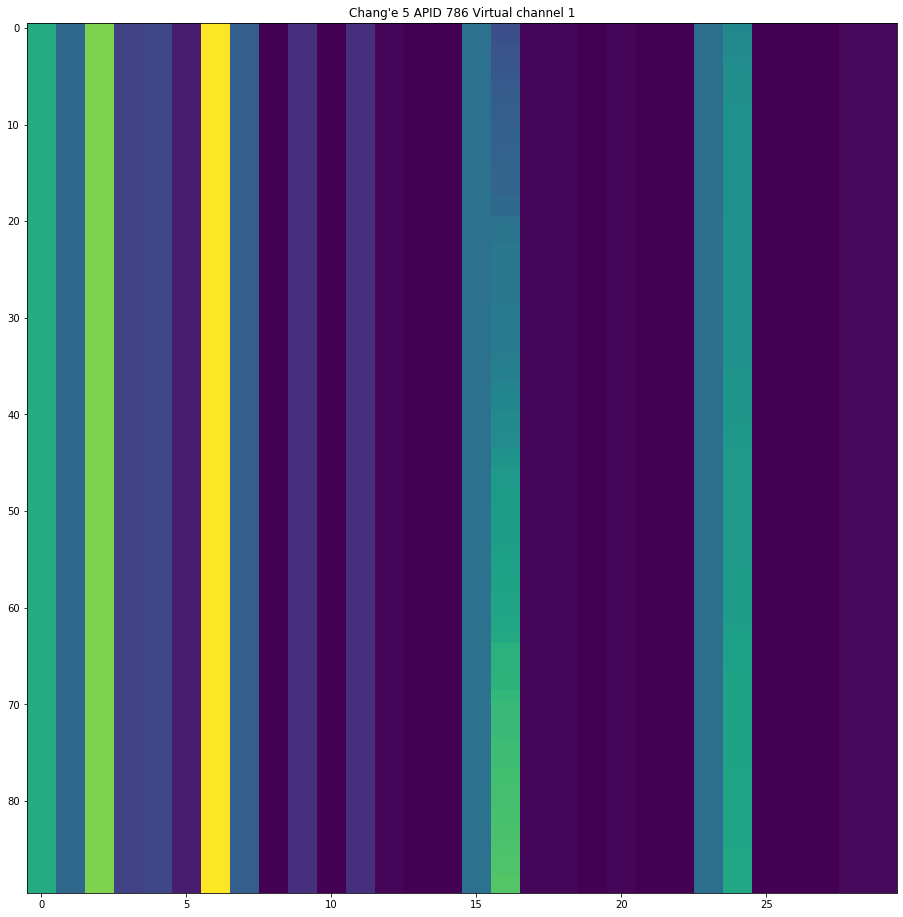

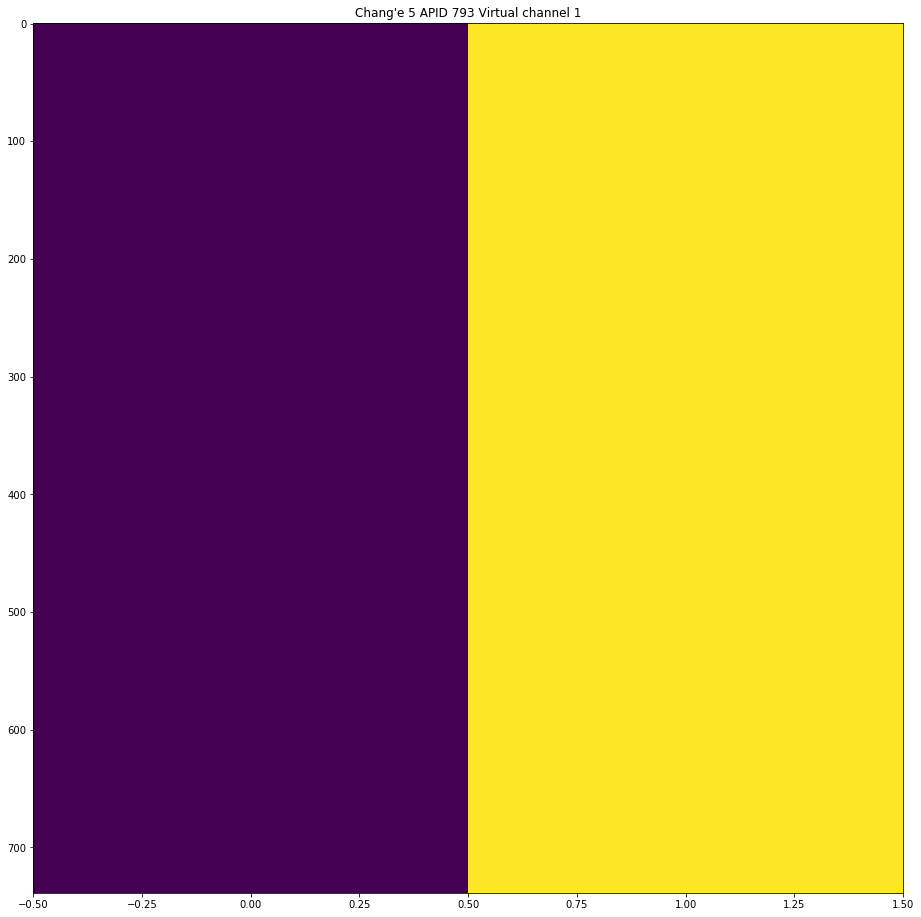

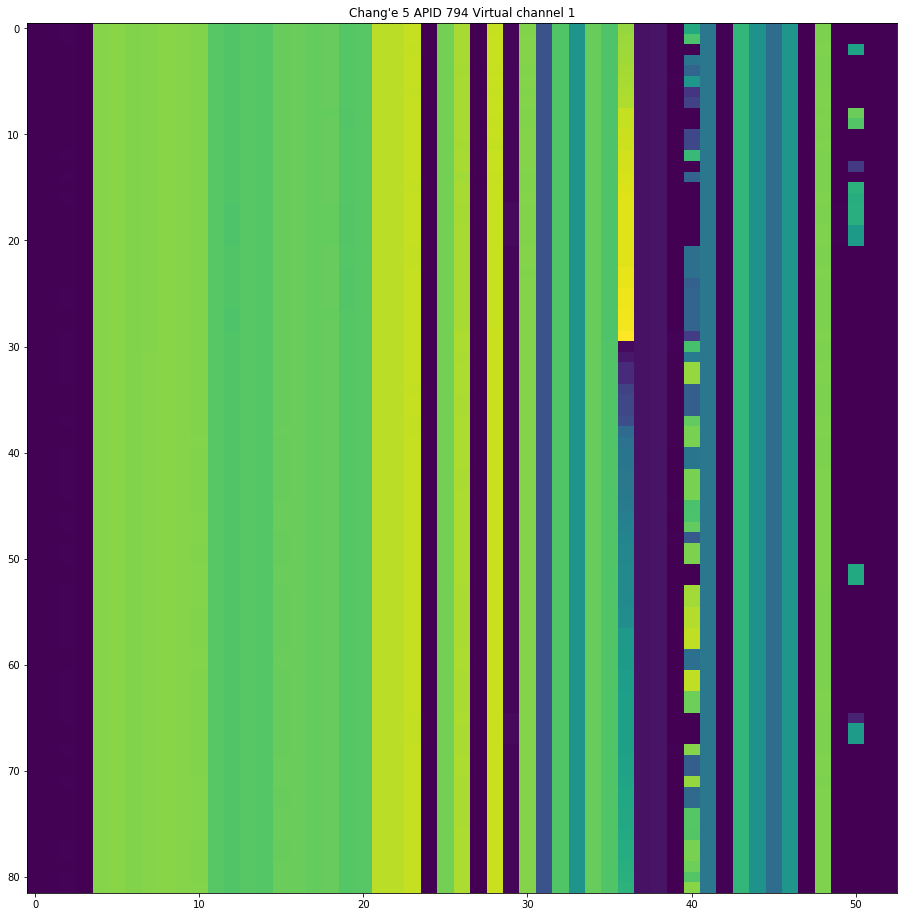

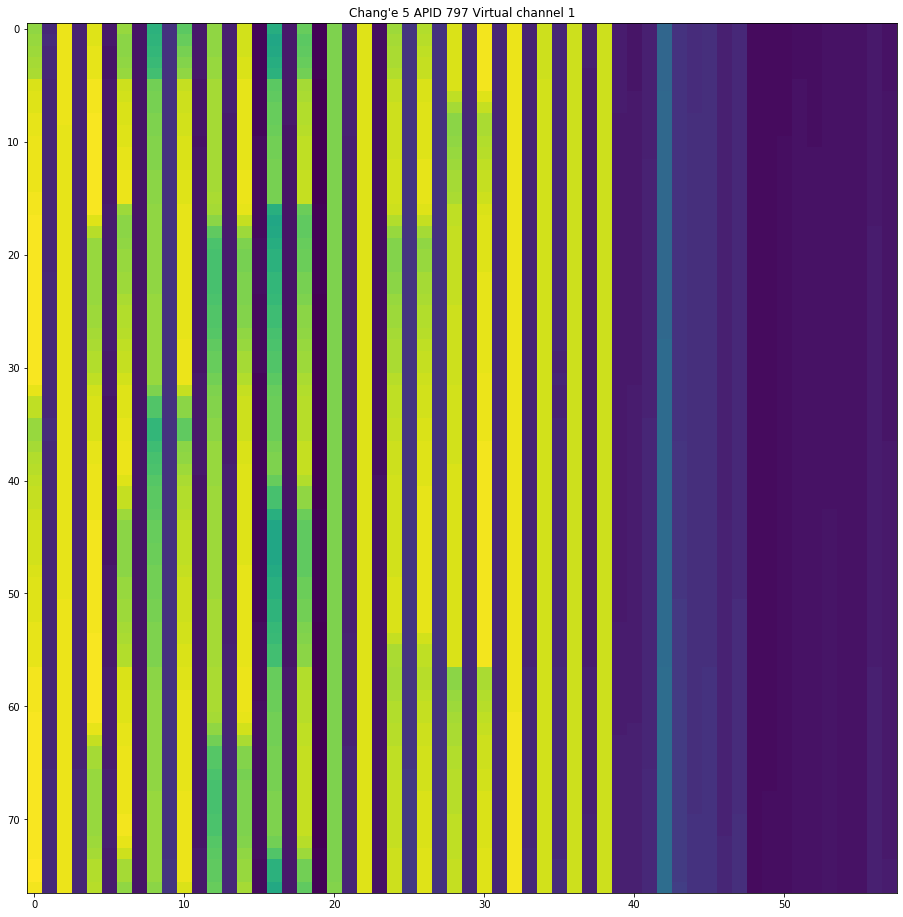

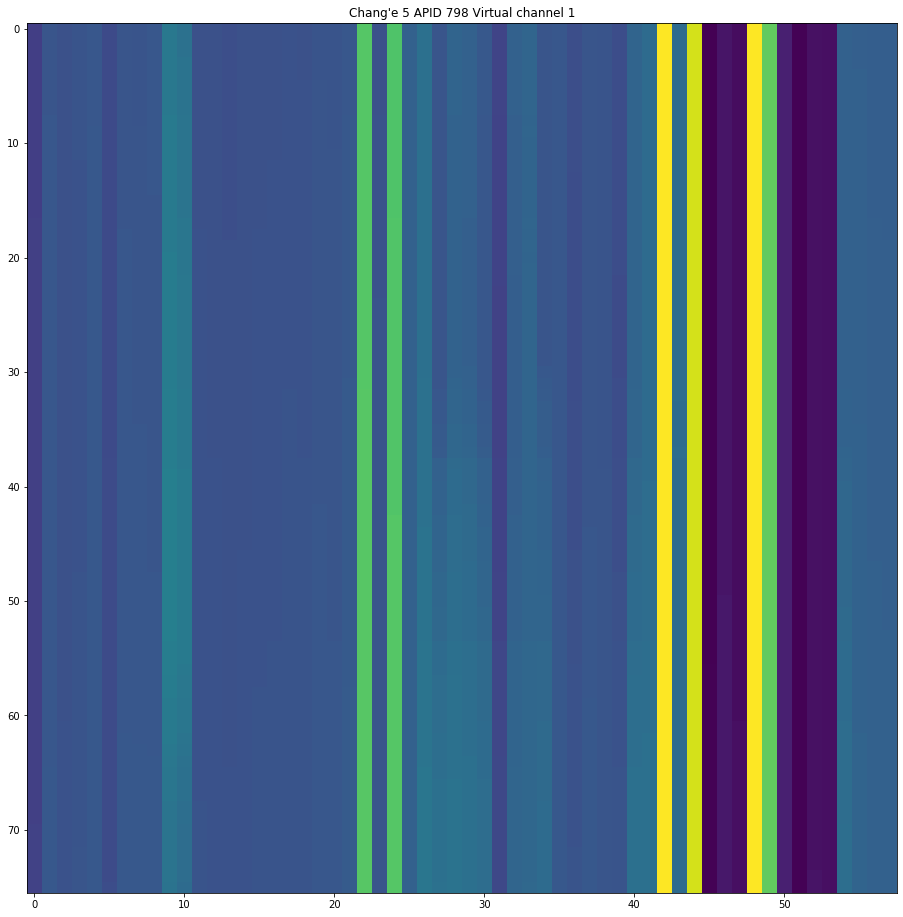

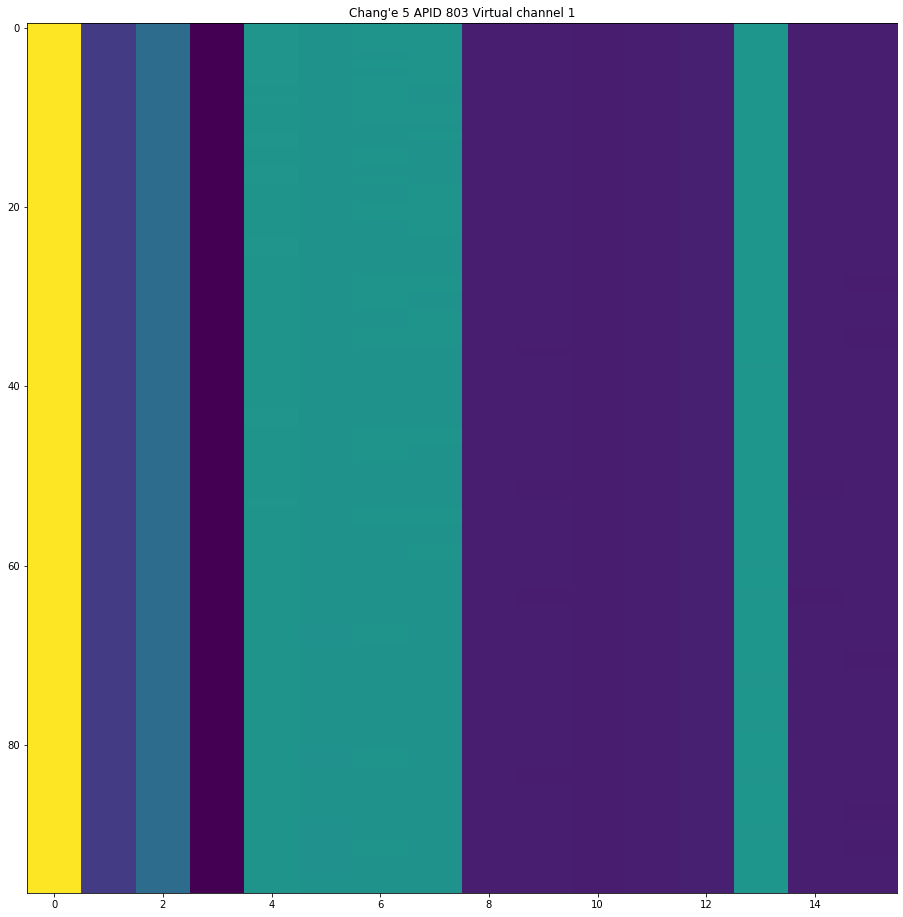

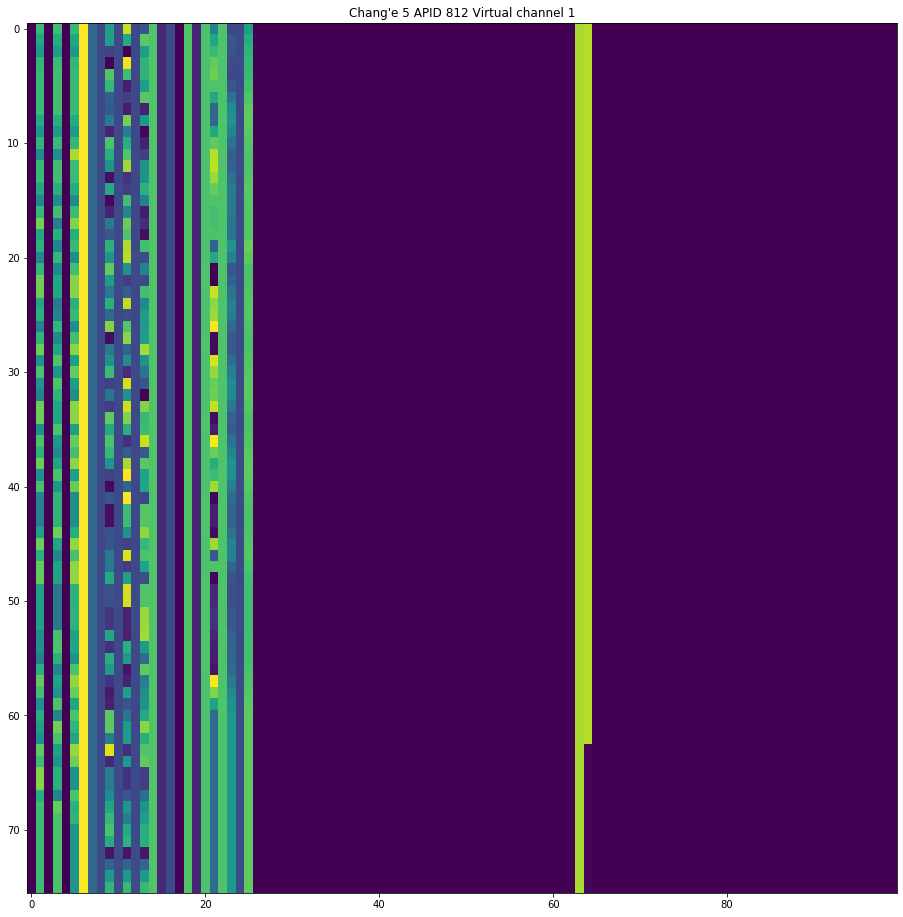

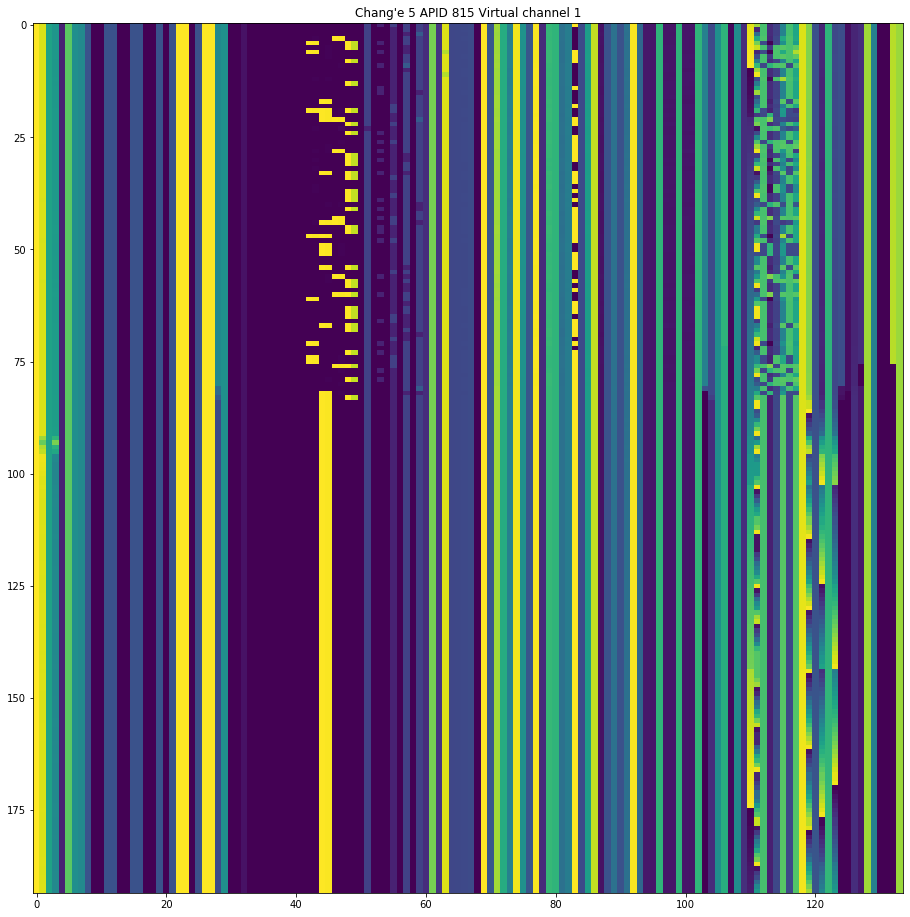

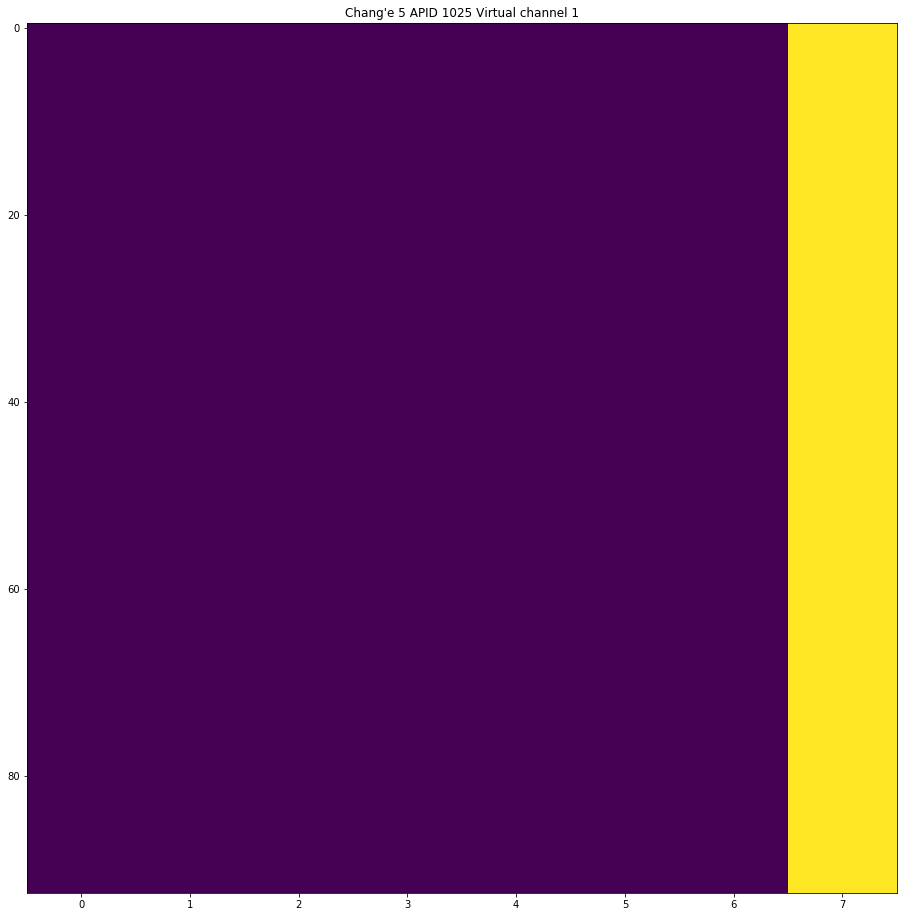

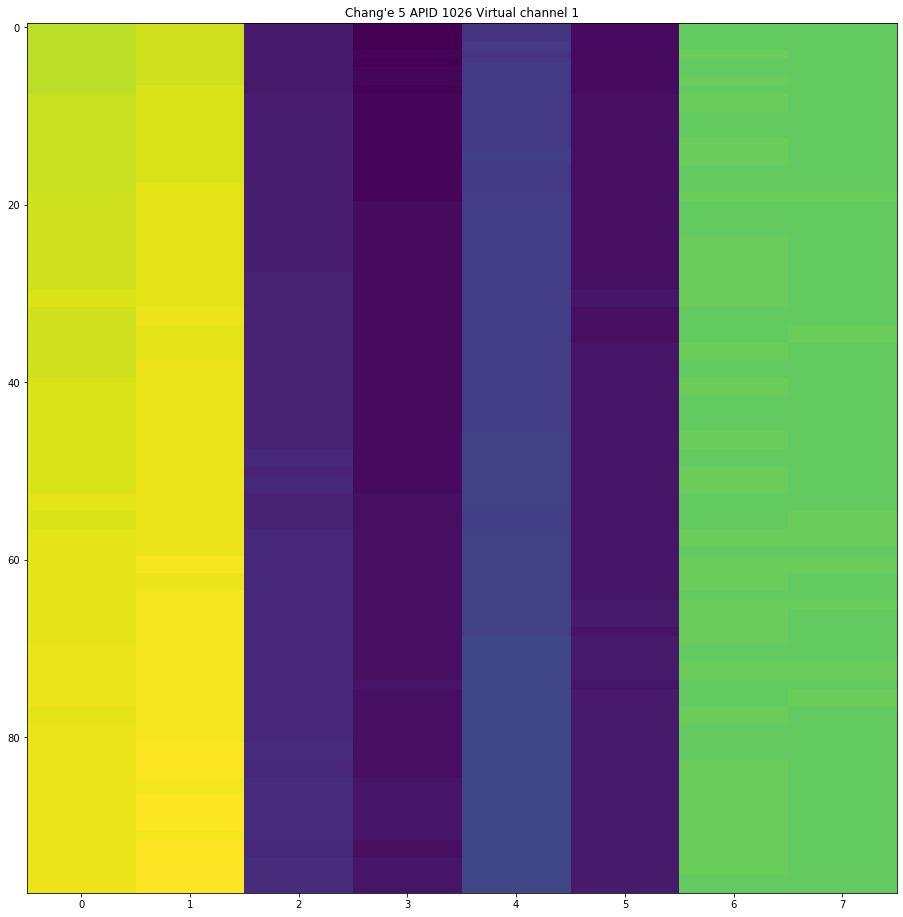

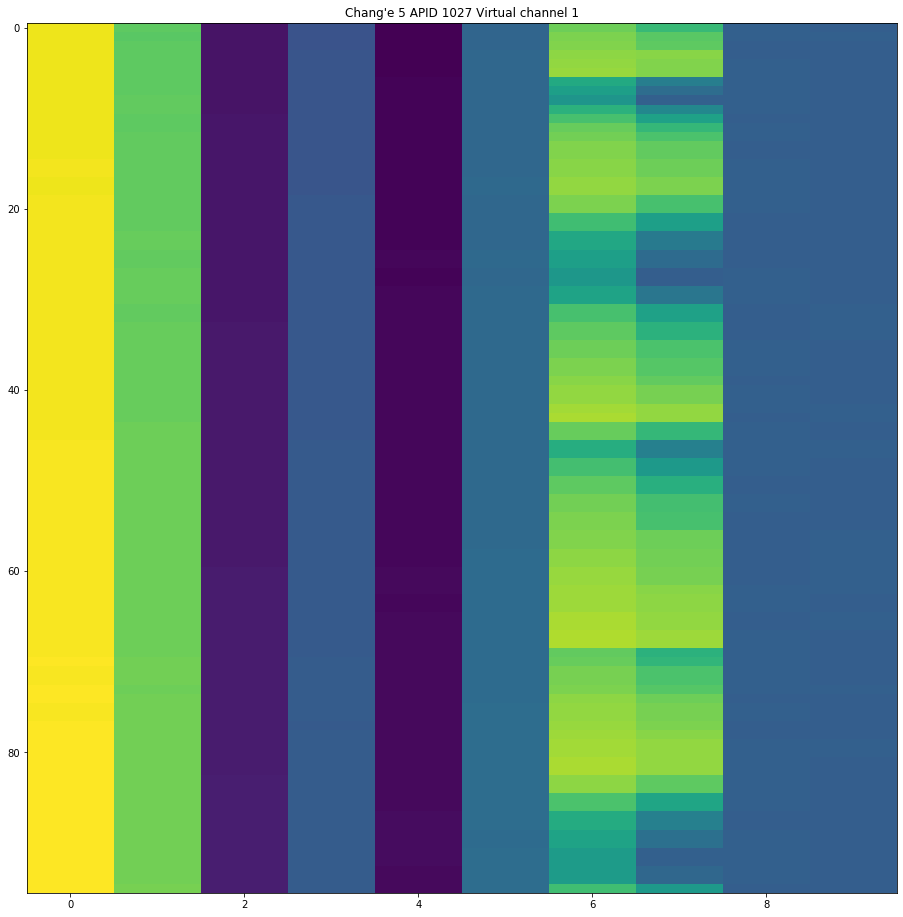

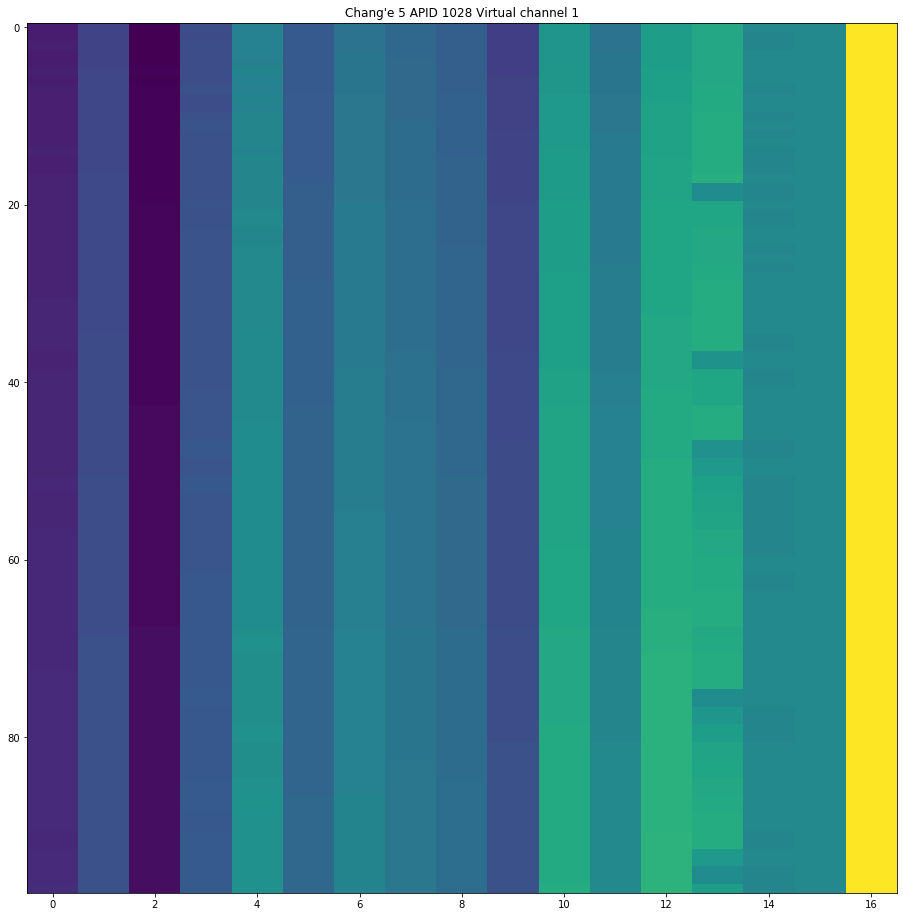

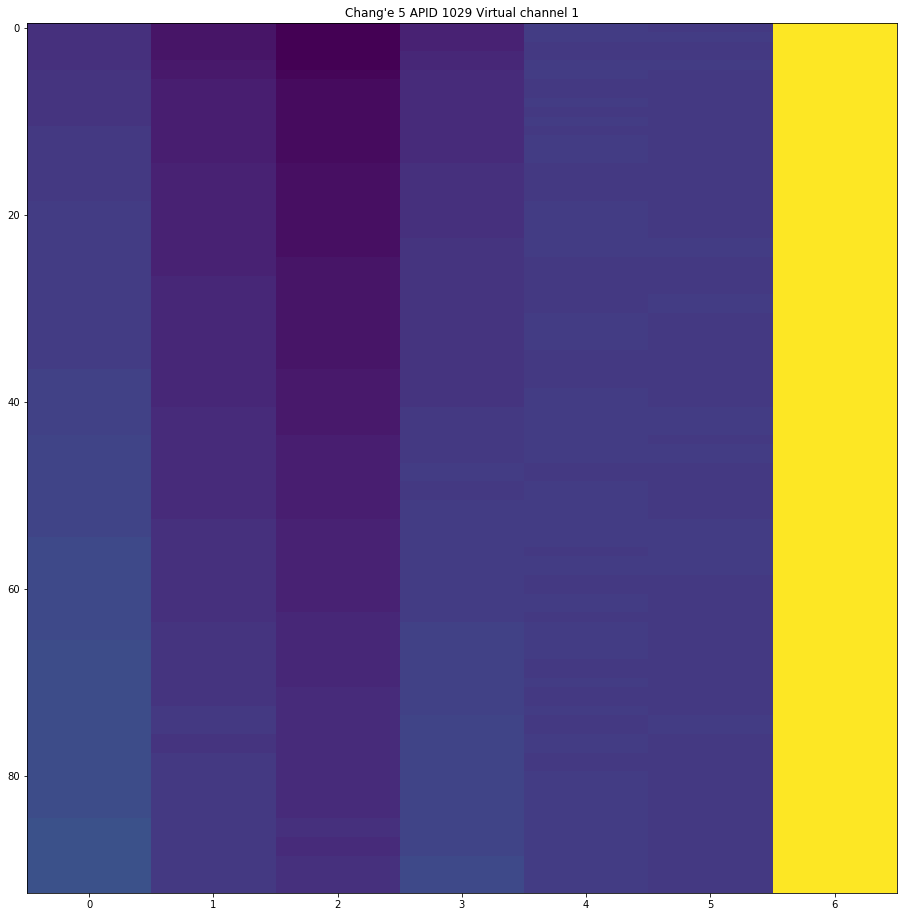

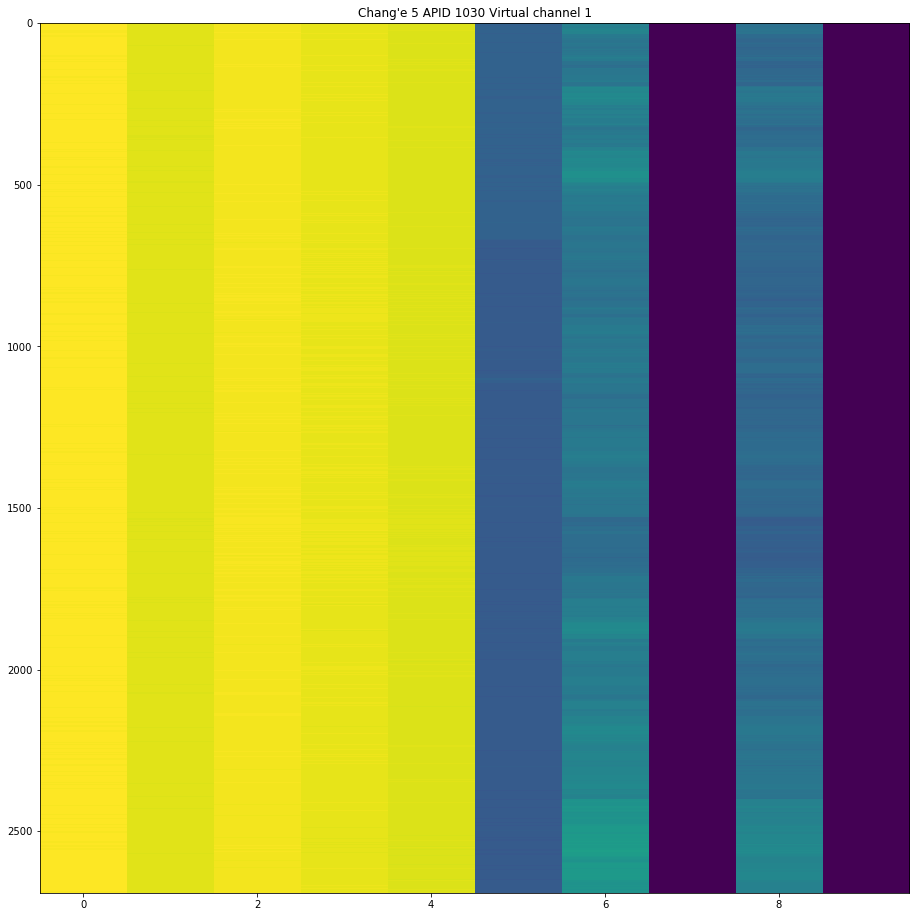

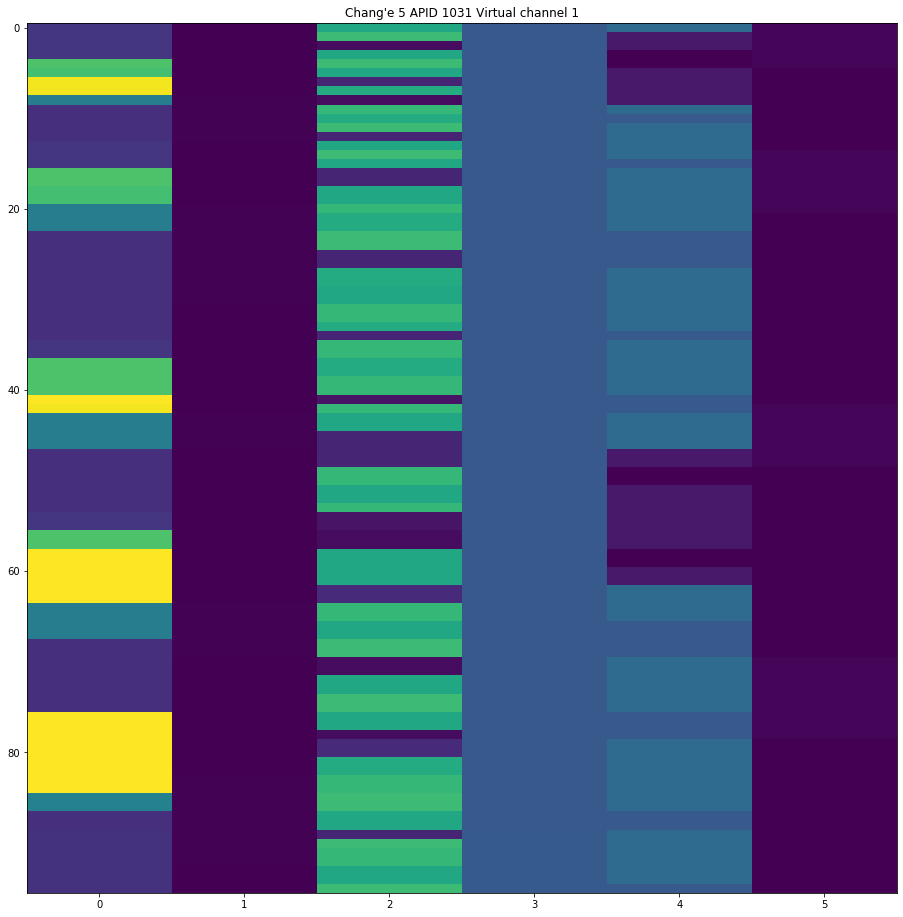

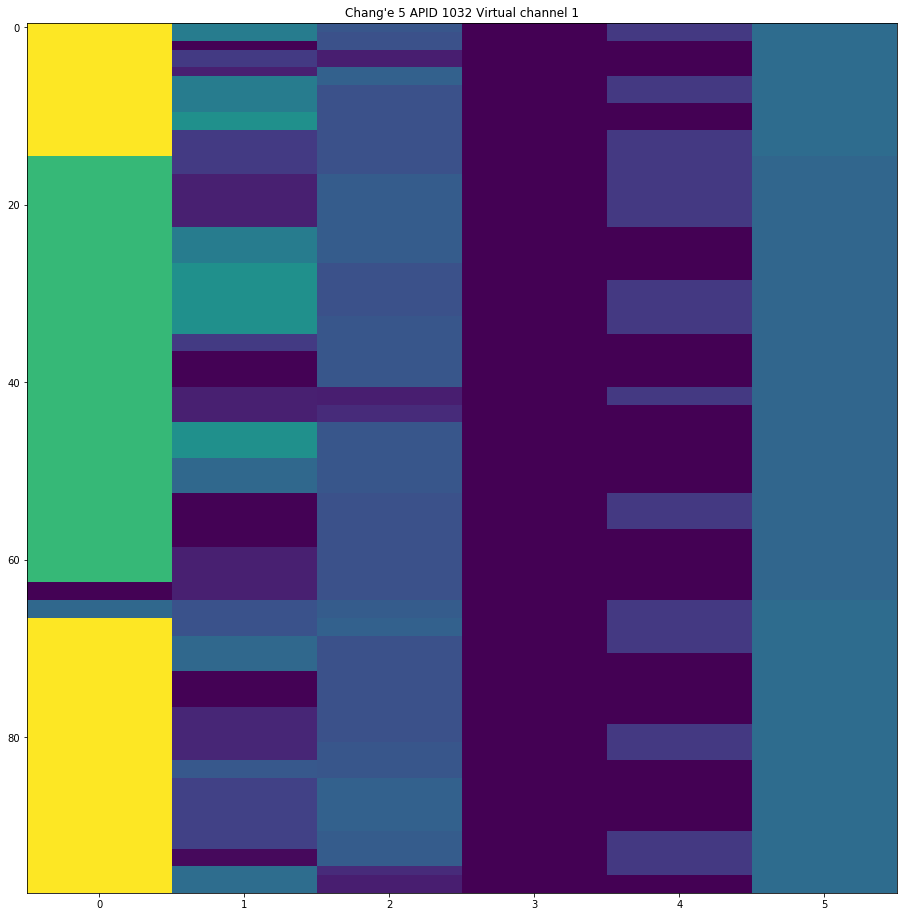

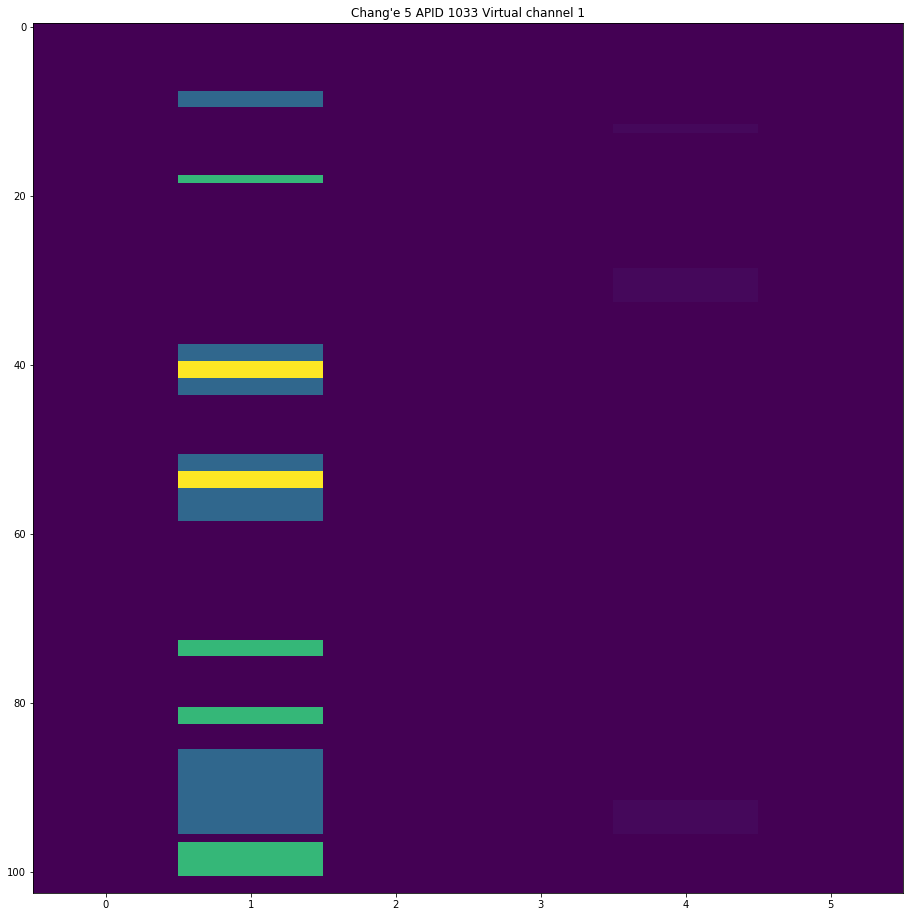

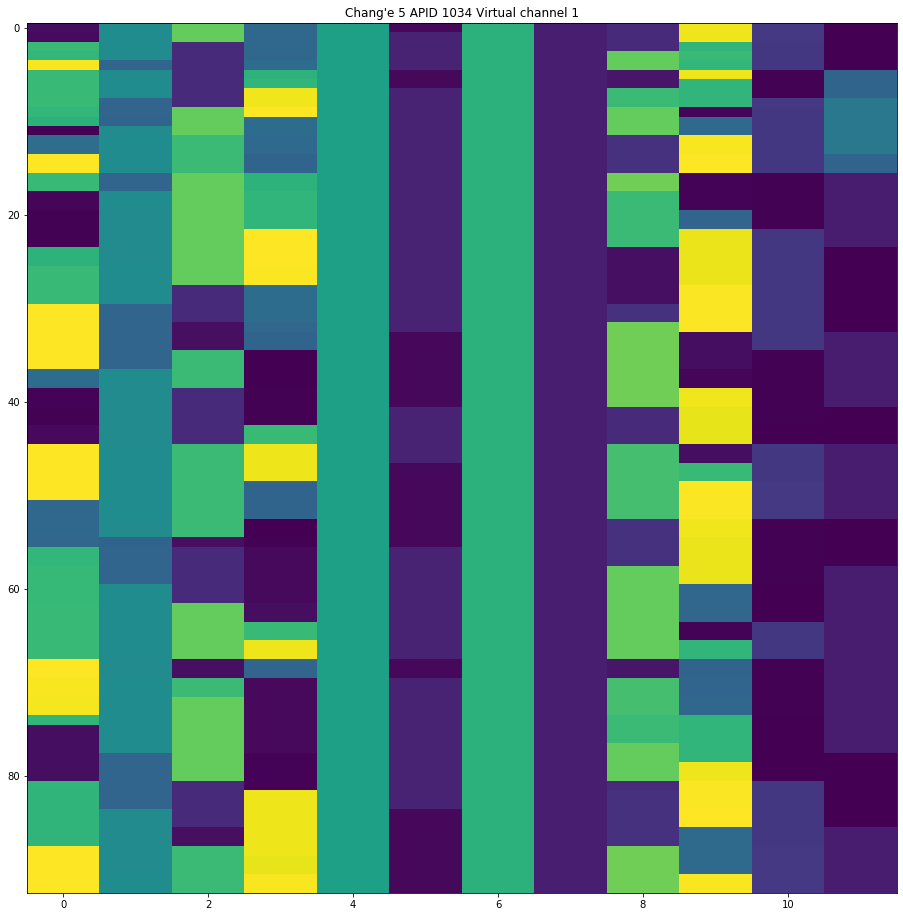

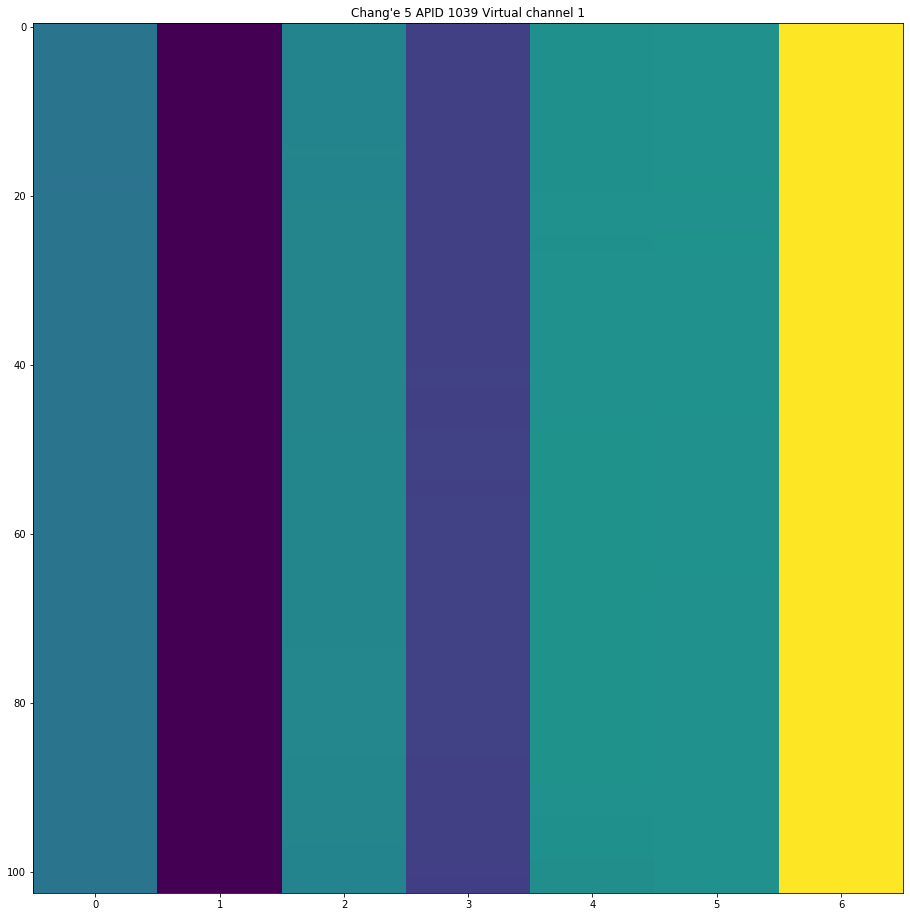

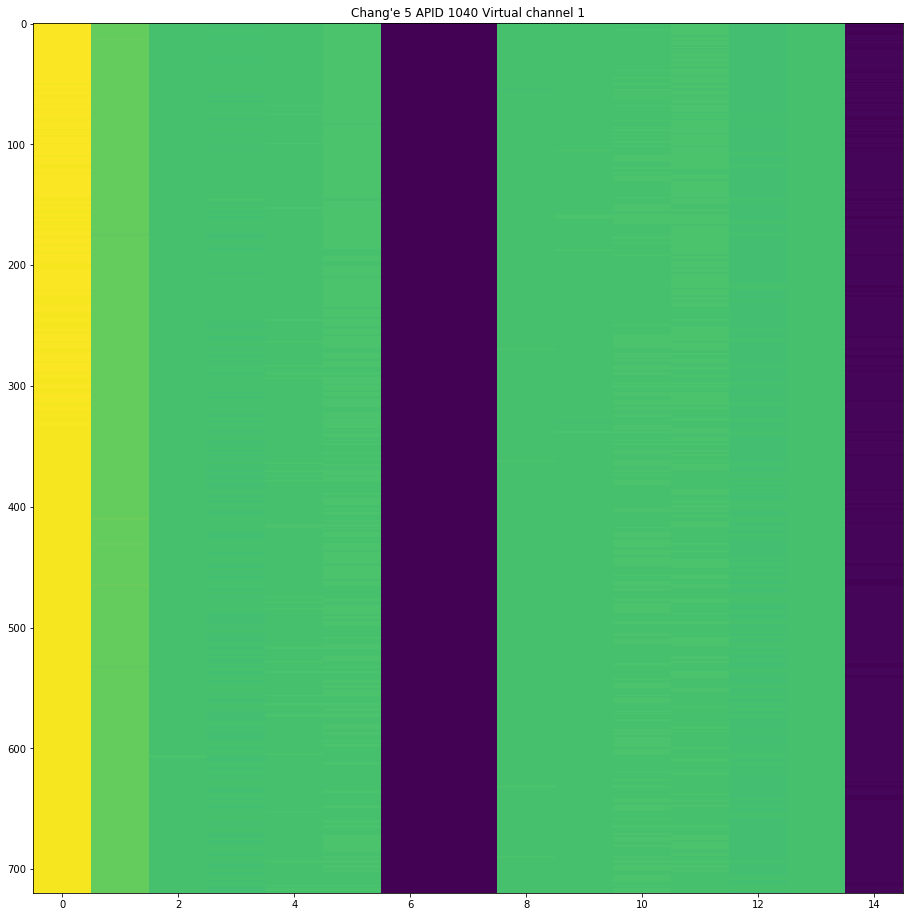

In [26]:
plot_apids(vc1_by_apid, None, 1)